# World Data League 2022

## 🎯 Challenge
Predict Waste Production for its Reduction


## 👥 Authors
* Péter Michaletzky
* Zsolt Kegyes Brassai
* Imre Boda

***

## 💻 Development

### Summary

Back in 2011 the city of Austin, TX committed to a strategic goal of reaching Zero Waste production by 2040 in their [Zero Waste Master Plan](https://www.austintexas.gov/sites/default/files/files/Trash_and_Recycling/MasterPlan_Final_12.30.pdf), forecasting 75% recycling ratio by 2020, while garbage collection statistics show a stagnating 24% ratio since 2012.
Population in the city is expected to grow from 1.00 million to 1.28 million by 2040, possibly further aggravating the "garbage situation", together with the increasing consumption per capita which also has the potential of contributing to more waste generated per inhabitant. Careful planning of recycling plant and landfill (where non-recycled waste is buried), and also transport vehicle capacity and personnel is the interest from the city budget point of view.
Our approach was two-fold:

1. We wanted to give a tool to waste management planning that can forecast waste volume on the short run, i.e. down to weekly basis, allowing the precise planning of transport capacity per waste collection zone

2. Investigate long-term trends by taking into account social, economical, cultural factors in the "production" of garbage.

The structure of the notebook:

In chapter 2, 3, and 4 we introduce the key data. The conclusions are summarised at the beginning of the chapter, so if the reader is not interested in the details, then just feel free to read the summary and skip the rest.

Chapter 5 is dedicated to our Short Term tool which aims at improving work effectiveness.

Chapter 6 contains our Long Term Time Series analysis works.

Finally, in the appendix we put additional analysys for readers who would like to dig deeper in certain details

In [1]:
### Some notebook settings

# Set figure width / height
options(repr.plot.width=10, repr.plot.height=4)
# Disable warnings
options(warn=-1)

### 1. Import libraries

In [2]:
suppressMessages(library (RSocrata))
library(jsonlite)
library(data.table)
suppressMessages(library(dplyr))
library(tidyr)
suppressMessages(library(ggplot2))
library (ggrepel)
library(treemap)

***

### 2. 'Daily Waste Collection Data for Austin' dataset

***

**Chapter Summary**

First we read the 'Daily Waste Collection Data for Austin' dataset, which sometimes later in this document is often referred to as "master dataset".

Then we did an Exporatory Data Analysis and trend analysis in order to gain some insights.
The key findings of our EDA are the followings:

- Only waste weight feature ('load_weight') contains NA values, ballpark 10% of 'load_weight' is missing. These dominantly pertain to street sweeping type activities.

- We found that the data is fairly complete from 2005 to 2020, meaning that in these years we have waste data for practically every day. 

- Categories of waste (indicated by 'load_type' and 'route_type') changed over time. Some disappeared, some new appeared (probably changed name). We also saw that two two categories, "GARBAGE COLLECTION" and "RECYCLING - SINGLE STREAM" take majority of load weight and number of collections. These two categories seem to be reliable in data from 2005 and from 2009, respectively. In "RECYCLING - SINGLE STREAM" we see a big jump from 2008 to 2009. We are not sure about the real causes, we guess that this sudden sharp increase is due to some data collection / administrative change, i.e. the different RECYCLING categories were merged to the "RECYCLING - SINGLE STREAM". 

- Other categories are either irrelevant for the zero waste ambition (e.g. "YARD TRIMMING", "BRUSH", etc. are green waste), or too little in their contribution (share of weight or share of rounds), so we decided to focus on these two categories only.

- Trend shows that both "GARBAGE COLLECTION" and "RECYCLING - SINGLE STREAM" are kind of flattish the recent years, while the "GARBAGE COLLECTION" per capita trends maybe is on a very - very shallow decline. The problem is, however, that the population forecast shows steady growth, which means that Austin must make sure to decrease the per capita waste "production" in order to counter-balance population growth.

- There are a number of cases when an individual garbage collection weight is multiple times higher than the yearly average on that particular route. We can not imagine that a case where load weight is 35 (!) times of the yearly weight average can be anything else than outliar, i.e. data error.

- We found some other issues in data, which "per se" imposes no problem in our analysis, but do raise some concerns regarding data quality and integrity. These include:

    - Multiple occurrences of the same 'load_ID', which is supposed to be a unique ID. We found very few such cases, so for our analysis it makes no harm. 

    - Strange relation of 'record_date' and 'load_time'. In most of the cases 'record_date', which supposed to be the recording date of an event happenning at 'load_time', is 1 day ahead of the actual event. However, we found record_date ~20 years before the actual event... Though strange 'record_date' compared to the actual event is a norm in this dataset rather than exception, we decided to ignore this. Still, it raises data quality concerns.
    
    - The set contains two variables, 'load_type' and 'route_type', which seem to be identical in definition and also very similar but -disturbingly- not identical in values. As 'route_type' seemed to be slightly more consistent, we decided to ignore 'load_type' and work with 'route_type'.

**2.1. Read the 'Daily Waste Collection Data for Austin' dataset and do some useful conversions**

Set API Data

*Note: Not nice to include AppTokein in code, but found no other way to make sure that the submitted notebook in itself is executable*

In [3]:
APPToken <- "9d3VAbd7A0IY7f5CGrMvjh9uv"

Read data via socrata API

In [4]:
url_socrata <- "https://data.austintexas.gov/resource/mbnu-4wq9.csv"
data <- read.socrata(url_socrata, 
                        app_token = APPToken)

Dataset structure: 

In [5]:
str(data)

'data.frame':	740873 obs. of  8 variables:
 $ report_date : POSIXct, format: "2010-05-17" "2010-07-07" ...
 $ load_type   : chr  "GARBAGE COLLECTIONS" "BULK" "RECYCLING - SINGLE STREAM" "GARBAGE COLLECTIONS" ...
 $ load_time   : POSIXct, format: "2010-05-17 10:42:00" "2010-07-07 10:52:00" ...
 $ load_weight : num  17500 7880 14080 14680 10700 ...
 $ dropoff_site: chr  "TDS LANDFILL" "TDS LANDFILL" "TDS LANDFILL" "TDS LANDFILL" ...
 $ route_type  : chr  "GARBAGE COLLECTION" "BULK" "RECYCLING - SINGLE STREAM" "GARBAGE COLLECTION" ...
 $ route_number: chr  "PAM71" "BU06" "RWAS35" "PAT70" ...
 $ load_id     : int  368514 374013 525500 760581 290950 690900 319532 892915 377604 778231 ...


Convert date and datetime fields, and extract year for easier aggregation later:



In [6]:
num_dates <- c("report_date")
num_datetimes <- c("load_time")
dt <- data %>%
  distinct () %>%
  mutate_at(all_of (num_datetimes), list (cr_date = ~ as.Date (., format = "%m/%d/%Y") )) %>%
  mutate (year = format(cr_date, format = "%Y")) %>%
  mutate_at(all_of(num_dates), as.Date, format = "%m/%d/%Y")%>%
  mutate_at(all_of(num_datetimes), as.POSIXct, format = "%m/%d/%Y %I:%M:%S %p") 

In [7]:
# Sanity check: check if all conversion were successful, i.e. this basically tests if all date/datetime were in correct format
dt %>%
  filter (is.na(cr_date) | is.na(`load_time`) | is.na(`report_date`))

report_date,load_type,load_time,load_weight,dropoff_site,route_type,route_number,load_id,cr_date,year


***

**2.2. Exploratory Data Analysis - 'Daily Waste Collection Data for Austin'**

In this section we check the structure of the dataset, trying to find irregularities, important connections, relevant findings related to the dataset.

First we are about to check missing values, then going through each variable and make decisions about usability in this exercise.

After that, we will look at some relations in the dataset.

**Checking missing fields**

In [8]:
data %>%
  summarise_all(list(~sum(is.na(.))))

report_date,load_type,load_time,load_weight,dropoff_site,route_type,route_number,load_id
0,0,0,72335,0,0,0,0


Conclusion: looks promising, only one variable is missing, though in ~10% of cases. 

**Feature 'load_weight'**

As saw earlier, there are a number of missing values. Check if these are missing random, or systematically.

This is done in such a way that if not missing random, then likely some categories will pick up significant share of the NAs (i.e. thershold x number_of_categories_with_NAweight_in_column)

In [9]:
parameters <- c('load_type', 'year', 'route_number', 'dropoff_site', 'route_type')

naweight_contr <- function (parameter, dt, threshold)
{
  dt %>% 
    filter (is.na(load_weight)) %>% 
    group_by(x = get(parameter)) %>% 
    summarise (rounds = n()) %>%
    mutate (freq = rounds / sum(rounds), cat_no = nrow(.)) %>% 
    arrange (-freq) %>%
    filter (freq > 1/cat_no * threshold)  %>%
    mutate( x= paste0(parameter,": " , x))
}


do.call(rbind, (lapply (parameters, function(x) naweight_contr(x, dt, 10))))

x,rounds,freq,cat_no
load_type: SWEEPING,72040,0.99593552,14
route_number: SDT01,11278,0.15591561,858
route_number: SCSP00,1090,0.01506899,858
dropoff_site: ONION CREEK,38865,0.53729920,29
route_type: STREET CLEANING-RESIDENTIAL,47329,0.65431194,24


Conclusion: When grouping by load_type, category 'SWEEPING' picks up much higher portion of missing 'load_weights' than the relative frequency of this category in the data.

Some other categories are over-represented in the NA list, but 'SWEEPING' in load_type is the dominant.

Checking for extreme values: Here just a short glance, later -after doing some filtering- we will come back to this again.

The below figure shows how many transports we have that stick out big time, i.e. the load weight of this single transport is higher than the yearly average on that particular garbage route.

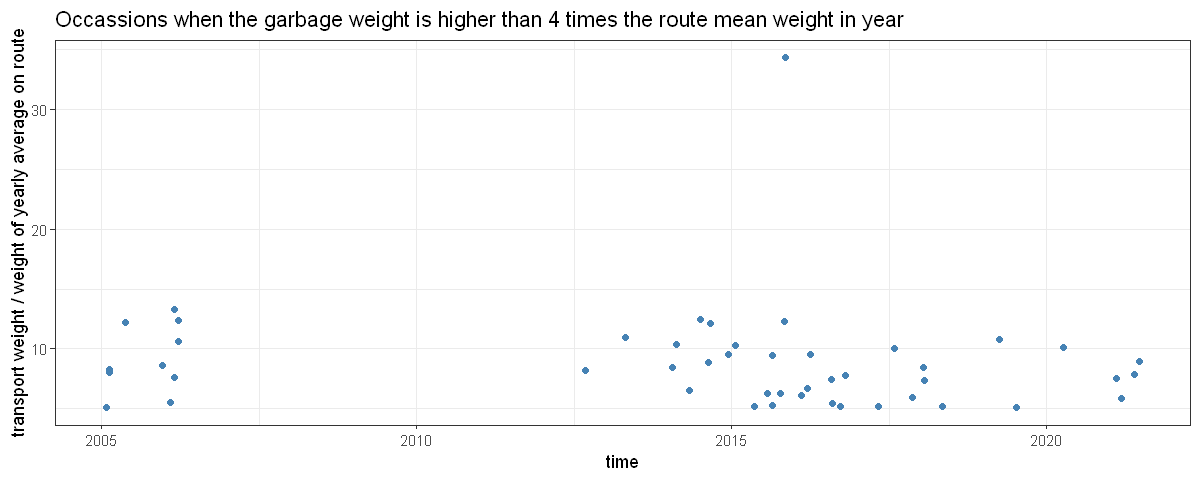

In [10]:
dt %>% filter (route_type == "GARBAGE COLLECTION") %>%
   filter (year %in% seq (2005,2021)) %>%
   group_by (route_number, year) %>%
   mutate (mean_ry = mean (load_weight, na.rm = TRUE)) %>%
   ungroup () %>%
   mutate (huge_factor = load_weight / mean_ry) %>%
   filter (huge_factor >= 5) %>%
   ggplot (aes(cr_date, huge_factor )) + geom_point(color = "steelblue") + 
   labs (title = "Occassions when the garbage weight is higher than 4 times the route mean weight in year", x = "time", y = "transport weight / weight of yearly average on route" ) + 
   theme_bw()

Probably many of these high values are faulty outliars, at least it is hard to believe that one single collection is "legitimately" 35 (!) times higher than the yearly average on that route.

**Feature 'load_id'**

Sounds to be an arbitrary ID, probably an information that is of liitle use for our purpose.

Still worth to check for duplicate load IDs, this also gives some impression about data quality.

Number of duplicate cases:

In [11]:
dt %>% 
  group_by(load_id) %>%
  filter (n()>1) %>%
  ungroup() %>%
  summarise (`Number of Duplicate load_ids` = n())

Number of Duplicate load_ids
91


Not many in numbers, but still disappointing.

Check the number of days between duplicates (sometimes triplicate)

In [12]:
dt %>% 
  group_by(load_id) %>%
  filter (n()>1) %>%
  mutate (diff = last(cr_date) - first(cr_date)) %>%
  select (diff) %>%
  ungroup() %>%
  summarise (`minimum difference in days` = min(diff), `maximum difference in days` = max(diff))

Adding missing grouping variables: `load_id`


minimum difference in days,maximum difference in days
0 days,0 days


Identical load IDs are on identical dates.

Conclusion: There are marginally low number of load_ids that are duplicated / triplicated. All such duplicates are on the same day. Likely some administrative error. Causes no disturbance in our analyzis due to the low number. 

**Feature 'load_time'**

In the data read section we managed to successfully convert all load_time values from string to 'POSIXct' type, which means that the formats were correct.

Also worth checking load_times in the data, and missing dates in the table.

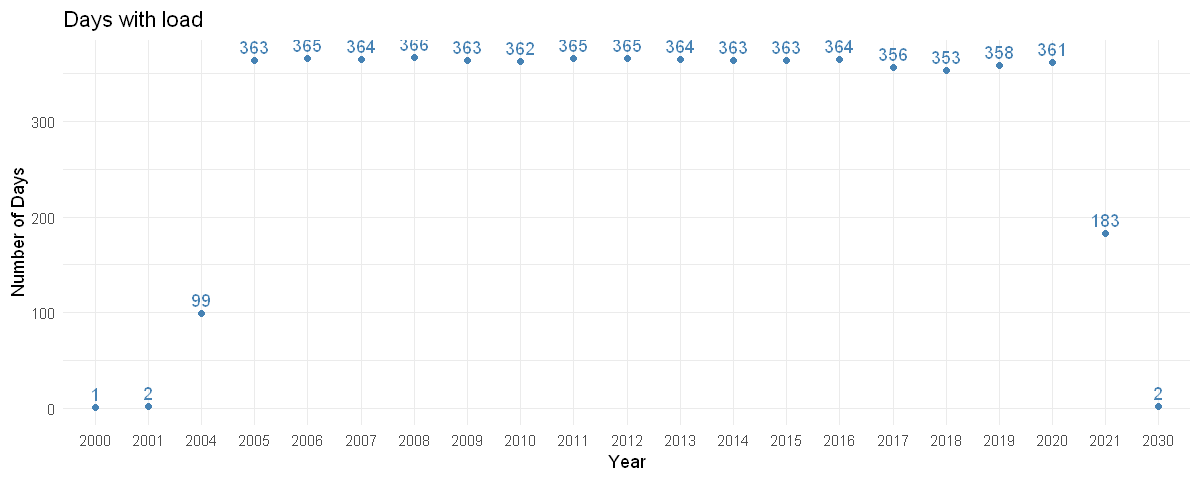

In [13]:
dt %>%
  group_by (cr_date) %>%
  summarise (load_per_day = n()) %>%
  group_by(year = format(cr_date, format = "%Y")) %>%
  summarise (report_per_year = n()) %>%
  ggplot (aes(year, report_per_year, group=1, label = report_per_year)) + 
  geom_point(color = "steelblue") + 
  geom_text(vjust = -0.5, color = "steelblue")+
  theme_minimal() + labs(title = "Days with load", x = "Year", y = "Number of Days")

Conclusion: 2004 and 2021 are incomplete years, while 2000, 2001 and 2030 are all likely errors in 'load_time'. In between, i.e. from 2005 and 2020. in all years we have reasonable number of days in our dataset. Probably not perfect, but reasonably OK. This means that our dataset is valid -at most- from year 2005 to year 2020.

**Feature 'report_date'**

One would expect from the name and from the data description that this is the date when the actual load was recorded in the system. Well, the sad news is that it is not. Let us just explore.

Just like 'load_time', 'record_date' is also fine when it comes to the format of this field: in the data reading section we managed to successfully convert all 'report_date' strings to Date type.

The remaining question is if data makes sense. For reporting dates it means that one can expect that 'report_date' occurs on the same day as the actual collection (i.e. date of 'load_time'), or maybe a few days later. Should not happen before the actual event, nor much later. Let is see if this hypothesis holds.

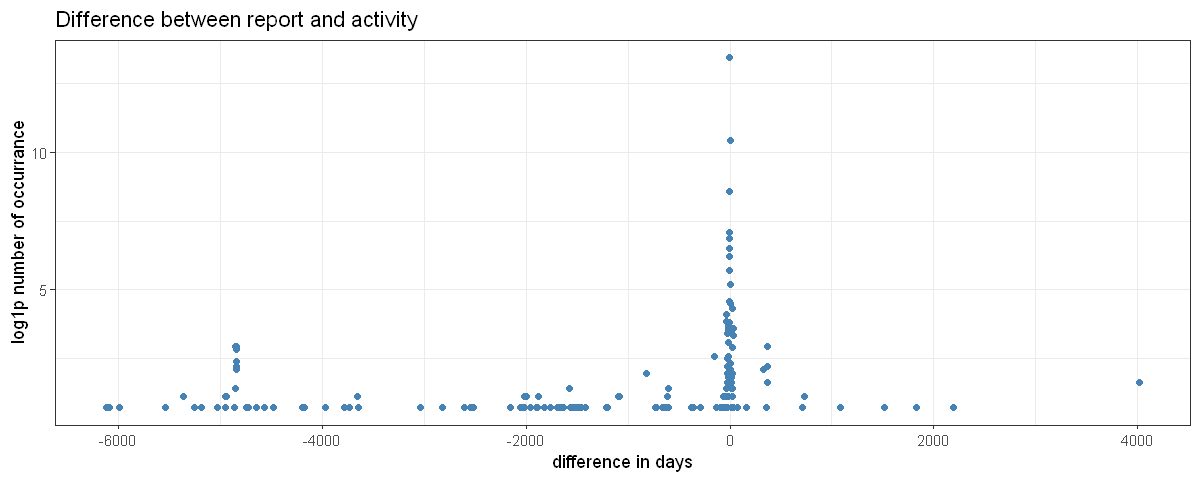

In [14]:
dt %>%
  mutate (report_delay_date = as.numeric(report_date - cr_date, unit = "days")) %>%
  group_by(report_delay_date) %>%
  summarise (pieces = n()) %>%
  ggplot (aes(report_delay_date, log1p(pieces))) + geom_point(color = "steelblue") + theme_bw() +
  labs (title = "Difference between report and activity", y="log1p number of occurrance", x = "difference in days")

Looks bad, there are quite a few datapoints where reporting -according to the data- occured 10 (even 20) years before the actual event, or is some cases much later. This is bad. 

The below chunk revealed that in ~90% of the cases 'report_date' is one day before the actual evend date, indicated by 'load_time. 

In [15]:
dt %>%
  mutate (report_delay_date = as.numeric(`report_date` - cr_date, unit = "days")) %>%
  filter (report_delay_date == -1) %>%
  summarise (n())

n()
696400


Conclusion: 'report_date' is likely not what it is said to be: in ~90% of the cases it is one day before the date of the actual load (indicated by 'load_time'), which would mean that the person recorded the event knew one day earlier details such as 'load_weight'. We may even assume that 'report_date' and 'load_time' are interchanged. This would at least explain the problem of knowing the 'load_weight' before the load, but other strange values (such as 'record_date' 20 years before the event) would stay as errors. 

Regarding this feature we have data quality concerns, but I think we can do nothing about it. We decided that besided noting this as a massive irreguality, we purely ignore 'record_date'. 

**Features load_type, route_type, dropoff_site, route_id**

'load_type' and 'route_type' seem to be very much similar, hard to understand the difference between them. 

'dropoff_site' is the actual place of deposit, gets some meaning when looking at their location on the map, and also when reading their specialization.

'route_number' identifies geographical collection areas. Categories in 'load_type' & 'route_type' have their own set of routes (e.g. there is a set of route names pertaning to "GARBAGE COLLECTIONS", another set of route names defined for "RECYCLING", etc.). 

Categories' presence in years:

The below reveals which route_type were relevant for which years, looking at the main categories only (in the Annex there is a table showing the same information for all categories by 'load_type', 'dropoff_site', 'route_type'.

`summarise()` has grouped output by 'route_type'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'route_type'. You can override using the `.groups` argument.


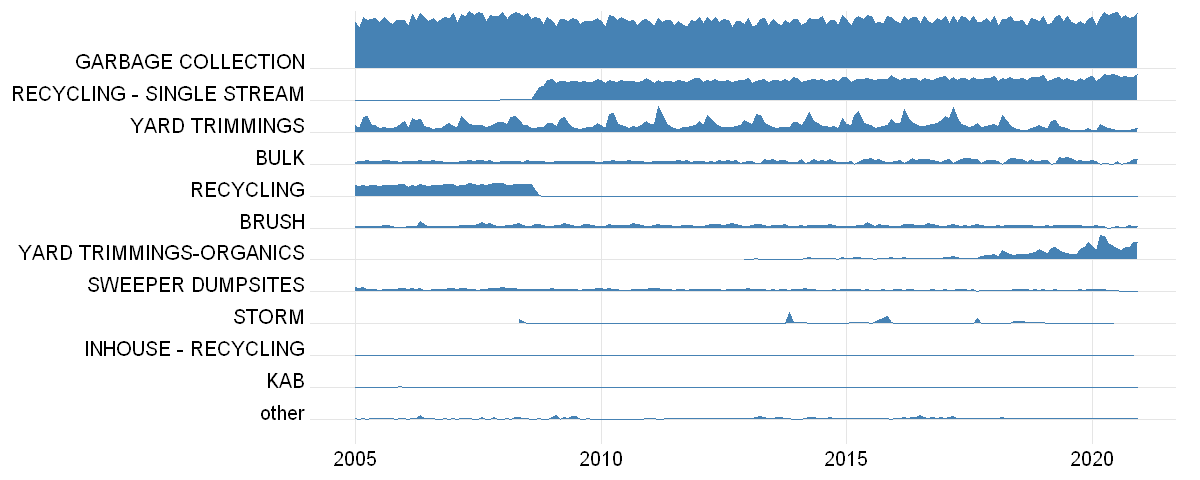

In [16]:
dt %>% 
  mutate(load_time = lubridate::floor_date(load_time, "month")) %>% 
  filter(between(lubridate::year(load_time), 2005, 2020)) %>% 


  group_by(route_type, load_time) %>%
  summarise(load_weight = sum(load_weight, na.rm = TRUE)) %>% 
  mutate(load_sum = sum(load_weight, na.rm = TRUE)) %>% 
  ungroup() %>% 
  mutate(route_type = forcats::fct_reorder(route_type, -load_sum),
         route_type = forcats::fct_lump(route_type, n = 11, w = load_sum, other_level = "other")) %>%
  
  group_by(route_type, load_time) %>%
  summarise(load_weight = sum(load_weight, na.rm = TRUE)) %>% 
  ungroup() %>% 
  mutate(route_type = forcats::fct_rev(route_type)) %>% 

  ggplot(aes(x = load_time, y = route_type, height = load_weight))  +
  ggridges::geom_density_ridges(stat = "identity", color = "steelblue", fill = "steelblue") +
  ggridges::theme_ridges() +
  theme(axis.title = element_blank())

Categories' share in the dataset:

Check the top categories along two measures: number of rounds (i.e. number of collections) and total load weight in the dataset. Reason for looking along these two dimensions is that ~10 of datapoints lacking weight information.

In [17]:
parameters <- c('load_type', 'route_number', 'dropoff_site', 'route_type')

top_n_by <- function (parameter, dt, eval_by, n) 
{
dt %>% 
  filter (year %in% seq (2005, 2020)) %>%
  group_by(Category = get(parameter)) %>% 
  summarise(rounds = n(), weight=sum(load_weight,na.rm=TRUE)) %>% 
  select (Category, eval_by) %>%
  mutate (share = round(get(eval_by) / sum (get(eval_by)),2)) %>%
  arrange (-get(eval_by)) %>% 
  dplyr::slice (1:n) %>%
  mutate (Category = paste0(parameter, " by ", eval_by, ": ", Category)) 
}


suppressMessages (
    do.call(rbind, (lapply (parameters, function(x) cbind (top_n_by (x, dt, "rounds", 4), top_n_by (x, dt, "weight", 4)))))
)

Category,rounds,share,Category,weight,share
load_type by rounds: GARBAGE COLLECTIONS,246361,0.35,load_type by weight: GARBAGE COLLECTIONS,4203852565,0.56
load_type by rounds: RECYCLING - SINGLE STREAM,140842,0.20,load_type by weight: RECYCLING - SINGLE STREAM,1395329072,0.19
load_type by rounds: SWEEPING,85635,0.12,load_type by weight: YARD TRIMMING,779717694,0.10
load_type by rounds: YARD TRIMMING,68630,0.10,load_type by weight: BULK,284823841,0.04
route_number by rounds: SDT01,10981,0.02,route_number by weight: DSS04,71843723,0.01
route_number by rounds: DSS04,6515,0.01,route_number by weight: PAM70,28616353,0.00
route_number by rounds: DA01,4134,0.01,route_number by weight: PAM01,28313760,0.00
route_number by rounds: BU13,2570,0.00,route_number by weight: PAM03,27590260,0.00
dropoff_site by rounds: TDS LANDFILL,310969,0.44,dropoff_site by weight: TDS LANDFILL,4687630297,0.63
dropoff_site by rounds: HORNSBY BEND,91760,0.13,dropoff_site by weight: HORNSBY BEND,853321707,0.11


*Note: share of all categories in 'load_type' and 'route_type' are presented in the Annex.*

Conclusion: in (the very similar) 'load_type' and 'route_type' features the top 3 categories take most of the rounds and weights, pretty much following Pareto's principle. Some top categories differ by rounds and by weight, as there were a number of sweeping activites (and some others) with no weight attached to it.

When looking at the waste by 'load_type' or 'route_type', it becomes apparent that 'GARBAGE COLLECTIONS', 'RECYCLING - SINGLE STREAMS', 'YARD TRIMMING' and 'BULK' makes up ~90% of total waste. By number of rounds 'SWEEPING' also features in top 3 in 'load_type'.

The ultimate winner of weight and round, 'GARBAGE COLLECTIONS' is consistently present from 2005 to 2020 in the dataset, while the second one, 'RECYCLING - SINGLE STREAM' is there from 2008 to 2020.

For the analysis not only the quantity is important but also the nature of the waste. We need to look at data having in mind the purpose of the exercise, i.e. reach Austin's zero waste goal by reducing waste and increasing recycling. From that perspective there are a number of 'load_type' and 'route_type' categories that play no role, e.g. "YARD TRIMMING", "BRUSH", etc. are all green, "STORM" etc. are things that are out of the municipality's control, "SWEEPING" is an activity that is to be done regardless of how selectively the population collects waste, etc.

Considering the type of waste and the quantity of waste, we found that "GARBAGE COLLECTION" and "RECYCLING - SINGLE STREAM" are the two categories (in both 'load_type' and 'route_type') that worth considering as dependent variables. The rest are not relevant for the purpose of the challange, not present in all years, or too little in quantity. 

In "GARBAGE COLLECTION" and "RECYCLING - SINGLE STREAM" categories we have pretty good presence of 'load_weight', we decided to use weight as measurement of waste, and not focus on the number of rounds.


***

**2.3. Trends**

The two plots below show the waste trends over the years:

- The first one plots the recycled and the no recycled 'route_type' categories over months

- The second plot focuses on recycled weight only, also showing trendline. Worth noting here the big jump in 2009, which might be attributable to measurement / data collection change rather than such rapid explosion of recycling.

`summarise()` has grouped output by 'recycled'. You can override using the `.groups` argument.


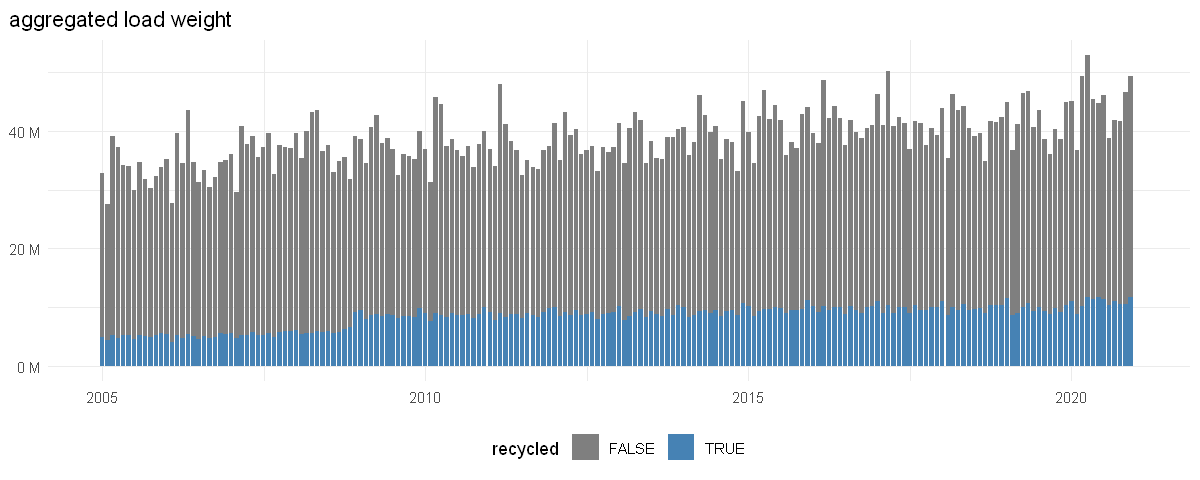

In [18]:
dt %>% 
  mutate(recycled = stringr::str_detect(route_type, "RECYC")) %>% 
  mutate(month = lubridate::floor_date(load_time, "month")) %>% 
  filter(year %in% seq (2005, 2020)) %>%
  group_by(recycled, month) %>% 
  summarise(load_weight = sum(load_weight, na.rm = TRUE)) %>% 
  ungroup() %>% 
  
  ggplot(aes(month, load_weight, fill = recycled)) +
  geom_col() +
  scale_y_continuous(labels = scales::label_number(suffix = " M", scale = 1e-6)) +
  scale_fill_manual(values = c("grey50", "steelblue")) +
  theme_minimal() +
  theme(axis.title = element_blank(), 
        plot.title.position = "plot",
        legend.position = "bottom") +
  labs(title = "aggregated load weight") 

`summarise()` has grouped output by 'recycled'. You can override using the `.groups` argument.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


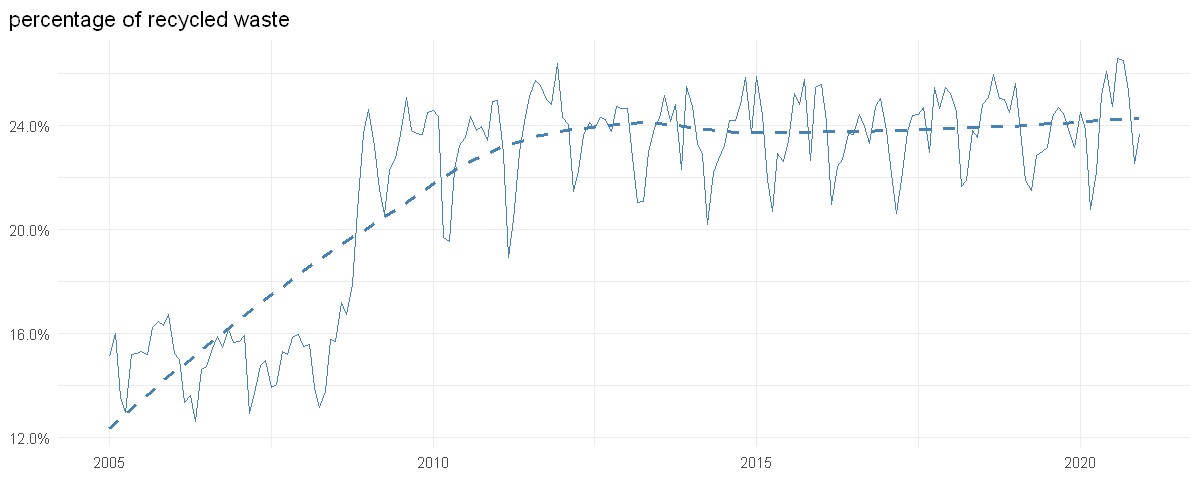

In [19]:
dt %>% 
  mutate(recycled = stringr::str_detect(route_type, "RECYC")) %>% 
  mutate(month = lubridate::floor_date(load_time, "month")) %>% 
  filter(between(lubridate::year(month), 2005, 2020)) %>%
  group_by(recycled, month) %>% 
  summarise(load_weight = sum(load_weight, na.rm = TRUE)) %>% 
  ungroup() %>% 
  
  pivot_wider(id_cols = month, names_from = recycled, values_from = load_weight) %>% 
  # janitor::clean_names() %>% 
  rename(false =`FALSE`, true = `TRUE`) %>% 
  replace_na(list(false = 0, true = 0)) %>% 
  mutate(sum = true + false, 
         recycled = true / sum) %>% 
  
  ggplot(aes(month, recycled)) +
  geom_line(color = "steelblue", size = 0.5) +
  geom_smooth(se = FALSE,  span = 0.8, color = "steelblue", linetype = "dashed") +
  scale_y_continuous(labels = scales::percent_format()) +
  theme_minimal() +
  theme(axis.title = element_blank(), 
        plot.title.position = "plot") + 
  labs(title = "percentage of recycled waste") 

***

**2.4. Per capita trends**

Manually adding Austin population data obtained from "Austin Area Population Histories and Forecasts" at
https://www.austintexas.gov/sites/default/files/files/Planning/Demographics/austin_forecast_2021_pubfix.pdf.

In [20]:
df_population <- tibble::tribble(
  ~year, ~total_population,
  1940L,       87930,
  1950L,      132459,
  1960L,      186545,
  1970L,      251808,
  1980L,      345890,
  1990L,      465622,
  2000L,      656562,
  2001L,      669693,
  2002L,      680899,
  2003L,      687708,
  2004L,      692102,
  2005L,      700407,
  2006L,      718912,
  2007L,      735088,
  2008L,      750525,
  2009L,      774037,
  2010L,      790390,
  2011L,      812025,
  2012L,      832326,
  2013L,      855215,
  2014L,      878733,
  2015L,      900701,
  2016L,      926426,
  2017L,      949587,
  2018L,      967629,
  2019L,      985504,
  2020L,     1006727,
  2021L,     1026833,
  2022L,     1041722,
  2023L,     1056827,
  2024L,     1070565,
  2025L,     1083948,
  2026L,     1097497,
  2030L,     1153409,
  2035L,     1227322,
  2040L,     1289928,
  2045L,     1339031,
  2050L,     1372843
)

Austin population trend, including forecast

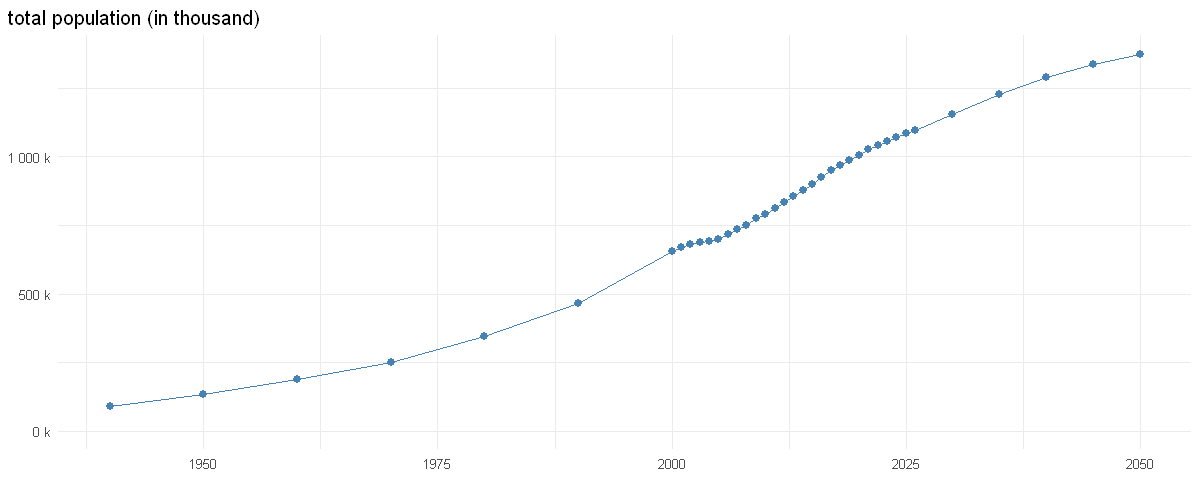

In [21]:
df_population %>% 
  ggplot(aes(year, total_population)) +
  geom_line(color = "steelblue", ) +
  geom_point(color = "steelblue", size = 2) +
  scale_y_continuous(labels = scales::label_number(suffix = " k", scale = 1e-3)) +
  coord_cartesian(ylim = c(0, NA)) +
  theme_minimal(base_size = 10) +
  theme(axis.title = element_blank(), 
        plot.title.position = "plot") +
  labs(title = "total population (in thousand)") 

Waste [kg] per capita trend

`summarise()` has grouped output by 'recycled'. You can override using the `.groups` argument.
Joining, by = "year"


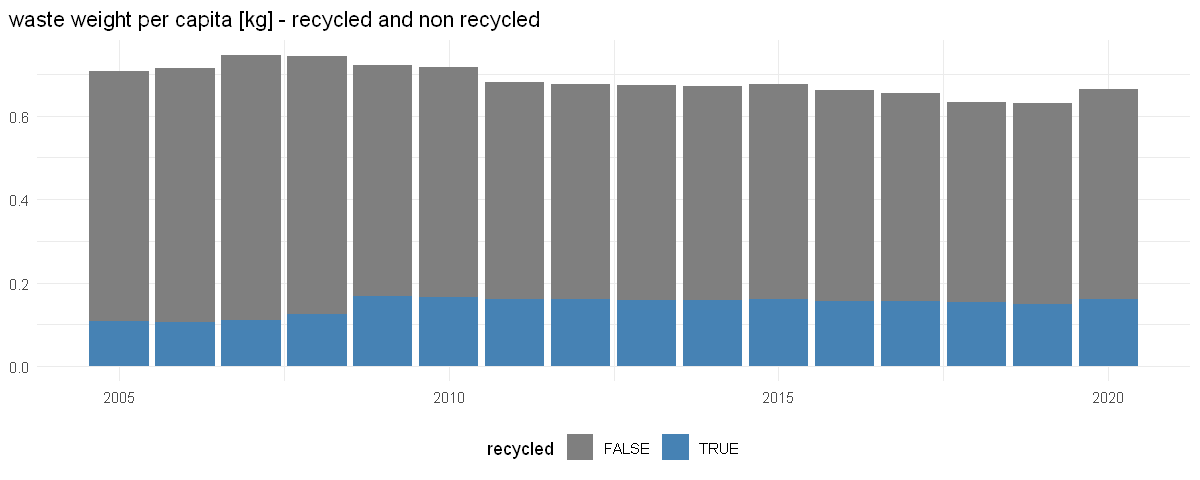

In [22]:
df_waste_capita <- dt %>% 
  mutate(recycled = stringr::str_detect(load_type, "RECYC")) %>% 
  mutate(year = lubridate::year(load_time)) %>% 
  filter(between(year, 2005, 2020)) %>%
  group_by(recycled, year) %>% 
  summarise(load_weight = sum(load_weight, na.rm = TRUE)) %>% 
  ungroup() %>% 
  

  left_join(df_population %>% select(year, total_population)) %>% 
  mutate(waste_capita = load_weight / total_population * 0.45359237,
         waste_capita = waste_capita / ifelse(lubridate::leap_year(year), 366, 365))


df_waste_capita %>% 
  # mutate(year = make_datetime(year = year)) %>% 
  ggplot(aes(year, waste_capita, fill = recycled)) +
  geom_col() +
  scale_fill_manual(values = c("grey50", "steelblue")) +
  theme_minimal() +
  theme(axis.title = element_blank(), 
        plot.title.position = "plot",
        legend.position = "bottom") +
  labs(title = "waste weight per capita [kg] - recycled and non recycled") 

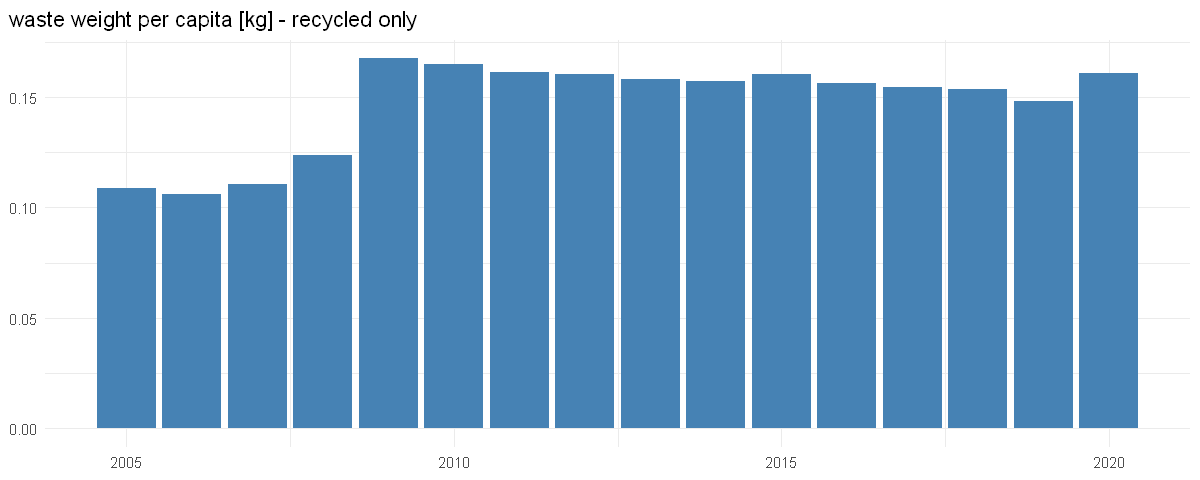

In [23]:
df_waste_capita %>% 
  # mutate(year = make_datetime(year = year)) %>% 
  filter(recycled) %>% 
  ggplot(aes(year, waste_capita)) +
  geom_col(fill = "steelblue") +
  theme_minimal() +
  theme(axis.title = element_blank(), 
        plot.title.position = "plot") +
  labs(title = "waste weight per capita [kg] - recycled only") 

The per capita trends show two things:

- Population is on the rise, and this trend is expected to continue

- Per capita "GARBAGE COLLECTION" and "RECYCLING - SINGLE STREAM" both seem to very shallowly decrease.

The problem is that the population increase forecast is steeper than the waste production per capita decreasing trend.

***
**2.5. Retail consumption trend**

Garbage volume may be influenced by general retail consumption. Detailed analysis could be carried out regarding how different product categories (food, clothing, electronics, furniture, etc.) influence garbage volumes, but the big picture may suffice to start with.
Consumption level trend is approximated by using the tax data on retail consumption, while the effect of consumer price index change is eliminated. Data comes from Key [Economic Indicators on Texas aggregation level](https://data.texas.gov/dataset/Key-Economic-Indicators/karz-jr5v).

In [24]:
url_socrata <- "https://data.texas.gov/resource/karz-jr5v.json"

df_in <- read.socrata(url_socrata, 
                        app_token = APPToken,
                        email = "shinypandaswdl@gmail.com",
                        password = "Wdl2022?")

df_cpi <- df_in %>% 
  mutate_if(is.character,as.numeric) %>% 
  mutate(year_month=as.Date(paste(as.character(month), "/01/", as.character(year), sep = ""), format = "%m/%d/%Y")) %>% 
  select(year_month, cpi_tx, tax_collections_retail_tx) %>% 
  mutate(retail_comparable=tax_collections_retail_tx / cpi_tx * 100)

df_cpi_year <- df_cpi %>% 
  group_by(year=lubridate::floor_date(year_month, unit="year")) %>% 
  summarise(retail_comparable = mean(retail_comparable))


`geom_smooth()` using method = 'loess' and formula 'y ~ x'


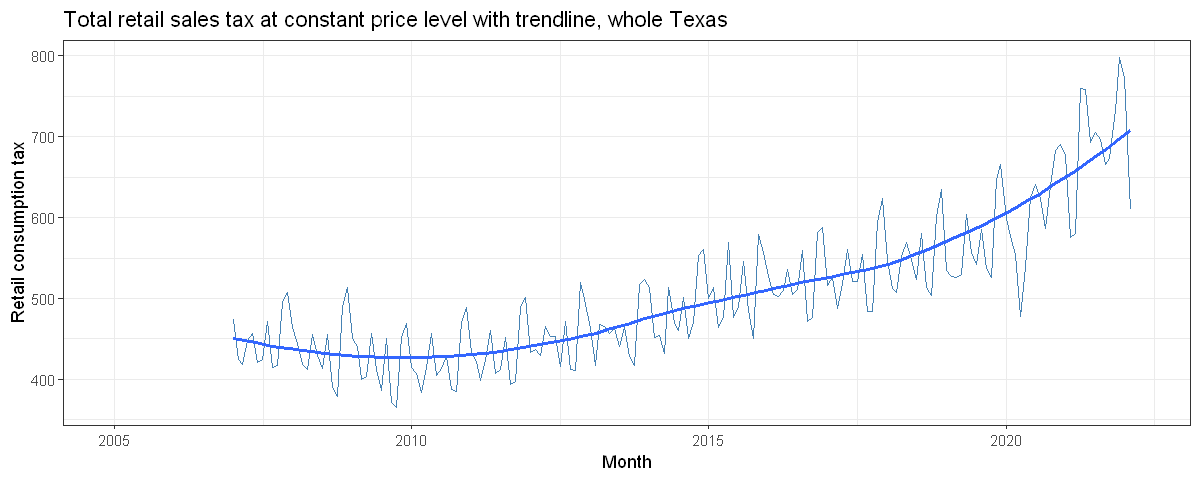

In [25]:
ggplot(df_cpi, aes(year_month, retail_comparable)) + 
  geom_line(color = "steelblue") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  geom_smooth(se = FALSE) + 
  labs(title = "Total retail sales tax at constant price level with trendline, whole Texas", x = "Month", y = "Retail consumption tax") + 
    theme_bw()


***
**2.6. Conclusions**

Summarizing the most important findings from above:

- Certain findings, such as weird 'record_date' - 'load_time' relations, duplicate 'load_id' values, ambiguous relation between 'load_type' and 'route_type', etc. raises concern regarding data quality (and yet more to come in the map data section). 
We decided to use 'route_type' later in the analysis and ignore 'load_type', mostly because this seems to slightly more consistent to the relevant garbage-route map data.

- Data from 2008 to 2020 seem to be "stable" and will set the available scop of any analysis in time. (*Note: While we have data from 2005, from 2005 to 2008 recycling related data might be instable, as shown above**)

- The dependent variables will be 'load_weight' measured on 'GARBAGE COLLECTIONS' 'route_type' categories.


***

### 3. BOUNDARIES_garbage_collection_routes dataset 

**Chapter summary**

First we read the 'BOUNDARIES_garbage_collection_routes' map dataset. There are currently 184 garbage collection routes. Garbage collection is once a week pickup Monday thru Friday. The holes inside the garbage collection route boundaries represent no service areas. This dataset contains these garbage collection routes together with their geographical representations (polygons), their service days and their old route name.

We did an Exporatory Data Analysis with the below key observations:

- All garbage routes in this dataset are included in the waste master dataset, and all of those have 'GARBAGE COLLECTION' 'route_type' there (which shows consistency). However, there are more garbage routes in the master dataset that are not included in this map data.

- The polygon areas seem to be valid, i.e. there are practically no overlapping route polygons.

- We had big trouble understanding the "old route" column. The name ('rt_old') suggested that possibly this is the old name of the corresponding route ('garb_rt' in the same row), but we found that this is not the case. Several routes and their corresponding old route pairs existed at the same time in the master data, and also in several cases they represented two distinct geographical areas. We concluded that either this field represents something else than old name of the same route, or this field is erroneous ('route area ambiguity problem'). In our analysis we decided to ignore this field, and use the route name in this dataset. The purpose we use route name for is purely to get the geographical representation of the routes in the master waste dataset. 

**3.1. Read the 'BOUNDARIES_garbage_collection_routes' dataset**

In [26]:
library(sf)
library(leaflet)
url_garb_geojson <- "https://data.austintexas.gov/api/geospatial/azhh-4hg8?method=export&format=GeoJSON"
garb_mapdata <- sf::st_read (url_garb_geojson)

Linking to GEOS 3.9.0, GDAL 3.2.1, PROJ 7.2.1


Reading layer `OGRGeoJSON' from data source `https://data.austintexas.gov/api/geospatial/azhh-4hg8?method=export&format=GeoJSON' using driver `GeoJSON'
Simple feature collection with 184 features and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -97.92948 ymin: 30.09855 xmax: -97.57229 ymax: 30.51662
Geodetic CRS:  WGS 84


In [27]:
str(garb_mapdata)

Classes 'sf' and 'data.frame':	184 obs. of  8 variables:
 $ rt_old   : Factor w/ 91 levels "NO ROUTE","PAF05",..: NA 37 NA 18 NA 73 29 48 NA NA ...
 $ garb_day : Factor w/ 5 levels "Friday","Monday",..: 3 2 2 3 5 3 2 4 2 2 ...
 $ landfill : Factor w/ 1 level "TDS": 1 1 1 1 1 1 1 1 1 1 ...
 $ garb_rt  : Factor w/ 184 levels "PAF01","PAF02",..: 48 60 68 32 121 146 73 93 50 51 ...
 $ super_num: Factor w/ 6 levels "170","400","500",..: 5 3 4 3 4 NA 5 4 NA NA ...
 $ op_type  : Factor w/ 2 levels "Auto","Semi": 1 1 1 1 1 2 1 1 1 1 ...
 $ garb_sup : Factor w/ 9 levels "Carnline","Castillo",..: 4 2 1 2 1 3 4 1 5 5 ...
 $ geometry :sfc_MULTIPOLYGON of length 184; first list element: List of 1
  ..$ :List of 1
  .. ..$ : num [1:124, 1:2] -97.7 -97.7 -97.7 -97.7 -97.7 ...
  ..- attr(*, "class")= chr  "XY" "MULTIPOLYGON" "sfg"
 - attr(*, "sf_column")= chr "geometry"
 - attr(*, "agr")= Factor w/ 3 levels "constant","aggregate",..: NA NA NA NA NA NA NA
  ..- attr(*, "names")= chr  "rt_old" "garb_day

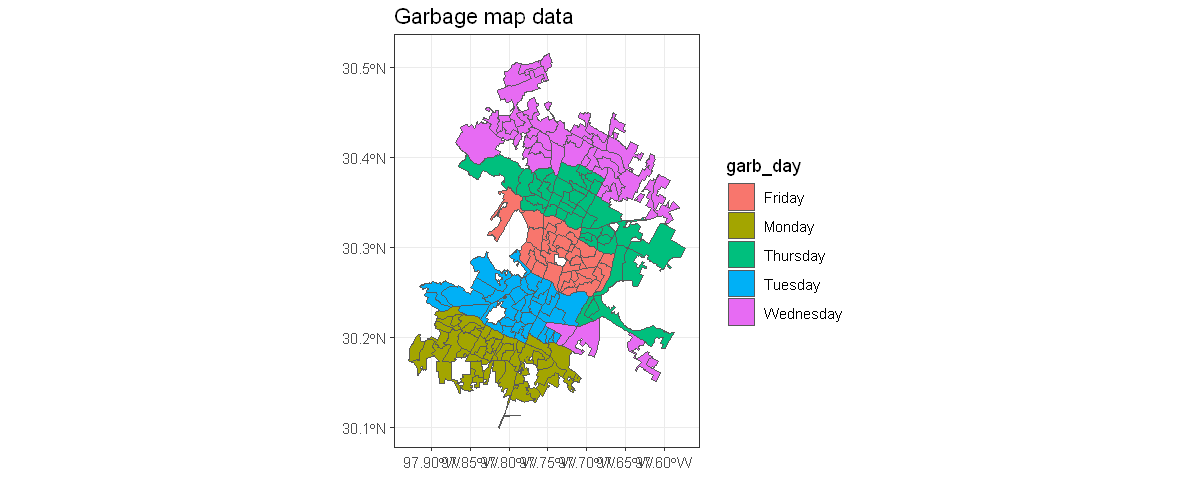

In [28]:
# This cell replaces the cell below leaflet cell due to jupyter -> html leaflet rendering probleem

ggplot() + geom_sf (data = garb_mapdata, aes(fill = garb_day)) + theme_bw() + labs(title = "Garbage map data")

In [29]:
# cell disabled due to jupyetr html rendering problem. OK in notebook but not when rendered to html. Replaced w. geom_sf above

#pal <- colorFactor(
#  palette = "inferno",
#  domain = NULL)
#
#leaflet(data = garb_mapdata) %>%
#     addProviderTiles(providers$OpenStreetMap.DE) %>%   # For some reason this was needed in order to add map in Jupyter
#     addTiles() %>%   
#     addPolygons(fillColor = ~pal(garb_day), fillOpacity = 0.8, weight = 1) 

Looks OK, the few white spots are explained in the dataset notes (these are "no service" areas).

***

**3.2. Exploratory Data Analysis - BOUNDARIES_garbage_collection_routes dataset**

Probably useful information in this data:

- 'garb_rt': examination tells that this is the garbage collection route, corresponding to 'route_number' in the waste dataset.

- 'geometry': polygon informationm for 'garb_rt'

- 'rt_old': the name suggests that there has been route name changes, and 'rt_old' is the old route name of 'garb_rt'.

- 'garb_day': the day of the week when waste from the particular route is collected.


First we are about to check missing values, then going through each variable and make decisions about usability in this exercise.

**Checking missing fields** 

In [30]:
garb_mapdata %>% filter (is.na(garb_rt) | is.na(geometry)) %>% nrow()

[1] 0

Conclusion: No important data is missing. There are several 'NA's in the 'rt_old' column, but we consider it legitimate, i.e. meaning that the particular 'garb_rt' route name has not been changed.

**Feature garb_rt**

This should be a valid route name, there are two consistency checks made here:

- Checking for duplicates

- Checking if we have route here that is not in the waste dataset

- Checking the 'route_type' values for these routes in the master waste database

- Comparing the number of routes in this database and the number of routes in the relevant 'route_types' in the waste master data

Checking for duplicate 'grab_rt' names:

In [31]:
garb_mapdata %>% st_drop_geometry() %>%
   group_by (garb_rt) %>%
   summarise (num = n()) %>%
   group_by (duplicates = num>1) %>%
   summarise (num = n())

duplicates,num
FALSE,184


Checking if we have route here that is not in the waste dataset

In [32]:
garb_mapdata %>% st_drop_geometry() %>%
   left_join (dt, by = c("garb_rt" = "route_number")) %>%
   filter (is.na(load_type)) %>%
   nrow()

[1] 0

Checking the 'route_type' values for these routes

In [33]:
garb_mapdata %>% st_drop_geometry() %>%
   left_join (dt, by = c("garb_rt" = "route_number")) %>%
   group_by (route_type) %>%
   summarise (num = n()) %>%
   arrange (-num)

route_type,num
GARBAGE COLLECTION,171344


Checking the number of routes in the master waste dataset for the relevant 'route_type'

In [34]:
dt %>% filter (route_type == "GARBAGE COLLECTION") %>% distinct (route_number) %>% nrow()

[1] 436

Conclusion: no duplicates, no route here that is not part of the master waste data.
All routes in the map belong to "GARBAGE COLLECTION" 'route_type'. 

*Note: when doing the above sanity check on 'load_type', the result is also pretty clear, though not 100%. In the latter case there are a few cases when the routes in the garbage-route map also recorded other than "GARBAGE COLLECTIONS" 'load_type'. This is why we decided to use 'route_type' in our analysis and not 'load_type'.*

In the waste master table there are more routes associated with "GARBAGE COLLECTIONS" 'route_type' than what we have in the garbage-route map data. Even if we include 'rt_old' (assumed to be the old names of the garbage routes), we still have less number of routes recorded in the map database than in the waste dataset. Again, not a nice indication about data quality.

**Feature geometry**

This is supposed to be the polygon info associated to the 'garb_rt' routes. In the data load section they visually looked OK. 

There is one more thing we are going to check here: are there overlapping polygons (i.e. geographical areas that belong to different routes).

In [35]:
calc_overlap_mx <- function (poli_sf_1, poli_sf_2)
# calculates overlapping areas btw. poligons in poli_sf_1 and poli_sf_2  
{
  intersects <- st_intersects (poli_sf_1, poli_sf_2, sparse = FALSE)
  x <- seq (1, dim (intersects)[1])
  y <- seq (1, dim (intersects)[2])
  
  suppressMessages(overlap_v <- lapply (x, 
                       function(x) lapply (y, 
                                           function (y) ifelse (intersects[x,y] ==0,
                                                                0,
                                                                st_area(st_intersection(poli_sf_1[x,], 
                                                                                        poli_sf_2[y,]))))))
  
  overlap_m <- matrix(as.integer(unlist(overlap_v)), nrow = dim(intersects)[2])
  return (overlap_m)
  
}

In [36]:
# create overlap matrix
overlap_mx <- calc_overlap_mx (garb_mapdata, garb_mapdata)

# calculate sum of absolute error, which is the ratio btw route own area and all areas overlapped by route - 1
sum(abs(    diag(overlap_mx) / colSums(overlap_mx)     - 1))

although coordinates are longitude/latitude, st_intersects assumes that they are planar


[1] 0.003285285

The above list shows negligeable overlaps in the polygons (where the ratio of a polygon area vs. all overlapping areas -including overlap with self) is below 1). Therefore this confirms the visual observation made after map data reading: polygons in the dataset are not overlapping.

**Feature old_rt**

The name would imply that along the years routes have been renamed, and 'rt_old' is the old name of the corresponding 'garb_rt' route. Well, this is unfortunately not the case. Absolutely not.

Checking for duplicates. 

Bearing in mind that 'garb_rt's are unique (see above), duplicate 'rt_old' would mean a route split over time: one 'rt_old' is split and becomes two 'garb_rt's. The below check show that we are OK in this front, there are no such splits (we have NAs, but this is fine, we assume that it means that in such case there was no predecessor of that 'garb_rt' route).

In [37]:
garb_mapdata %>% st_drop_geometry () %>%
   group_by (rt_old) %>%
   summarise (num = n()) %>%
   filter (num > 1)

rt_old,num
NA,93


Checking if same name appears as both old and new route (i.e. intersection of both 'garb_rt' and 'rt_old'). This probably would mean that a route has been renamed more than once.

In [38]:
length (intersect (garb_mapdata$rt_old, garb_mapdata$garb_rt)  )

[1] 52

52 such cases: "Austin, we have a problem".

We saw above that every row represents a unique polygon. This means that if a route name appears twice in the dataset, then they can represent the same polygon only if they appear in the same row, i.e. 'rt_old' and 'garb_rt' must be identical.

The below chunk shows that unfortunately these 'rt_old' - 'garb_rt' pairs contain different 'rt_old' - 'garb_rt' route names.

In [39]:
data.frame(intersect (garb_mapdata$rt_old, garb_mapdata$garb_rt)) %>%
  rename_(rt_old = names(.)[1]) %>%
  left_join(garb_mapdata) %>%
  select (rt_old, garb_rt) %>%
  mutate (samename = ifelse (as.character(rt_old) == as.character(garb_rt), "Same Name", "Different old and new route name") ) %>%
  group_by (samename) %>%
  summarise (n = n())


Joining, by = "rt_old"


samename,n
Different old and new route name,52


As every polygon is unique, if a route is among both old and new route names in different rows (i.e. not renamed to itself), then this route would then belong to different areas (one area as old route, and another one as new route). 

<br> 

Graphically representing such scenario over time:


Polygon_1:     &emsp;        Route_A  &emsp;     T  &emsp;     Route_B  
Polygon_2:     &emsp;        Route_C  &emsp;     T  &emsp;     Route_A

Time              ------------------------------------------------>

<br> 

Here Route_A is a route that appears both as old and as new route name. 
If we see Route_A in the master waste dataset, then 

- If the 'load_time' is before T time, then it represents Polygon_1.

- While if Route_A is seen in the dataset after T, then it represents Polygon_2. 

The only problem is that we need to know the time of renaming, T, in order to decide which area Route_A represents at the time of observation. And unfortunately renaming date/time is not given in any dataset.

We were hoping that maybe all route renaming’s happened at once and at the same time. If this were true, then this T time would be the date of the last appearance of route names that were phased out completely.

We tested this hypothesis, i.e. checked the last appearance of the phased out routes (i.e. those 'old_rt' (old) routes that only appear as old routes and not as new ones). As the below code shows, unfortunately our hypothesis failed: there is no one single date of all such renamings. This implies that in the above example if we see Route_A in the dataset, we do not know whether it was before T or after T, with other words if this is Polygon_1 or Polygon_2. This 'route area ambiguity' is clearly a problem if we want to do any analysis on final granularity than the whole of Austin.

Joining, by = "route_number"


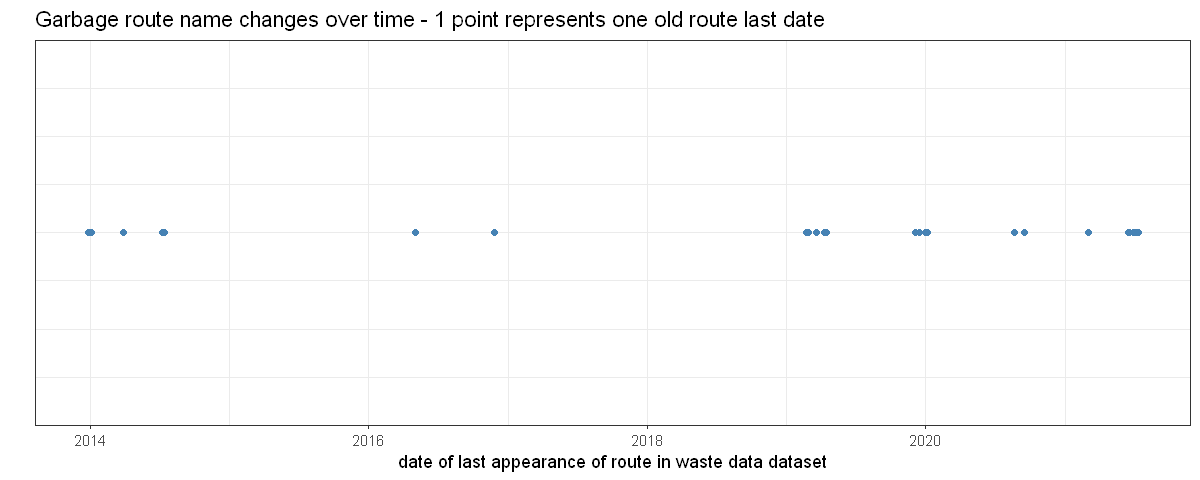

In [40]:
data.frame(setdiff (setdiff (garb_mapdata$rt_old, garb_mapdata$garb_rt), c(NA, "NO ROUTE"))) %>%
  # name 1st column
  rename_(route_number = names(.)[1]) %>%
  left_join (dt) %>%
  group_by (route_number) %>%
  summarise (last_date = max(cr_date)) %>%
  ggplot (aes (x = last_date, y = 1, label = route_number)) + geom_point(color = "steelblue") + theme_bw() + 
  labs (title = "Garbage route name changes over time - 1 point represents one old route last date", 
        x = "date of last appearance of route in waste data dataset", y = "") +
  theme (axis.ticks.y = element_blank(), axis.text.y = element_blank())

Some more detailed analysis are included in the Annex section, which further strengthens the below conclusion. We thought that the depth of those analysis justifies putting them in the Annex rather than in this main section. Yet, these helped us to be confident when drawing the following conclusions.

**Conclusion**

Unfortunately the interpretation of 'rt_old' remained unclear to us. One would believe that 'rt_old' is the old name of the corresponding 'garb_rt'. However, often times the same route name appears at two different geographical areas (i.e. in the map database in different rows once as old route, once as new route, meaning that these represented different geographical areas over time). 

It has a consequence on how we proceeded in our analysis: we basically ignored 'rt_old' and only looked at 'garb_rt'.

***

### 4. BOUNDARIES_recycle_collection_routes dataset

**Chapter Summary**

This chapter is very much similar to the previous one, except that here we read and explored the 'BOUNDARIES_recycle_collection_routes' map dataset. There are currently 190 recycle collection routes. Recycle collection is every other week pickup Monday thru Friday represented as either A or B week pickup. The holes inside the recycle collection route boundaries represent no service areas. This dataset contains these recycle collection routes together with their geographical representations (polygons), their service days and their old route name.

The key findings of our EDA are same as our findings related to the garbage map data, but here we found some more irregularities:

- We are having the same issues (old - new routes overlap in time and different geographical areas) and lack of understanding regarding "old route" as in the garbage map data case.

- Even worse here is that a few times the same "old route" name appears in multiple rows, which may indicate that this "old route" has been split to multiple routes, or that the same name has been used several times over the years.

- There are some routes in the waste master dataset that are not part of this map data, just as was the case with the garbage routes.

- However, here we see the opposite, too. There are some recycling routes in this map dataset that never appeared in the master waste table.

In our conclusion these are signals of severe inconsistency in data. The way we treated was the same as we did in the garbage map data: ignored old route names and used route names only. Still, these facts above are worrisome concerning the result.

**4.1. Read the 'BOUNDARIES_recycle_collection_routes' dataset**

In [41]:
url_rec_geojson <- "https://data.austintexas.gov/api/geospatial/7tin-f8k2?method=export&format=GeoJSON"
rec_mapdata <- sf::st_read (url_rec_geojson)

Reading layer `OGRGeoJSON' from data source `https://data.austintexas.gov/api/geospatial/7tin-f8k2?method=export&format=GeoJSON' using driver `GeoJSON'
Simple feature collection with 209 features and 15 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -97.92948 ymin: 30.09855 xmax: -97.56052 ymax: 30.51663
Geodetic CRS:  WGS 84


In [42]:
str(rec_mapdata)

Classes 'sf' and 'data.frame':	209 obs. of  16 variables:
 $ created_by     : Factor w/ 2 levels "Ketten","Zimmerman": 2 2 2 2 2 2 2 2 2 2 ...
 $ shape_area     : Factor w/ 209 levels "10138292.75",..: 172 83 1 121 119 132 191 167 198 166 ...
 $ area_supervisor: Factor w/ 6 levels "Aaron Jaramillo",..: 6 4 6 6 3 6 6 2 2 2 ...
 $ created_date   : POSIXct, format: "2007-10-01 02:00:00" "2007-10-01 02:00:00" ...
 $ objectid_1     : Factor w/ 209 levels "1","10","100",..: 54 185 147 30 68 161 63 41 27 15 ...
 $ old_route      : Factor w/ 190 levels "RFAS33","RFAS34",..: 68 65 124 12 79 9 128 111 163 167 ...
 $ objectid       : Factor w/ 184 levels "1","10","100",..: 75 179 139 48 74 154 84 59 45 33 ...
 $ route_name     : Factor w/ 209 levels "RFAS33","RFAS34",..: 67 75 132 8 83 9 133 114 179 180 ...
 $ service_week   : Factor w/ 2 levels "A","B": 2 2 1 1 1 1 1 2 1 1 ...
 $ shape_length   : Factor w/ 209 levels "103438.591008838",..: 143 61 6 109 90 140 161 195 197 138 ...
 $ modified_by  

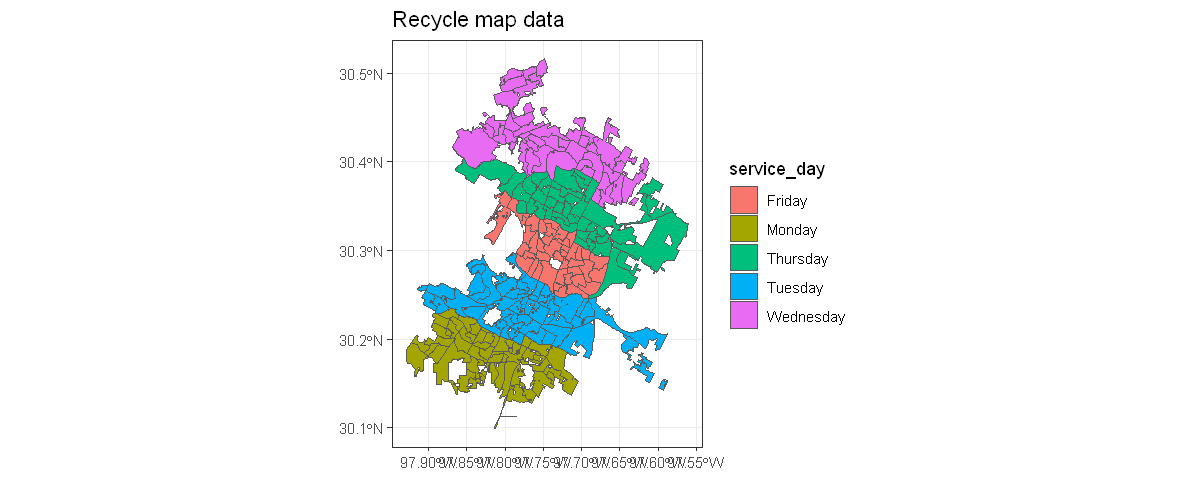

In [43]:
# This cell replaces the cell below leaflet cell due to jupyter -> html leaflet rendering probleem

ggplot () + geom_sf (data = rec_mapdata, aes(fill = service_day)) + theme_bw() + labs(title = "Recycle map data")

In [44]:
# cell disabled due to jupyetr html rendering problem. OK in notebook but not when rendered to html. Replaced w. geom_sf above

#leaflet(data = rec_mapdata) %>%
#     addProviderTiles(providers$OpenStreetMap.DE) %>%   # For some reason this was needed in order to add map in Jupyter
#     addTiles() %>%   
#     addPolygons(fillColor = ~pal(service_day), fillOpacity = 0.8, weight = 1) 

**4.2. Exploratory Data Analysis - BOUNDARIES_recycle_collection_routes dataset**

There is a lot of data here, but more closely looking at the basically what is of interest here are pretty much the same looked at in the garbage-route map. Basically the same analysis is repeated here, but sparing the explanations just including code and conclusions.

For this reason the reader may prefer to skip this dry, code-heavy section and jump right to the conclusions.

**Checking missing fields** 

In [45]:
rec_mapdata %>% filter (is.na(route_name) | is.na(geometry)) %>% nrow()

[1] 0

**Feature route_name**

Checking for duplicate 'grab_rt' names:

In [46]:
rec_mapdata %>% st_drop_geometry() %>%
   group_by (route_name) %>%
   summarise (num = n()) %>%
   group_by (duplicates = num>1) %>%
   summarise (num = n())

duplicates,num
FALSE,209


Checking if we have route here that is not in the waste dataset

In [47]:
rec_mapdata %>% st_drop_geometry() %>%
   left_join (dt, by = c("route_name" = "route_number")) %>%
   filter (is.na(load_type)) %>%
   nrow()

[1] 35

As the master waste dataset has no NA in load types, we can conclude that we have 35 route names in this map dataset that are not in the original master waste data. Again, indication of imperfect data quality.

Checking the 'route_type' values for these routes

In [48]:
rec_mapdata %>% st_drop_geometry() %>%
   left_join (dt, by = c("route_name" = "route_number")) %>%
   group_by (route_type) %>%
   summarise (num = n()) %>%
   arrange (-num)

route_type,num
RECYCLING - SINGLE STREAM,89968
NA,35


Looks clear, except we here again see those 35 routes that exist in this map dataset but not in the waste dataset.

As just seem, there are 35 routes among the 'route_name's of this dataset that are not part of the master dataset. On the other hand, there are 37 "RECYCLING - SINGLE STREAM" routes with the opposite (i.e. included in the master dataset but not here), see below:

In [49]:
dt %>% filter (route_type == "RECYCLING - SINGLE STREAM") %>% distinct (route_number) %>% nrow() - 
length(union(rec_mapdata$route_name, rec_mapdata$old_route))

[1] 37

**Feature geometry**

Looking at possible overlapping route areas.

In [50]:
# create overlap matrix
overlap_mx <- calc_overlap_mx (rec_mapdata, rec_mapdata)

# calculate sum of absolute error, which is the ratio btw route own area and all areas overlapped by route 
sum(abs(   diag(overlap_mx) / colSums(overlap_mx)     -1))

although coordinates are longitude/latitude, st_intersects assumes that they are planar


[1] 0.002484615

**Feature old_route**

Checking for duplicates

In [51]:
rec_mapdata %>% st_drop_geometry () %>%
   group_by (old_route) %>%
   summarise (num = n()) %>%
   filter (num > 1) %>%
   t()

old_route,RFAU20,RFBS41,RHAU20,RHBS43,RMAS34,RMBS35,RMBS41,RTBU13,RWAS34,RWAU21,RWAU24,RWBS33,RWBS35,RWBS43,RWBU22,RWBU23
num,2,2,2,2,2,2,2,3,3,3,2,2,2,2,2,2


This suggests that we had root splits, in worst case splitted parts re-combined.

Checking if same name appears as both old and new route

In [52]:
length(intersect (rec_mapdata$old_route, rec_mapdata$route_name))

[1] 127

Oh, please NO! This is a lot!

 Checking if 'old_route' - 'route_name' pairs contain different route names or the same

In [53]:
data.frame(intersect (rec_mapdata$old_route, rec_mapdata$route_name)) %>%
  rename_(old_route = names(.)[1]) %>%
  left_join(rec_mapdata) %>%
  select (old_route, route_name) %>%
  mutate (samename = ifelse (as.character(old_route) == as.character(route_name), "Same Name", "Different Name") ) %>%
  group_by (samename) %>%
  summarise (n = n())

Joining, by = "old_route"


samename,n
Different Name,65
Same Name,79


In 65 cases this is renaming as seen in the garbage route dataset, while in 79 cases the name is kept. Bearing in mind that above we saw that routes might have been split and combined, it one could imagine such renaming is a merger of routes. 

Route name changes over time - based on routes first and last load_time in the master waste dataset

Joining, by = "route_number"


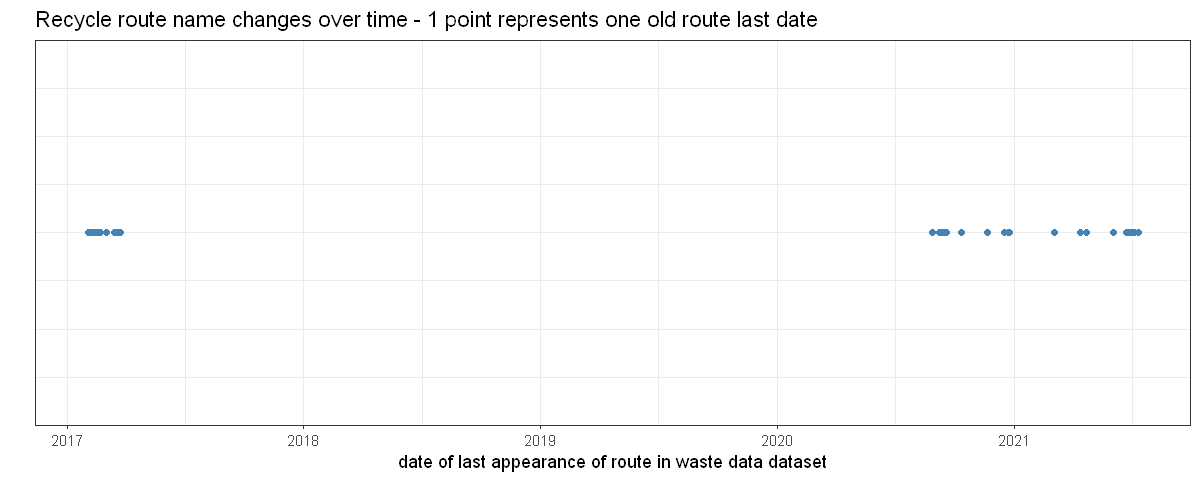

In [54]:
data.frame(setdiff (setdiff (rec_mapdata$old_route, rec_mapdata$route_name), c(NA, "NO ROUTE"))) %>%
  # name 1st column
  rename_(route_number = names(.)[1]) %>%
  left_join (dt) %>%
  group_by (route_number) %>%
  summarise (last_date = max(cr_date)) %>%
  ggplot (aes (x = last_date, y = 1, label = route_number)) + geom_point(color = "steelblue") + theme_bw() + 
  labs (title = "Recycle route name changes over time - 1 point represents one old route last date", 
        x = "date of last appearance of route in waste data dataset", y = "") +
  theme (axis.ticks.y = element_blank(), axis.text.y = element_blank())

Looks perhaps slightly clearer than the corresponding garbage route renaming: we see that there was one renaming campaign in 2017, and then a more "time distributed" one from the second half of 2020. Still not good enough to precisely define when a particular route that appears as both old and new route changed area.

Not only this, but the hypothesis check described in the Annex shows that we have the same problem with the old route - new route pairs as before. Either the 'old_route' naming is misleading and suggests something completely different than the intuitive naive assumption that this is the previous name of a route (geographical area), or the data quality is poor.

**Conclusion**

If we had serious concerns with the garbage route map data, that was nothing compared to this dataset. Here we face all the problems described in the garbage route dataset, with some additional quality problems: 

- We not only suffer from the same interpretation problem of 'old_route' as in the garbage route map case, but here we have way more both old and new routes where it is impossible to decide which area they refer to. 

- We not only have missing routes in this map data compared to the master waste dataset, but we have the opposite, too: routes that are defined in this map data but not in the master dataset. 

- We also have several cases where the old and new route names are the same. It can be legitimate if this is about some route merger, but it just makes our current situation even worse: for the same route name we can not assume fix area assignment: at one point in time it may mean a large area, while at another point a smaller.

Nevertheless, our approach remains the same: we will only work with route names that are present throughout  the analysis period (and yes, we do not know if the same route name in 2016 meant the same area as in 2020).

***

### 5. Short Term Forecast

The short term analysis aims at providing tool instantly in order to help the Garbage Management department in  organizing cost efficient and effective garbage collection. 

The idea here is that we saw variation in route garbage collection, both in time and geography. We also saw very high number of repeated garbage collection on the same route on the same week. We thought that one possible reason is that the trucks allocated on a given day were below the required capacity. Therefore we believe that a tool that -with decent accuracy- is capable of forecasting the expected garbage volume from routes the coming week could help in optimizing waste transportation.

We built a model based on the following principles:

- Our ambition was to do a prediction of load weight for route based on historical data. In our assumption some previous data, such as garbage collected in the route and its close vicinity in the past, recycled volume in the past, seasonality (month of the year, etc.) to certain extant predict the garbage quantity of the actual week. We looked therefore the garbage weight as target, and previous weeks data as explanatory variables.

- We used time embedding to create our dataset, this way we transform Time Series problem to "ordinary" ML problem. The reason why can do this is that we believe that only a few preceding lag data correlates with the target variable.

- We played a bit with with the lookback period (i.e. how long back in time we should go back when training the model), because we had no idea about stationarity On the one hand, the more years we consider in our model the better result we **may** get, if there is stationarity. On the other hand, the longer our lookback is, the higher the probability that due to lack of stationarity old patterns in data are not relevant any longer, and also, due to changes in route data (as discussed above), we have more distorted picture.

- In order to look at past data from the "vicinity", we used the spatial dimensions of the routes. This means that for each route we calculated the area polygon's centroid coordinates, then calculated the pairwise distance between these coordinates, and kept the closest 3 only.

- The consequence of this approach is that we only worked with routes that we had coordinates for.

- Another filtering criteria was that we only looked at garbage and recycle routes that were "pretty well" represented in the waste master data in the relevant years. We set up threshold, and if garbage or recycle collection on any route occurred less frequently than this threshold, we dropped those routes.

- The number of models to be built was a dilemma. One extreme would be to build one model for the whole of Austin, another extreme is to build separate model to each and every route. As Austin is obviously not homogenous, the one model per route approach would be more precise estimation than anything on less granularity. In our view an industrial approach would very well justify this approach, but we were experimenting to look at larger geographical areas (still not as high as the whole of Austin). As we saw already in a previous plot, the day of the week garbage is collected on a route nicely divides Austin to 5 distinct geographical areas. So we decided to experiment with areas pertain as defined by garbage collection date.

Activities performed for short term modelling.


- Filtering:

    - Filter original dataset to include only garbage routes (this is what we care about) and recycling routes (we used them as explanatory variables). 

    - Another filtering is done by year, i.e. we keep only those datapoints that fall within the period we use to train our model (we refer to this as lookback period).
    
    - Finally, we only keep those routes in our analysis that consistently had enough number of collcetions throughut the lookback period and the test period. We set a limit of having at least 46 weeks in every lookback year with garbage collection on a garbage route to be included. For recycling routes the limit was half of it, as recycling is biweekly activity.
    
    - Routes meeting the above criteria are the "valid" routes

- Collect 3 closest garbage and recycling route for each garbage and recycling route:

    - Calculate centroid for garbage routes and all recycle routes
    
    - Calculate the distances between polygon (route area) centroids
    
    - Collect K nearest neighbor routes to each garbage route, and to each recycle route, only taking into account "valid" routes
    
    - Create dataset that is filtered and contains 3 closes neighbors of those routes meeting criteria
    
- Add Holiday flag to days (we assumed that number of Holidays per week might correlate to weekly waste weight)

- Create Dataset for ML model

    - Get rid of obvious outliars
    
    - Aggregate data to weeks
    
    - Add lag data for history
    
- Data train - test split for ML model

- Building and running ML prediction model

    - Transform our data to matrix for XGBoost

    - Tune parameters via grid search

    - Train the model with the selected hyper parameters 5-fold cross validation and have a feeling about model accuracy

    - Train the model finally on the entire training data

    - Do prediction
    
- Evaluation

#### 5.1. Filter original dataset

Filters:

- Routes included in garbage routes / recycling routes map database

- Years are within the last N stable years (e.g. in case of N =3, this means years from 2018 to 2020)

- Garbage routes had minimum 46 collections in every year in this period (according to https://data.austintexas.gov/dataset/BOUNDARIES_garbage_collection_routes/inn9-wmwh, garbage collection takes place once a week) 

- Recycle routes had minimum 23 collections in every year in this period (according to https://data.austintexas.gov/dataset/BOUNDARIES_recycle_collection_routes/7tin-f8k2, recycle collection takes place biweekly). 

First we set up data for a 3 years lookback (2018 - 2021H1), and later on will repeat the same for a longer period (2012 - 2021H1).

In [55]:
# Setting yearly filters: years in scope and excpected number of weeks with garbage collection in each year to include a route
Years = seq (2018,2020)
Min_garb = 46
Min_rec = 23
Min_garbs = c(rep(Min_garb, (max(Years) - min (Years) + 1)), ceiling(Min_garb/2))
Min_recs <- c(rep(Min_rec, (max(Years) - min (Years) + 1)), ceiling(Min_rec/2))
names(Min_garbs) <- c(Years,2021)
names(Min_recs) <- c(Years,2021)

In [56]:
# routes that meet the above criteria are collected in valid_garb_rts and valid_rec_rts, route_number columns
valid_garb_rts <- dt %>% 
   filter (route_number %in% garb_mapdata$garb_rt) %>%
   filter (load_time < '2021-07-01') %>%
   filter (year %in% c(Years,2021)) %>%
   mutate (load_wk = strftime(load_time,format="%W")) %>%
   distinct (route_number, year, load_wk) %>%
   group_by (route_number, year) %>%
   summarise (yearly_wk_coll = n()) %>%
   filter (  yearly_wk_coll >= Min_garbs [as.character(year)]) %>% 
   summarise (ys = n()) %>% 
   filter (ys ==(length(Years)+1)) 


valid_rec_rts <- dt %>% 
   filter (route_number %in% rec_mapdata$route_name) %>%
   filter (load_time < '2021-07-01') %>%
   filter (year %in% c(Years,2021)) %>%
   mutate (load_wk = strftime(load_time,format="%W")) %>%
   distinct (route_number, year, load_wk) %>%
   group_by (route_number, year) %>%
   summarise (yearly_wk_coll = n()) %>%
   filter (  yearly_wk_coll >= Min_recs [as.character(year)]) %>% 
   summarise (ys = n()) %>% 
   filter (ys ==(length(Years)+1)) 
   

`summarise()` has grouped output by 'route_number'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'route_number'. You can override using the `.groups` argument.


Visual representation of these routes

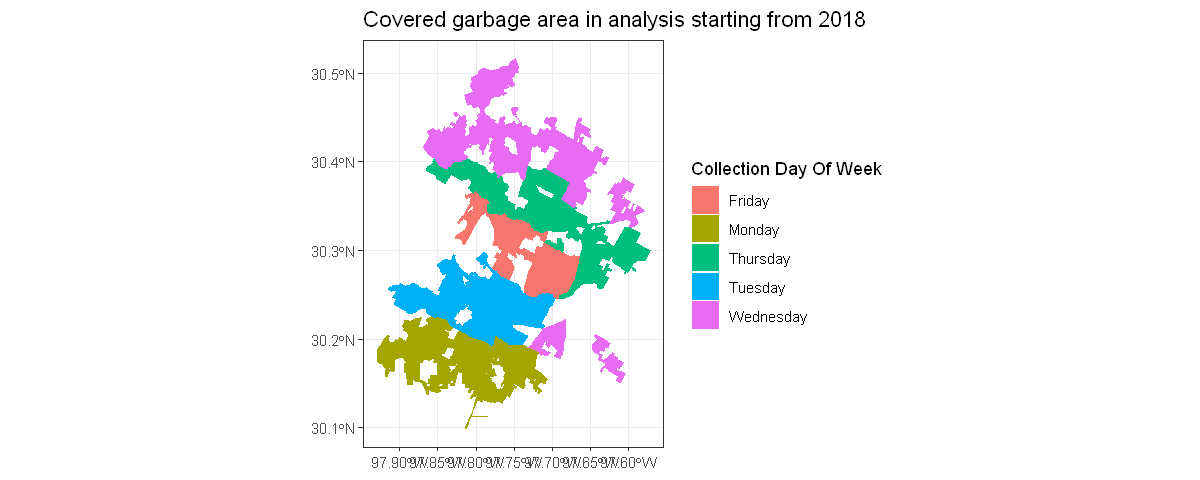

In [57]:
p_g_2018_ <- ggplot () + geom_sf (data = garb_mapdata %>% filter (garb_rt %in% valid_garb_rts$route_number), aes(color = garb_day, fill = garb_day)) + 
scale_fill_discrete(name = "Collection Day Of Week") + scale_color_discrete(name = "Collection Day Of Week")  + 
labs (title = paste0("Covered garbage area in analysis starting from ", min (Years))) + theme_bw()
p_g_2018_

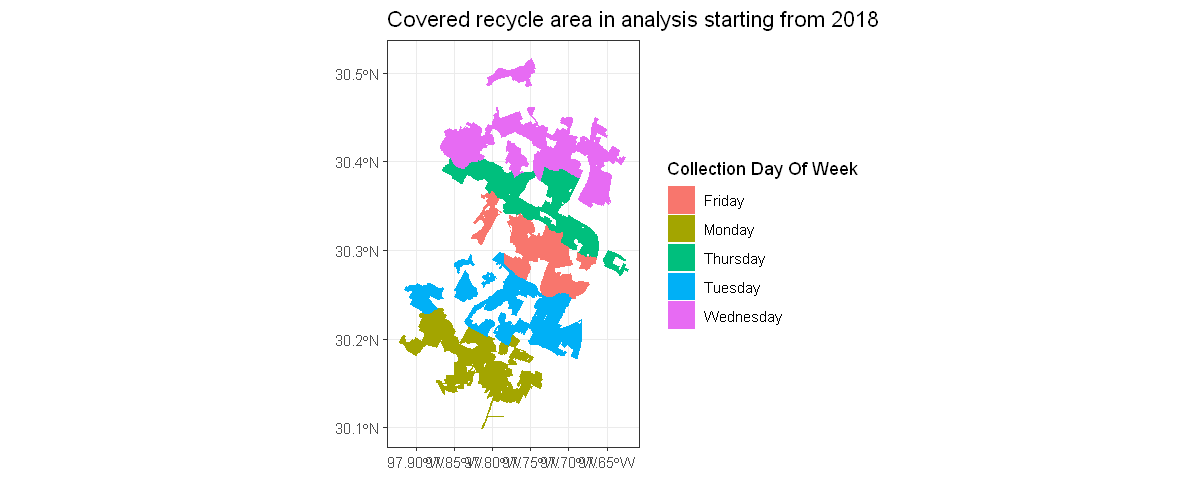

In [58]:
p_r_2018_ = ggplot () + geom_sf (data = rec_mapdata %>% filter (route_name %in% valid_rec_rts$route_number), aes(color = service_day, fill = service_day)) + 
scale_fill_discrete(name = "Collection Day Of Week") + scale_color_discrete(name = "Collection Day Of Week") + 
labs (title = paste0("Covered recycle area in analysis starting from ", min (Years))) + 
theme_bw()
p_r_2018_

#### 5.2. Collect 3 closest garbage and recycling route for each garbage and recycling route

**Create centroid for garbage routes and all recycle routes**

Only those valid routes are included that are part of the above filtered routes.

In [59]:
garb_centroids <- valid_garb_rts %>% left_join (garb_mapdata, by = c("route_number" = "garb_rt")) %>% 
  st_as_sf () %>%
  st_transform(29101) %>%
  st_centroid() %>%
  st_transform(., '+proj=longlat +ellps=GRS80 +no_defs')

rec_centroids <- valid_rec_rts %>% left_join (rec_mapdata, by = c("route_number" = "route_name")) %>%  
  st_as_sf() %>%
  st_transform(29101) %>%
  st_centroid() %>%
  st_transform(., '+proj=longlat +ellps=GRS80 +no_defs')

**Calculate the distances between polygon (route area) centroids**

The result is 3 matrices: one containing pairwise garbage route centroid distances, one containing pairwise garbage routes - recycle routes distances, and the third one contains pairwise recycle route distances.

Result is in units [m]

In [60]:
# distance matrices: tag after "garb_" ("garb" or "rec") identifies the type of row (i.e. "route_name"), last tag identifies the type of column ("int" means same as row type)
dist_garb_int <- st_distance (garb_centroids, garb_centroids, by_element = FALSE)
dist_garb_rec <- st_distance (garb_centroids, rec_centroids, by_element = FALSE)
dist_rec_int <- st_distance (rec_centroids, rec_centroids, by_element = FALSE)
dist_rec_garb <- t(dist_garb_rec )

Below quick sanity check: sum of number of 0 distances must be equal to number of routes

In [61]:
sum(as.integer(dist_garb_int)==0) - nrow(valid_garb_rts)    +    sum(as.integer(dist_rec_int)==0) - nrow(valid_rec_rts)

[1] 0

Convert distance matrices to dataframes

In [62]:
dist_garb_int <- data.frame (dist_garb_int) %>% 
   rename_with(.col = names(.), ~ as.character(garb_centroids$route_number)) %>%
   mutate (route_name = as.character(garb_centroids$route_number))

dist_garb_rec <- data.frame (dist_garb_rec) %>% 
   rename_with(.col = names(.), ~ as.character(rec_centroids$route_number)) %>%
   mutate (route_name = as.character(garb_centroids$route_number))

dist_rec_int <- data.frame (dist_rec_int) %>% 
   rename_with(.col = names(.), ~ as.character(rec_centroids$route_number)) %>%
   mutate (route_name = as.character(rec_centroids$route_number))

dist_rec_garb <- data.frame (dist_rec_garb) %>% 
   rename_with(.col = names(.), ~ as.character(garb_centroids$route_number)) %>%
   mutate (route_name = as.character(rec_centroids$route_number))

**Collect K (K=3) nearest neighbor routes to each garbage route, and to each recycle route**

In [63]:
# function to create K closest neighbor for each route in a distance matrix. Route: from route_name distanced to all other cols.
top_K_neighbors <- function (K, distance_df, route_to_type) 
{
    distance_df %>%
      pivot_longer (-route_name, names_to = "route_to", values_to = "distance")  %>%
      mutate (distance = as.numeric (distance)) %>%
      filter (distance > 0) %>%
      group_by (route_name) %>%
      arrange (distance, .by_group = TRUE) %>%
      mutate (rank = row_number()) %>%
      dplyr::slice (1:K) %>%
      mutate (route_to_2 = lead(route_to, order_by = distance), distance_2 = lead(distance, order_by = distance)) %>%
      mutate (route_to_3 = lead(route_to, 2, order_by = distance), distance_3 = lead(distance, 2, order_by = distance)) %>%
      drop_na() %>%
      rename_at ( vars(c("route_to", "distance")), ~c("route_to_1", "distance_1") ) %>%
      rename_with(.cols = starts_with("route_to"), function(x){paste0(route_to_type, "_", x)}) %>%
      rename_with(.cols = starts_with("dist"), function(x){paste0(route_to_type, "_", x)}) %>%
      select (-rank) 
}



In [64]:
# Gather closest K garbage and recycle
garb_rt_neighbors = top_K_neighbors (3, dist_garb_int, "garb") %>% 
   left_join (top_K_neighbors (3, dist_garb_rec, "rec"), by = c("route_name" = "route_name"))

rec_rt_neighbors = top_K_neighbors (3, dist_rec_int, "rec") %>% 
   left_join (top_K_neighbors (3, dist_rec_garb, "garb"), by = c("route_name" = "route_name"))

**Create dataset that is filtered according to the above criteria and contains 3 closes neighbors of those routes meeting criteria**

As found earlier, the collection day of the week is a good geographical splitter information for routes, therefore first let us add that to our neighbor info

In [65]:
# Add Collection Date Of Week 
garb_rt_neighbors <- garb_rt_neighbors %>% 
  left_join (garb_mapdata %>% st_drop_geometry %>% select (garb_rt, garb_day), by = c("route_name" = "garb_rt")) %>%
  rename (DOW = garb_day)
rec_rt_neighbors <- rec_rt_neighbors %>% left_join (rec_mapdata %>% st_drop_geometry %>% select (route_name, service_day), by = c("route_name" = "route_name")) %>%
  rename (DOW = service_day)

Filter to routes meeting the above criteria and abb closest neighbors in one step

In [66]:
dt_st <- rbind (garb_rt_neighbors, rec_rt_neighbors) %>% left_join (dt, by = c("route_name" = "route_number")) %>% filter (load_time < '2021-07-01') %>% filter (year %in% c(Years,2021))

Add week of the year as character string to the data

In [67]:
dt_st <- dt_st %>% 
   mutate (load_wk = strftime (load_time, "%W")) %>%
   mutate (load_wk = paste0 (year, "-", load_wk))

#### 5.3. Adding US Holidays

We had the idea that maybe the number of Holidays in a week impacts the waste quantity on that week. Therefore we decided to add that information.

Extract Holidays and convert to Year - Week_of_Year format

In [68]:
Holis <- timeDate::listHolidays() %>% grep ("US|Easter",., value = TRUE)

In [69]:
# after unlist the dates are in UNIX timestamp format
Holidays <- unlist(lapply (Holis, function (Holi) lapply (c(Years, 2021), function (Year) do.call(eval(parse(text=paste0('timeDate::', Holi))), list(Year))@Data)))

In [70]:
# Convert to date
Holidays <- as.POSIXct(Holidays, origin = "1970-01-01")

In [71]:
# Convert to Year-Wk_of_Year Day_Of_Week
Holidays <- strftime (Holidays, format = "%Y-%W %A")

Remove those Holidays that are on Saturday or on Sunday and remove the Day_of_Week info

In [72]:
Holidays <- Holidays [!(substr(Holidays,9,9) == "S")]

In [73]:
Holidays <- substr(Holidays,1,7)

Create a dataframe containing Year-wk and number of holidays on that week for each US Holiday

In [74]:
Holiday_Count <- data.frame(Holidays) %>% group_by (Holidays) %>% summarise (Holi_per_wk = n())

Add the number of holidays per week info to our dataset

In [75]:
dt_st <- dt_st %>% 
   left_join (Holiday_Count, by = c("load_wk" = "Holidays"))  %>%
   mutate (Holi_per_wk = ifelse( is.na(Holi_per_wk) ,0 ,Holi_per_wk))

#### 5.4. Create Dataset for ML model

**Get rid of obvious outliars**

We saw already in the EDA section that there are a number of likely errors, outliars in the data. We did quite a bit of filtering, so worth checking the status how it looks in the current dataset.

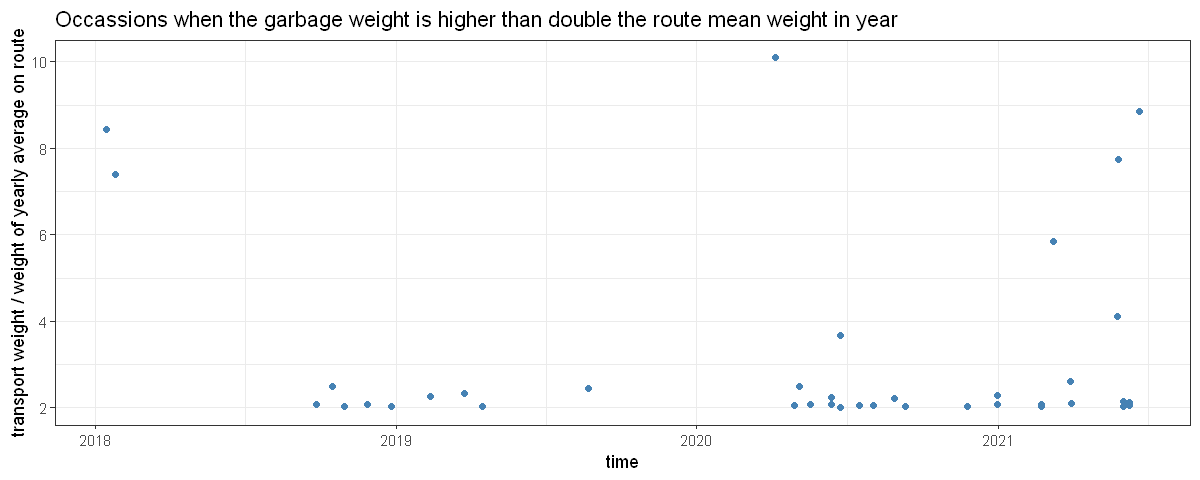

In [76]:
dt_st %>% filter (year %in% seq(2005,2021))  %>%
  group_by (route_name, year) %>%
  
  mutate (mean_ry = mean (load_weight, na.rm = TRUE)) %>%
  ungroup () %>%
  mutate (huge_factor = load_weight / mean_ry) %>%
  filter (huge_factor > 2) %>%
  ggplot (aes(cr_date, huge_factor )) + geom_point(color = "steelblue") + 
  labs (title = "Occassions when the garbage weight is higher than double the route mean weight in year", x = "time", y = "transport weight / weight of yearly average on route" ) + 
  theme_bw()

There are a few, so we treat those before proceeding. For the sake of simplicity, treatment is simply dropping those datapoints where the collected weight is minimum 4 times higher that the route's yearly average.

In [77]:
# Collecting and dropping outliars

Out_Lim <- 4

outliars <- dt_st %>% filter (year %in% seq(2005,2021))  %>%
  group_by (route_name, year) %>%
  mutate (mean_ry = mean (load_weight, na.rm = TRUE)) %>%
  ungroup () %>%
  mutate (huge_factor = load_weight / mean_ry) %>%
  filter (huge_factor >= Out_Lim)

dt_st_clean <- dt_st %>% anti_join (outliars, by = c("route_name"="route_name", "year"="year",  "load_weight" = "load_weight"))

**Aggregate data to weeks**

As collection is -typically- weekly activity, we worked on weekly data. Though according to the Austin government explanations garbage collections takes place weekly and recycle collection bi-weekly, this is not always the case. We found in the data that occassionaly there are more collections taking place on the same route in the same week. We do not know the exact reason for this, we assume that maybe there was not enough cars availabel on the due day. (This is why we are creating this model.) For this reason we aggregate waste data on weeks.

When creating the dataset for the ML model, we first aggregated data on weekly level, then created the lags for the actual route's and the closest neighbours'.

In [78]:
# aggregate load weight on route by week
dt_st_wk <- dt_st_clean %>%
   group_by (load_wk, route_name) %>%
   summarise (wk_weight = sum(load_weight, na.rm = TRUE)) %>% 
   left_join (dt_st_clean) %>% 
   select (-c(report_date, load_time, load_id, load_weight, cr_date)) %>%
   select (-c(load_type, dropoff_site)) %>% 
   select (-c(garb_distance_1, garb_distance_2, garb_distance_3,  rec_distance_1, rec_distance_2, rec_distance_3)) %>%
   group_by (route_name, load_wk) %>%
   dplyr::slice (1) %>%
   ungroup() 

`summarise()` has grouped output by 'load_wk'. You can override using the `.groups` argument.
Joining, by = c("load_wk", "route_name")


In [79]:
# gather the weight of neighboring routes for each week

garb_neighbor_1 <- dt_st_wk %>% 
   select (garb_route_to_1, load_wk) %>% 
   left_join (dt_st_wk, by = c("garb_route_to_1"="route_name", "load_wk"="load_wk")) %>%
   distinct() %>%
   select (garb_route_to_1, load_wk, wk_weight) %>%
   rename (garb_w_1 = wk_weight)

garb_neighbor_2 <- dt_st_wk %>% 
   select (garb_route_to_2, load_wk) %>% 
   left_join (dt_st_wk, by = c("garb_route_to_2"="route_name", "load_wk"="load_wk")) %>%
   distinct() %>%
   select (garb_route_to_2, load_wk, wk_weight) %>%
   rename (garb_w_2 = wk_weight)

garb_neighbor_3 <- dt_st_wk %>% 
   select (garb_route_to_3, load_wk) %>% 
   left_join (dt_st_wk, by = c("garb_route_to_3"="route_name", "load_wk"="load_wk")) %>%
   distinct() %>%
   select (garb_route_to_3, load_wk, wk_weight) %>%
   rename (garb_w_3 = wk_weight)

rec_neighbor_1 <- dt_st_wk %>% 
   select (rec_route_to_1, load_wk) %>% 
   left_join (dt_st_wk, by = c("rec_route_to_1"="route_name", "load_wk"="load_wk")) %>%
   distinct() %>%
   select (rec_route_to_1, load_wk, wk_weight) %>%
   rename (rec_w_1 = wk_weight)

rec_neighbor_2 <- dt_st_wk %>% 
   select (rec_route_to_2, load_wk) %>% 
   left_join (dt_st_wk, by = c("rec_route_to_2"="route_name", "load_wk"="load_wk")) %>%
   distinct() %>%
   select (rec_route_to_2, load_wk, wk_weight) %>%
   rename (rec_w_2 = wk_weight)

rec_neighbor_3 <- dt_st_wk %>% 
   select (rec_route_to_3, load_wk) %>% 
   left_join (dt_st_wk, by = c("rec_route_to_3"="route_name", "load_wk"="load_wk")) %>%
   distinct() %>%
   select (rec_route_to_3, load_wk, wk_weight) %>%
   rename (rec_w_3 = wk_weight)

In [80]:
# add back neighbor routes weights to weekly dataset
dt_st_wk <- dt_st_wk %>%
   left_join (garb_neighbor_1, by = c("garb_route_to_1"= "garb_route_to_1", "load_wk" =  "load_wk")) %>%
   left_join (garb_neighbor_2, by = c("garb_route_to_2"= "garb_route_to_2", "load_wk" =  "load_wk")) %>%
   left_join (garb_neighbor_3, by = c("garb_route_to_3"= "garb_route_to_3", "load_wk" =  "load_wk")) %>%
   left_join (rec_neighbor_1,  by = c("rec_route_to_1" = "rec_route_to_1", "load_wk" =  "load_wk")) %>%
   left_join (rec_neighbor_2,  by = c("rec_route_to_2" = "rec_route_to_2", "load_wk" =  "load_wk")) %>%
   left_join (rec_neighbor_3,  by = c("rec_route_to_3" = "rec_route_to_3", "load_wk" =  "load_wk")) 


**Adding lag data**

We assume that we can infer from past few weeks to the current one, hence here we are adding lags for own and neighbor weekly weights

In [81]:
# Adding lags
dt_ML <- dt_st_wk %>%
  group_by (route_name) %>%
  # create lags and move suffixes to prefix
  mutate_at(vars(starts_with("garb_w_"), starts_with ("rec_w"), starts_with ("wk_"), starts_with("Holi_")), .funs = list(l1 = ~lag (., 1, order_by = load_wk))) %>% 
  rename_at( vars( contains( "_l1") ), list( ~paste("l1", gsub("_l1", "", .), sep = "_") ) ) %>% 
  mutate_at(vars(starts_with("garb_w_"), starts_with ("rec_w"), starts_with ("wk_")), .funs = list(l2 = ~lag (., 2, order_by = load_wk))) %>% 
  rename_at( vars( contains( "_l2") ), list( ~paste("l2", gsub("_l2", "", .), sep = "_") ) ) %>% 
  mutate_at(vars(starts_with("garb_w_"), starts_with ("rec_w"), starts_with ("wk_")), .funs = list(l3 = ~lag (., 3, order_by = load_wk))) %>% 
  rename_at( vars( contains( "_l3") ), list( ~paste("l3", gsub("_l3", "", .), sep = "_") ) ) %>% 
  ungroup()

In [82]:
names (dt_ML)

[1] "load_wk"         "route_name"      "wk_weight"       "garb_route_to_1"
 [5] "garb_route_to_2" "garb_route_to_3" "rec_route_to_1"  "rec_route_to_2" 
 [9] "rec_route_to_3"  "DOW"             "route_type"      "year"           
[13] "Holi_per_wk"     "garb_w_1"        "garb_w_2"        "garb_w_3"       
[17] "rec_w_1"         "rec_w_2"         "rec_w_3"         "l1_garb_w_1"    
[21] "l1_garb_w_2"     "l1_garb_w_3"     "l1_rec_w_1"      "l1_rec_w_2"     
[25] "l1_rec_w_3"      "l1_wk_weight"    "l1_Holi_per_wk"  "l2_garb_w_1"    
[29] "l2_garb_w_2"     "l2_garb_w_3"     "l2_rec_w_1"      "l2_rec_w_2"     
[33] "l2_rec_w_3"      "l2_wk_weight"    "l3_garb_w_1"     "l3_garb_w_2"    
[37] "l3_garb_w_3"     "l3_rec_w_1"      "l3_rec_w_2"      "l3_rec_w_3"     
[41] "l3_wk_weight"

Now we have the final data for the ML algorithm, consisting of the following explanatory variables:

- week of the year controlling for seasonality ('load_wk')

- collection day of the week on the given route ('DOW', this in fact is not an exlpanatory variable, we will use this when splitting the data to geographical areas, as the one 'DOW' corresponds toone Austin area)

- Number of Holiday days on the given week (Holi_per_wk)

- Three closest neighboring routes' weekly garbage weight in the 3 previous weeks (L_garb_w_X, where X is the distance rank of the neighbor and L is the lag, e.g. X =1 means closest, L = 3 means 3 weeks before) 

- The same as above for recycling route, as we thought that maybe recycling can impact weekly waste (L_rec_w_X, where L and X as above)

- The previous 3 weeks' garbage weight on the given route (L_wk_weight, where L as above)

And we have the target variable, which is the weekly collected garbage weight ('wk_weight')

Do note that with creating the lagged data we have a clear data-definition of our task: based on the known waste of the past 3 garbage collection and recycle from current route and its 3 closes neighbours, as well as some basic other data, such as number of Holidays on the actual week and the preivous week, we try to predict the weight of the garbage collection this week.

#### 5.5. Data train - test split for ML model

Though with Time Embedding we transformed our Time Series to a "normal" ML problem, we still work with time. Therefore it is important that our test dataset it the "newest" data, in order to make sure that we really can infer from past to future.

Therefore here we set 2021 data as test set, and 2018 - 2020 as training data. (Later we repeat the model building using 2012 - 2020 training data).

Training - Test split is packaged in feature in order to allow flexibility in calling it for different areas (ie. represented by collection day), etc.

In [83]:
# Can filter to Area defined by DOW Collection day, or by single route
train_test_split <- function (data, FilterCrit, FilterType)
{
    data_train <- data %>%
      {if (FilterType == "DOW") filter (., DOW == FilterCrit) else filter (., route_name == FilterCrit)} %>%
      #filter (DOW == DayOfWk) %>%
      #filter (route_name == ...) %>%    # alternative to above if 
      filter (year != 2021) %>%
      mutate (load_wk = as.numeric (substr(load_wk,6,7))) %>%
      select(starts_with ("l1"), starts_with ("l2"), starts_with ("l3"), starts_with ("load"), starts_with("Holi"))
  
    data_test <- data %>%
      {if (FilterType == "DOW") filter (., DOW == FilterCrit) else filter (., route_name == FilterCrit)} %>%
      #filter (DOW == DayOfWk) %>%
      #filter (route_name == "PAF01") %>%    # alternative to above
      filter (year == 2021) %>%
      mutate (load_wk = as.numeric (substr(load_wk,6,7))) %>%
      select(starts_with ("l1"), starts_with ("l2"), starts_with ("l3"), starts_with ("load"), starts_with("Holi"))

    label_train <- data %>%
      {if (FilterType == "DOW") filter (.,DOW == FilterCrit) else filter (., route_name == FilterCrit)} %>%
      #filter (DOW == DayOfWk) %>%
      #filter (route_name == "PAF01") %>%    # alternative to above
      filter (year != 2021) %>%
      select (wk_weight)

    label_test <- data %>%
      {if (FilterType == "DOW") filter (., DOW == FilterCrit) else filter (., route_name == FilterCrit)} %>%
      #filter (DOW == DayOfWk) %>%
      #filter (route_name == "PAF01") %>%    # alternative to above
      filter (year == 2021) %>%
      select (wk_weight)
    return (list(data_train, data_test, label_train, label_test))
}

Here we are splitting the dataset for working on the geographical area where garbage collection is taking place on every Monday. If you look at the plot a few sub-chapters above you can see that this is the very south part of Austin.

*Note: here we create training and test data for a given time period (set well above) and for given area. In this dataset creating this is for 2018-2021H1 period and for South Austin (Monday garbage collection area)*

*Later we will extend our analysis to other period and other areas*

In [84]:
library (zeallot)
c(data_train, data_test, label_train, label_test) %<-% train_test_split (dt_ML, "Monday", "DOW")

#### 5.6. Building and running ML prediction model

Becasue we have our data in a nice data table format, we will build an XGBoost model with the folling steps:

- Transform our data to matrix for XGBoost

- Tune parameters via grid search

- Train the model with the selected hyper parameters 5-fold cross validation and have a feeling about model accuracy

- Train the model finally on the entire training data

- Do prediction

In the coming section we explain the model building steps on data belonging to the most south area of Austin (collection day is Monday) in 2018 - 2021H1 period.

Then we will repeat modelling for the middle section of Austin (Friday collection area) in the same period, and put aside the result for further analysis. Also do the same prediction for an arbitrarily selected route, just in order to be able to compare more granular route level model to less granular area level model.

Then we implement a function that repeatedly shapes data for each of the 5 Austin areas, does prediction and stores the key parameters of the result.

When we finish with all of these, we will have summary result for all 5 Austin areas for the 2018-2021H1 period, and more details for 2 areas (Monday and Friday collection areas) and for one route for the same period.

Once it is done, we repeate this entire process for the 2012-2021H1 period.

Once all done, we are ready to evaluate the results.

**Convert to matrix for XGBoost**

In [85]:
# Converting data frames to xgb matrix for xgboost

library (xgboost)
dtrain <- xgb.DMatrix(data = as.matrix(data_train), label = data.table(label_train)$wk_weight)
dtest <- xgb.DMatrix(data = as.matrix(data_test))


Attaching package: 'xgboost'

The following object is masked from 'package:dplyr':

    slice



**Grid search based hyper parameter tuning**

In [86]:
# Gridsearch setting: create GridSearch table
searchGridSubCol <- expand.grid(subsample = c(0.5, 0.6, 0.7, 0.8, 1), 
                                colsample_bytree = c(0.5, 0.6, 0.7, 0.8, 1),
                                lambda = c(0.01, 0.1, 1),
                                min_child = seq(1), 
                                eta = c(0.28, 0.3, 0.32)
)

In [87]:
# SearchGrid function
SearchGrid_XGB <- function (searchGridSubCol, x_train, y_train)
{
  ### Number of Itreations per search
  niters <- 25
  
  
  ### Do the Search
  xgbstuff <- apply(searchGridSubCol, 1, function(parameterList)
  {
    
    #Extract Parameters to test
    currentSubsampleRate <- parameterList[["subsample"]]
    currentColsampleRate <- parameterList[["colsample_bytree"]]
    currentLambda <- parameterList[["lambda"]]
    currentEta <- parameterList[["eta"]]
    currentMinChild <- parameterList[["min_child"]]
    xgboostModelCV <- xgb.cv(data = x_train, 
                             #label = y_train, 
                             nfold = 5,
                             objective = "reg:squarederror", nrounds = niters, scale_pos_weight = 0.12,
                             verbose = FALSE, 
                             "eval_metric" = "rmse",
                             "lambda" = currentLambda, "eta" = currentEta,                               
                             "subsample" = currentSubsampleRate, "colsample_bytree" = currentColsampleRate,
                             print_every_n = 10, 
                             "min_child_weight" = currentMinChild, booster = "gbtree",
                             early_stopping_rounds = 10)
    return(c(currentSubsampleRate, currentColsampleRate, currentLambda, 
             currentEta, currentMinChild, xgboostModelCV$evaluation_log))
  })
  
  ### Evaluate the search: collect and print the best AUC parameter combination
  mean_test_rmse <- unlist(lapply (xgbstuff, function (x) mean(x$test_rmse_mean)))
  min_test_rmse_index <- which.min (mean_test_rmse)
  return(xgbstuff [min_test_rmse_index])
  
}

In [88]:
SearchGrid_XGB (searchGridSubCol,dtrain, getinfo(dtrain, 'label'))

[[1]]
[[1]][[1]]
[1] 1

[[1]][[2]]
[1] 0.8

[[1]][[3]]
[1] 0.1

[[1]][[4]]
[1] 0.32

[[1]][[5]]
[1] 1

[[1]]$iter
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25

[[1]]$train_rmse_mean
 [1] 21481.060 15452.732 11561.144  9153.058  7723.347  6899.290  6441.569
 [8]  6157.170  5974.927  5840.319  5722.476  5644.753  5569.552  5511.866
[15]  5456.740  5413.207  5337.888  5292.806  5250.287  5193.163  5131.260
[22]  5084.119  5052.668  4997.820  4955.499

[[1]]$train_rmse_std
 [1] 25.90218 40.79092 29.74378 38.63405 37.93658 49.13361 52.34471 46.81456
 [9] 56.08592 49.07330 65.90076 63.07767 62.61357 60.54829 72.78287 69.06364
[17] 70.25041 65.25211 66.42333 47.58182 46.81030 41.17581 34.36138 40.19761
[25] 36.18729

[[1]]$test_rmse_mean
 [1] 21557.918 15687.318 11984.880  9804.730  8592.018  7961.802  7640.092
 [8]  7498.588  7434.668  7396.187  7389.446  7384.584  7385.650  7376.722
[15]  7374.433  7376.633  7384.928  7387.714  7390.889  7401.701  7403.473
[22]  7412.045  7410.734  7418.577  7425.887

[[1]]$test_rmse_std
 [1] 147.22732 137.20456 117.86167 103.01342 105.57936 102.64085 102.14750
 [8]  89.65513  96.40284  93.78408 114.98363 112.17150 113.60609 123.26524
[15] 132.59590 138.63969 147.73432 147.81226 149.43783 147.39510 151.48442
[22] 153.02645 151.11485 144.84681 144.78572

Setting xgboost parameters based on gridsearch result and several manual trials

In [89]:
params <- list(booster = "gbtree", objective = "reg:squarederror", max_depth=3, colsample_bytree = 0.8, subsample = 1, 
               scale_pos_weight = 0.12, lambda = 1, eta = 0.32, eval_metric = "rmse")

**Training XGBoost on 5 fold cross validation to see the model accuracy and then on the entire dataset**

*Note: 'nrounds' below is set based on manual trials*

In [90]:
# cross validation
set.seed(123)
xgbcv <- xgb.cv( params = params, data = dtrain, nrounds = 20, nfold = 5, showsd = T, stratified = T, print_every_n = 10, early_stop_round = 20, maximize = F)

[1]	train-rmse:21604.046875+54.507243	test-rmse:21621.186719+240.777855 
[11]	train-rmse:7032.200293+58.401288	test-rmse:7314.570019+166.331979 
[20]	train-rmse:6797.420508+59.773959	test-rmse:7238.096680+185.189041 


Training the model on the entire training set

In [91]:
set.seed(123)
bst_2018_Monday <- xgboost(data = dtrain, nrounds = 20, params = params)

[1]	train-rmse:21600.886719 
[2]	train-rmse:15698.748047 
[3]	train-rmse:11975.129883 
[4]	train-rmse:9751.404297 
[5]	train-rmse:8510.661133 
[6]	train-rmse:7832.619141 
[7]	train-rmse:7487.693848 
[8]	train-rmse:7300.274414 
[9]	train-rmse:7193.192871 
[10]	train-rmse:7132.295898 
[11]	train-rmse:7078.549805 
[12]	train-rmse:7040.507324 
[13]	train-rmse:7009.309570 
[14]	train-rmse:6985.036133 
[15]	train-rmse:6962.908203 
[16]	train-rmse:6945.962891 
[17]	train-rmse:6923.239746 
[18]	train-rmse:6901.367676 
[19]	train-rmse:6887.767090 
[20]	train-rmse:6867.963379 


**Prediction**

In [92]:
y_test_prob_vec_2018_Monday <- predict (bst_2018_Monday, dtest)
# save test label for the evaluation
label_test_2018_Monday <- label_test

**Train and save a model for the "Friday area" in the 2018-2021H1 period for later use.**

In [93]:
c(data_train, data_test, label_train, label_test) %<-% train_test_split (dt_ML, "Friday", "DOW")
    
dtrain <- xgb.DMatrix(data = as.matrix(data_train), label = data.table(label_train)$wk_weight)
dtest <- xgb.DMatrix(data = as.matrix(data_test))
    
set.seed (123)
bst_2018_Friday <- xgboost(data = dtrain, nrounds = 20, params = params, verbose = 0)

# Prediction
y_test_prob_vec_2018_Friday <- predict (bst_2018_Friday, dtest)


# save test label for the evaluation
label_test_2018_Friday <- label_test

**Save a model in this period for one arbitrarily selected route (i.e. route and not for one area) for the same 2018-2021H1 period**

The route has been selected in such a way that it existed throughout the entire 2021-2021H1 period.

We will use this model later

In [94]:
# split data / test set to include only selected area/route
c(data_train, data_test, label_train, label_test) %<-% train_test_split (dt_ML, "PAW74", "route")

# create matrix for xgb
dtrain <- xgb.DMatrix(data = as.matrix(data_train), label = data.table(label_train)$wk_weight)
dtest <- xgb.DMatrix(data = as.matrix(data_test))

# train model
set.seed (123)
bst_2018R <- xgboost(data = dtrain, nrounds = 20, params = params, verbose = 0)

# Prediction
y_test_prob_vec_2018_R <- predict (bst_2018R, dtest)

# save test label for the evaluation
label_test_2018_R <- label_test

**Repeat the analysis for all the areas (as represented by collection days) in this 2018-2021H1 period**

The same parameters are used, grid-search and parameter setting are not changed.

Key statistical parameters of the prediction and the real (test) data are recorded.

In [95]:
DOWs<- c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday" )

In [96]:
XGB_wrapper <- function (DayOfWk, YearFrom)
{
    c(data_train, data_test, label_train, label_test) %<-% train_test_split (dt_ML, DayOfWk, "DOW")
    
    dtrain <- xgb.DMatrix(data = as.matrix(data_train), label = data.table(label_train)$wk_weight)
    dtest <- xgb.DMatrix(data = as.matrix(data_test))
    
    set.seed (123)
    bst <- xgboost(data = dtrain, nrounds = 20, params = params, verbose = 0)
    
    y_test_prob_vec <- predict (bst, dtest)
    
    s <- summary(abs(y_test_prob_vec - label_test$wk_weight))
    RMSE <- sqrt(sum((y_test_prob_vec - label_test$wk_weight)^2 ) / nrow (label_test))
    AbsErrMean <- as.numeric(s["Mean"])
    AbsErrMed <- as.numeric(s["Median"])
    AbsErr3rd <- as.numeric(s["3rd Qu."])
    AbsErrMax <- as.numeric(s["Max."])
    AbsErrMin <- as.numeric(s["Min."])
    DataMin <- min(label_test$wk_weight)
    DataMean <- mean(label_test$wk_weight)
    DataMax <- max(label_test$wk_weight)
    DataSD  <- sd(label_test$wk_weight)
    DataPoints <- length (label_test$wk_weight)
    return (data.frame (DataPoints, RMSE, AbsErrMin, AbsErrMed, AbsErrMean, AbsErr3rd, AbsErrMax, 
                        DataMin, DataMean, DataMax, DataSD, YearFrom, DayOfWk))
}

In [97]:
XGB_stat_2018_ <- do.call(rbind, lapply (DOWs, function (DayOfWk) XGB_wrapper (DayOfWk, 2018)))

**Repeating the entire modelling for the period 2012-2121H1**

*Note: Indeed, this is not nice to repeat the code, does not confirm to the DRY principle. The reason why have not written all above as function because had to explain in a notebook style what and whay are done*

We basically re-start all that has been done from 5.1. until this point, but here for the 2012 - 2021H1 period, except that the Grid search is not done.

Here we predict and collect details for the same areas that we collected for the 2018-2021H1 period, and also the same key statistical parameters for all the 5 "collection day areas" as did above.

In [98]:
# Setting yearly filters: years in scope and excpected number of weeks with garbage collection in each year to include a route
Years = seq (2012,2020)
Min_garb = 46
Min_rec = 23
Min_garbs = c(rep(Min_garb, (max(Years) - min (Years) + 1)), ceiling(Min_garb/2))
Min_recs <- c(rep(Min_rec, (max(Years) - min (Years) + 1)), ceiling(Min_rec/2))
names(Min_garbs) <- c(Years,2021)
names(Min_recs) <- c(Years,2021)



In [99]:
# routes that meet the above criteria are collected in valid_garb_rts and valid_rec_rts, route_number columns
valid_garb_rts <- dt %>% 
   filter (route_number %in% garb_mapdata$garb_rt) %>%
   filter (load_time < '2021-07-01') %>%
   filter (year %in% c(Years,2021)) %>%
   mutate (load_wk = strftime(load_time,format="%W")) %>%
   distinct (route_number, year, load_wk) %>%
   group_by (route_number, year) %>%
   summarise (yearly_wk_coll = n()) %>%
   filter (  yearly_wk_coll >= Min_garbs [as.character(year)]) %>% 
   summarise (ys = n()) %>% 
   filter (ys ==(length(Years)+1)) 


valid_rec_rts <- dt %>% 
   filter (route_number %in% rec_mapdata$route_name) %>%
   filter (load_time < '2021-07-01') %>%
   filter (year %in% c(Years,2021)) %>%
   mutate (load_wk = strftime(load_time,format="%W")) %>%
   distinct (route_number, year, load_wk) %>%
   group_by (route_number, year) %>%
   summarise (yearly_wk_coll = n()) %>%
   filter (  yearly_wk_coll >= Min_recs [as.character(year)]) %>% 
   summarise (ys = n()) %>% 
   filter (ys ==(length(Years)+1)) 
   

`summarise()` has grouped output by 'route_number'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'route_number'. You can override using the `.groups` argument.


In [100]:
p_g_2012_ <- ggplot () + geom_sf (data = garb_mapdata %>% filter (garb_rt %in% valid_garb_rts$route_number), aes(color = garb_day, fill = garb_day)) + 
scale_fill_discrete(name = "Collection Day Of Week") + scale_color_discrete(name = "Collection Day Of Week")  + 
labs (title = paste0("Covered garbage area in analysis starting from ", min (Years))) + theme_bw()

In [101]:
garb_centroids <- valid_garb_rts %>% left_join (garb_mapdata, by = c("route_number" = "garb_rt")) %>% 
  st_as_sf () %>%
  st_transform(29101) %>%
  st_centroid() %>%
  st_transform(., '+proj=longlat +ellps=GRS80 +no_defs')

rec_centroids <- valid_rec_rts %>% left_join (rec_mapdata, by = c("route_number" = "route_name")) %>%  
  st_as_sf() %>%
  st_transform(29101) %>%
  st_centroid() %>%
  st_transform(., '+proj=longlat +ellps=GRS80 +no_defs')

In [102]:
# distance matrices: tag after "garb_" ("garb" or "rec") identifies the type of row (i.e. "route_name"), last tag identifies the type of column ("int" means same as row type)
dist_garb_int <- st_distance (garb_centroids, garb_centroids, by_element = FALSE)
dist_garb_rec <- st_distance (garb_centroids, rec_centroids, by_element = FALSE)
dist_rec_int <- st_distance (rec_centroids, rec_centroids, by_element = FALSE)
dist_rec_garb <- t(dist_garb_rec )

In [103]:
# convert to dataframe
dist_garb_int <- data.frame (dist_garb_int) %>% 
   rename_with(.col = names(.), ~ as.character(garb_centroids$route_number)) %>%
   mutate (route_name = as.character(garb_centroids$route_number))

dist_garb_rec <- data.frame (dist_garb_rec) %>% 
   rename_with(.col = names(.), ~ as.character(rec_centroids$route_number)) %>%
   mutate (route_name = as.character(garb_centroids$route_number))

dist_rec_int <- data.frame (dist_rec_int) %>% 
   rename_with(.col = names(.), ~ as.character(rec_centroids$route_number)) %>%
   mutate (route_name = as.character(rec_centroids$route_number))

dist_rec_garb <- data.frame (dist_rec_garb) %>% 
   rename_with(.col = names(.), ~ as.character(garb_centroids$route_number)) %>%
   mutate (route_name = as.character(rec_centroids$route_number))

In [104]:
# Gather closest K garbage and recycle
garb_rt_neighbors = top_K_neighbors (3, dist_garb_int, "garb") %>% 
   left_join (top_K_neighbors (3, dist_garb_rec, "rec"), by = c("route_name" = "route_name"))

rec_rt_neighbors = top_K_neighbors (3, dist_rec_int, "rec") %>% 
   left_join (top_K_neighbors (3, dist_rec_garb, "garb"), by = c("route_name" = "route_name"))

In [105]:
# Add Collection Date Of Week 
garb_rt_neighbors <- garb_rt_neighbors %>% 
  left_join (garb_mapdata %>% st_drop_geometry %>% select (garb_rt, garb_day), by = c("route_name" = "garb_rt")) %>%
  rename (DOW = garb_day)
rec_rt_neighbors <- rec_rt_neighbors %>% left_join (rec_mapdata %>% st_drop_geometry %>% select (route_name, service_day), by = c("route_name" = "route_name")) %>%
  rename (DOW = service_day)

In [106]:
# Filter data
dt_st <- rbind (garb_rt_neighbors, rec_rt_neighbors) %>% left_join (dt, by = c("route_name" = "route_number")) %>% filter (load_time < '2021-07-01') %>% filter (year %in% c(Years,2021))

In [107]:
dt_st <- dt_st %>% 
   mutate (load_wk = strftime (load_time, "%W")) %>%
   mutate (load_wk = paste0 (year, "-", load_wk))

In [108]:
# Add Holiday info
Holis <- timeDate::listHolidays() %>% grep ("US|Easter",., value = TRUE)
Holidays <- unlist(lapply (Holis, function (Holi) lapply (c(Years, 2021), function (Year) do.call(eval(parse(text=paste0('timeDate::', Holi))), list(Year))@Data)))
Holidays <- as.POSIXct(Holidays, origin = "1970-01-01")
Holidays <- strftime (Holidays, format = "%Y-%W %A")
Holidays <- Holidays [!(substr(Holidays,9,9) == "S")]
Holidays <- substr(Holidays,1,7)
Holiday_Count <- data.frame(Holidays) %>% group_by (Holidays) %>% summarise (Holi_per_wk = n())
dt_st <- dt_st %>% 
   left_join (Holiday_Count, by = c("load_wk" = "Holidays"))  %>%
   mutate (Holi_per_wk = ifelse( is.na(Holi_per_wk) ,0 ,Holi_per_wk))

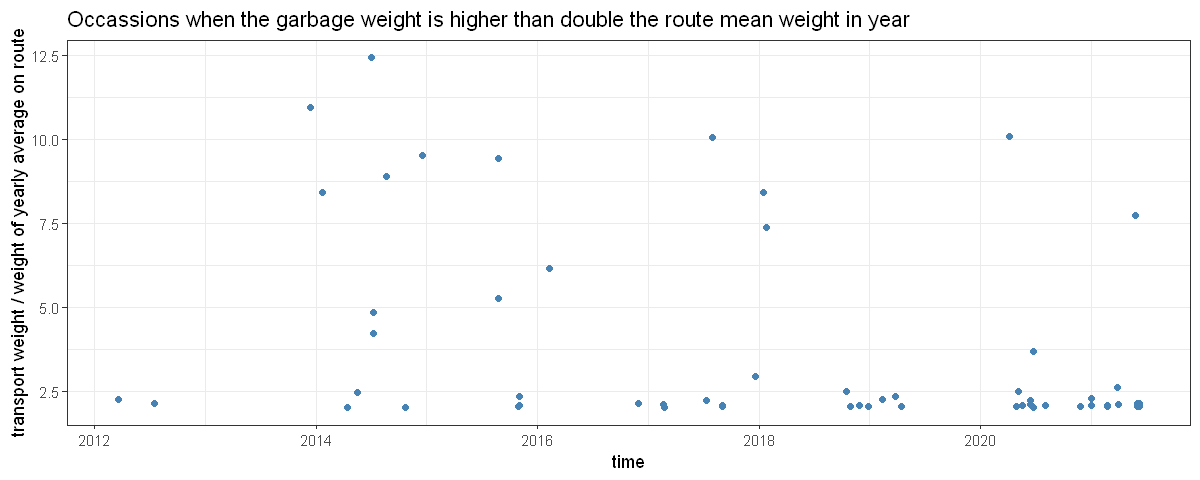

In [109]:
dt_st %>% filter (year %in% seq(2005,2021))  %>%
  group_by (route_name, year) %>%
  
  mutate (mean_ry = mean (load_weight, na.rm = TRUE)) %>%
  ungroup () %>%
  mutate (huge_factor = load_weight / mean_ry) %>%
  filter (huge_factor > 2) %>%
  ggplot (aes(cr_date, huge_factor )) + geom_point(color = "steelblue") + 
  labs (title = "Occassions when the garbage weight is higher than double the route mean weight in year", x = "time", y = "transport weight / weight of yearly average on route" ) + 
  theme_bw()

In [110]:
# Collecting and dropping outliars

Out_Lim <- 4

outliars <- dt_st %>% filter (year %in% seq(2005,2021))  %>%
  group_by (route_name, year) %>%
  mutate (mean_ry = mean (load_weight, na.rm = TRUE)) %>%
  ungroup () %>%
  mutate (huge_factor = load_weight / mean_ry) %>%
  filter (huge_factor >= Out_Lim)

dt_st_clean <- dt_st %>% anti_join (outliars, by = c("route_name"="route_name", "year"="year",  "load_weight" = "load_weight"))

In [111]:
# aggregate load weight on route by week
dt_st_wk <- dt_st_clean %>%
   group_by (load_wk, route_name) %>%
   summarise (wk_weight = sum(load_weight, na.rm = TRUE)) %>% 
   left_join (dt_st_clean) %>% 
   select (-c(report_date, load_time, load_id, load_weight, cr_date)) %>%
   select (-c(load_type, dropoff_site)) %>% 
   select (-c(garb_distance_1, garb_distance_2, garb_distance_3,  rec_distance_1, rec_distance_2, rec_distance_3)) %>%
   group_by (route_name, load_wk) %>%
   dplyr::slice (1) %>%
   ungroup() 

`summarise()` has grouped output by 'load_wk'. You can override using the `.groups` argument.
Joining, by = c("load_wk", "route_name")


In [112]:
# gather the weight of neighboring routes for each week

garb_neighbor_1 <- dt_st_wk %>% 
   select (garb_route_to_1, load_wk) %>% 
   left_join (dt_st_wk, by = c("garb_route_to_1"="route_name", "load_wk"="load_wk")) %>%
   distinct() %>%
   select (garb_route_to_1, load_wk, wk_weight) %>%
   rename (garb_w_1 = wk_weight)

garb_neighbor_2 <- dt_st_wk %>% 
   select (garb_route_to_2, load_wk) %>% 
   left_join (dt_st_wk, by = c("garb_route_to_2"="route_name", "load_wk"="load_wk")) %>%
   distinct() %>%
   select (garb_route_to_2, load_wk, wk_weight) %>%
   rename (garb_w_2 = wk_weight)

garb_neighbor_3 <- dt_st_wk %>% 
   select (garb_route_to_3, load_wk) %>% 
   left_join (dt_st_wk, by = c("garb_route_to_3"="route_name", "load_wk"="load_wk")) %>%
   distinct() %>%
   select (garb_route_to_3, load_wk, wk_weight) %>%
   rename (garb_w_3 = wk_weight)

rec_neighbor_1 <- dt_st_wk %>% 
   select (rec_route_to_1, load_wk) %>% 
   left_join (dt_st_wk, by = c("rec_route_to_1"="route_name", "load_wk"="load_wk")) %>%
   distinct() %>%
   select (rec_route_to_1, load_wk, wk_weight) %>%
   rename (rec_w_1 = wk_weight)

rec_neighbor_2 <- dt_st_wk %>% 
   select (rec_route_to_2, load_wk) %>% 
   left_join (dt_st_wk, by = c("rec_route_to_2"="route_name", "load_wk"="load_wk")) %>%
   distinct() %>%
   select (rec_route_to_2, load_wk, wk_weight) %>%
   rename (rec_w_2 = wk_weight)

rec_neighbor_3 <- dt_st_wk %>% 
   select (rec_route_to_3, load_wk) %>% 
   left_join (dt_st_wk, by = c("rec_route_to_3"="route_name", "load_wk"="load_wk")) %>%
   distinct() %>%
   select (rec_route_to_3, load_wk, wk_weight) %>%
   rename (rec_w_3 = wk_weight)

In [113]:
# add back neighbor routes weights to weekly dataset
dt_st_wk <- dt_st_wk %>%
   left_join (garb_neighbor_1, by = c("garb_route_to_1"= "garb_route_to_1", "load_wk" =  "load_wk")) %>%
   left_join (garb_neighbor_2, by = c("garb_route_to_2"= "garb_route_to_2", "load_wk" =  "load_wk")) %>%
   left_join (garb_neighbor_3, by = c("garb_route_to_3"= "garb_route_to_3", "load_wk" =  "load_wk")) %>%
   left_join (rec_neighbor_1,  by = c("rec_route_to_1" = "rec_route_to_1", "load_wk" =  "load_wk")) %>%
   left_join (rec_neighbor_2,  by = c("rec_route_to_2" = "rec_route_to_2", "load_wk" =  "load_wk")) %>%
   left_join (rec_neighbor_3,  by = c("rec_route_to_3" = "rec_route_to_3", "load_wk" =  "load_wk")) 

In [114]:
# Adding lags
dt_ML <- dt_st_wk %>%
  group_by (route_name) %>%
  # create lags and move suffixes to prefix
  mutate_at(vars(starts_with("garb_w_"), starts_with ("rec_w"), starts_with ("wk_"), starts_with("Holi_")), .funs = list(l1 = ~lag (., 1, order_by = load_wk))) %>% 
  rename_at( vars( contains( "_l1") ), list( ~paste("l1", gsub("_l1", "", .), sep = "_") ) ) %>% 
  mutate_at(vars(starts_with("garb_w_"), starts_with ("rec_w"), starts_with ("wk_")), .funs = list(l2 = ~lag (., 2, order_by = load_wk))) %>% 
  rename_at( vars( contains( "_l2") ), list( ~paste("l2", gsub("_l2", "", .), sep = "_") ) ) %>% 
  mutate_at(vars(starts_with("garb_w_"), starts_with ("rec_w"), starts_with ("wk_")), .funs = list(l3 = ~lag (., 3, order_by = load_wk))) %>% 
  rename_at( vars( contains( "_l3") ), list( ~paste("l3", gsub("_l3", "", .), sep = "_") ) ) %>% 
  ungroup()

Just as in the 2018-2021H1 period, we do prediction for all 5 areas and record prediction and real data (test data) summary.

In [115]:
XGB_stat_2012_ <- do.call(rbind, lapply (DOWs, function (DayOfWk) XGB_wrapper (DayOfWk, 2012)))

As did for 2018, let us save the 2012 model and test set for a deep dive for the "Monday" and "Friday" areas.

In [116]:
# Do train test split for the "Monday" area
c(data_train, data_test, label_train, label_test) %<-% train_test_split (dt_ML, "Monday", "DOW")
    
dtrain <- xgb.DMatrix(data = as.matrix(data_train), label = data.table(label_train)$wk_weight)
dtest <- xgb.DMatrix(data = as.matrix(data_test))
    
set.seed (123)
bst_2012_Monday <- xgboost(data = dtrain, nrounds = 20, params = params, verbose = 0)

# Prediction
y_test_prob_vec_2012_Monday <- predict (bst_2012_Monday, dtest)

# save test label for the evaluation
label_test_2012_Monday <- label_test


# Do train test split for the "Friday" area
c(data_train, data_test, label_train, label_test) %<-% train_test_split (dt_ML, "Friday", "DOW")
    
dtrain <- xgb.DMatrix(data = as.matrix(data_train), label = data.table(label_train)$wk_weight)
dtest <- xgb.DMatrix(data = as.matrix(data_test))
    
set.seed (123)
bst_2012_Friday <- xgboost(data = dtrain, nrounds = 20, params = params, verbose = 0)

# Prediction
y_test_prob_vec_2012_Friday <- predict (bst_2012_Friday, dtest)

# save test label for the evaluation
label_test_2012_Friday <- label_test

Also do the 2012 prediction for the same selected route as did for 2018.

In [117]:
# split data / test set to include only selected area/route
c(data_train, data_test, label_train, label_test) %<-% train_test_split (dt_ML, "PAW74", "route")

# create matrix for xgb
dtrain <- xgb.DMatrix(data = as.matrix(data_train), label = data.table(label_train)$wk_weight)
dtest <- xgb.DMatrix(data = as.matrix(data_test))

# train model
set.seed (123)
bst_2012R <- xgboost(data = dtrain, nrounds = 20, params = params, verbose = 0)

# Prediction
y_test_prob_vec_2012_R <- predict (bst_2012R, dtest)

# save test label for the evaluation
label_test_2012_R <- label_test

#### 5.7. Evaluation

The key metrics are summarized in the below table, and prediction vs. reality pictured.

Picture is only shown for two Austin areas (most south part with Monday collection and middle areas with Friday collection day of the week) for 2012-2021H1 and 2018-2021H1, while the summary table is given for all 5 areas for these two preiods.

In [118]:
Plt_comp_res <- function (predict_set, test_set, tit)
{
    cbind (predict_set, test_set) %>% mutate (index = row_number()) %>% 
       ggplot (aes(index,wk_weight)) + 
       geom_point (color = "black") + geom_smooth () +
       geom_point (aes(index, predict_set), color = "#f8766d") + theme_bw() +  
       labs (title = paste0(tit, " prediction vs. reality in time w trendline"), x = "time", y = "weekly garbage weight") + 
       theme_bw() +
       theme(legend.position = "bottom") +
       theme(axis.text.x=element_blank(),
            axis.ticks.x=element_blank())
}


p_2012_R <- Plt_comp_res  (y_test_prob_vec_2012_R, label_test_2012_R, "2012 Route")
p_2018_R <- Plt_comp_res  (y_test_prob_vec_2018_R, label_test_2018_R, "2018 Route")
p_2012_M <- Plt_comp_res  (y_test_prob_vec_2012_Monday, label_test_2012_Monday, "2012 Monday")
p_2012_F <- Plt_comp_res  (y_test_prob_vec_2012_Friday, label_test_2012_Friday, "2012 Friday")
p_2018_M <- Plt_comp_res  (y_test_prob_vec_2018_Monday, label_test_2018_Monday, "2018 Monday")
p_2018_F <- Plt_comp_res  (y_test_prob_vec_2018_Friday, label_test_2018_Friday, "2018 Friday")


`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


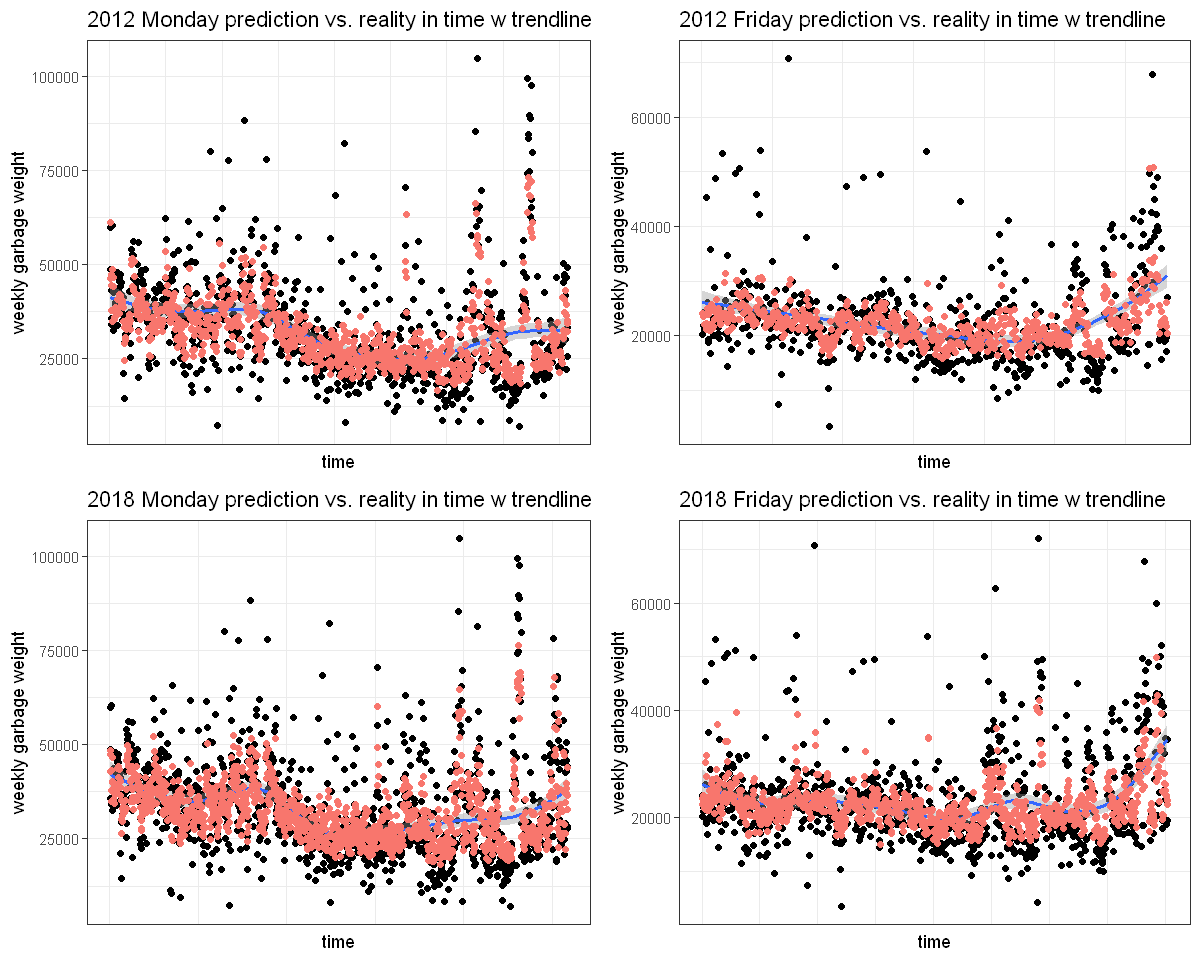

In [119]:
options(repr.plot.width=10, repr.plot.height=8)
gridExtra::grid.arrange(p_2012_M, p_2012_F, p_2018_M, p_2018_F, ncol=2)

In [120]:
rbind (XGB_stat_2012_, XGB_stat_2018_)

DataPoints,RMSE,AbsErrMin,AbsErrMed,AbsErrMean,AbsErr3rd,AbsErrMax,DataMin,DataMean,DataMax,DataSD,YearFrom,DayOfWk
1019,9641.575,2.0078125,4603.271,6617.020,8596.928,57190.39,7180.000,32309.74,104800,12983.771,2012,Monday
816,8376.852,23.2421875,3434.226,5320.946,6389.331,64128.41,5280.000,25814.82,95340,9666.562,2012,Tuesday
915,9085.153,0.7324219,4457.049,6174.458,8294.871,53295.89,1760.298,27138.83,83460,10004.425,2012,Wednesday
759,8251.306,3.7871094,3379.369,5317.912,6521.499,54813.42,2290.000,26879.30,83660,10338.252,2012,Thursday
660,6916.683,15.0957031,3144.737,4583.798,5755.251,48429.53,3480.000,22453.58,70700,7743.175,2012,Friday
1295,10145.934,6.3007812,5056.129,7122.255,9319.212,56741.10,7180.000,32512.73,104800,12774.346,2018,Monday
1123,8841.890,3.3652344,3792.811,5764.168,7021.102,64673.78,5280.000,26783.04,95340,10015.089,2018,Tuesday
1184,9461.409,0.8867188,4629.412,6476.086,8163.762,61434.99,1760.298,28027.11,89820,10622.672,2018,Wednesday
955,8613.693,3.8222656,3844.562,5672.869,6965.446,56300.11,2290.000,27542.22,83660,10807.955,2018,Thursday
1005,7608.330,15.4902344,3303.102,5021.907,6361.820,47967.27,3480.000,22889.14,72020,8411.086,2018,Friday


First noting the variation in the data. The maximum weekly garbage weight in an area might be even 50 times (!!) difference (see DataMin and DataMax relation for 2012 Wednesday). This is huge, and we are not sure if this is real or error in the data (can be wrong input, or can be some route name change, see earlier discussions about the lack of consistency in route names). 

There is quite a bit of a variation in test RMSE along the day of the week. There can be multiple reasons for it. One is that the "Friday" are is smaller than the other areas, which means that it is probably a more homogenous territory. Closely related to this potential reason is that maybe the number of "outliars" in this area is smaller than elsewhere (by outliar we mean here that garbage collections where the weight of the collected waste at one occassion is much higher than the yearly average, whether it be a data error or due to some special occassion in the city. In this analysis in one of the earlier steps we dropped those that were highrt than 4 times of the average, but still those that are 3.5 times higher might also not be normal, and likely distort the model).

The plots show that the prediction fairly well follow the trendline -and even some deviation from the trendline, see the right part of the plots- on the test set, but when it comes to extreme high or extreme low values, then it fails. The absolute mean error of the prediction (AbsErrMean) is ballpark half of the standard deviation of the actual weight values.

When included broader dataset (2012 - 2021H1), the error was 5% - 10% better than in 2018 - 2021H1. It was not for free, though: as the below plot shows, we lost a bit of the valid area (due to the criteria mentioned above and discussed in details in the "data wrangling" section). Why is the difference no bigger? We can offer a few possible explanations, such as the stationarity on such long period is not obvious at all, and again citing the inconsistency of routes (one can say that this is a very special case of not having stationarity).

The mean absolute error is about 20% - 25% of the mean target value, and ballpark half of the standard deviation of the test data. The question is of course wether this is good or bad. So let's discuss this a bit.

First, as said above a couple of times, we had certain concerns related to data quality. One symphtom is that there are a number of extreme values in the dataset (extreme high, or extreme low), and we are not sure if such extreme high and extereme low values are real ones or errors. We removed very few of such, only those that were 4 times higher than yearly average on the route. We had severe problems with routes, we found that different datasets have different routes, but an even bigger concern to us was that we found inconsistency in the existing route names, too. We found duplicate 'ID's, and in dominant cases we saw that the administration of an event took place before the actual event (record_date before load_time), sometimes almost 20 years before. All these did not build confidence in us on the data, and we really can not even guess if data showing that in an area the weekly minimum collected garbage was one 50th of the weekly maximum is real or error.

Second, let us be frank, we did not really have 'decent' data not in terms of quality but in terms of 'nature'. Our explanatory variables were barely more than historical and spatial weight information. Having better understanding on some local specialities (e.g. festivals, major construction works, garbage collection campaigns, etc.) could be valuable information greatly improving the model's accuracy. 


*Note: One can see that in some cases the 2018 maximum weekly weight data for an area is higher than in 2012, and one might ask how a subset (2018 - 2021H1) can contain higher value than a bigger set (2012 - 2021H1). The answer is that we set certain tough criteria to include a route in the data: garbage collection on the route had to happen minium 46 times a year throughout the entire period. Likely in cases where the maximum weekly weight is higher in the 2018-2021H1 scenario than in the 2012-2021H1 the route that contributed to the maximum value did not meet this criteria from 2012.*

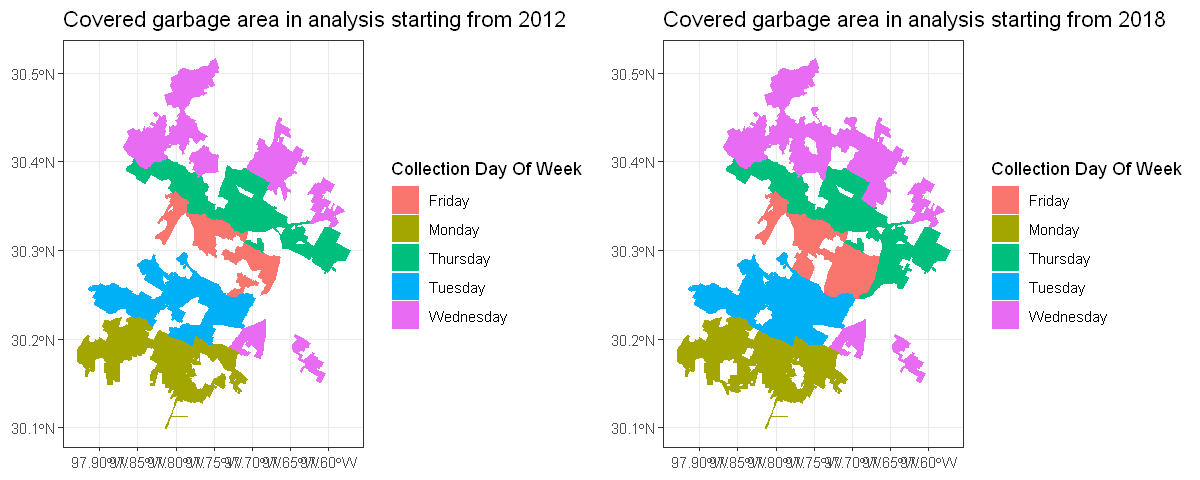

In [121]:
options(repr.plot.width=10, repr.plot.height=4)
gridExtra::grid.arrange(p_g_2012_, p_g_2018_, ncol=2)

**Variable Importance** 

Finally let us see which features impact the model. We already had one 2018 model saved above, let us quickly re-treain its corresponding 2021 pair to see how stabel the feature impoertance is.

The variable importance plots for the "Monday" collection area for 2012-2021H1 and 2018-2021H1, respectively are:

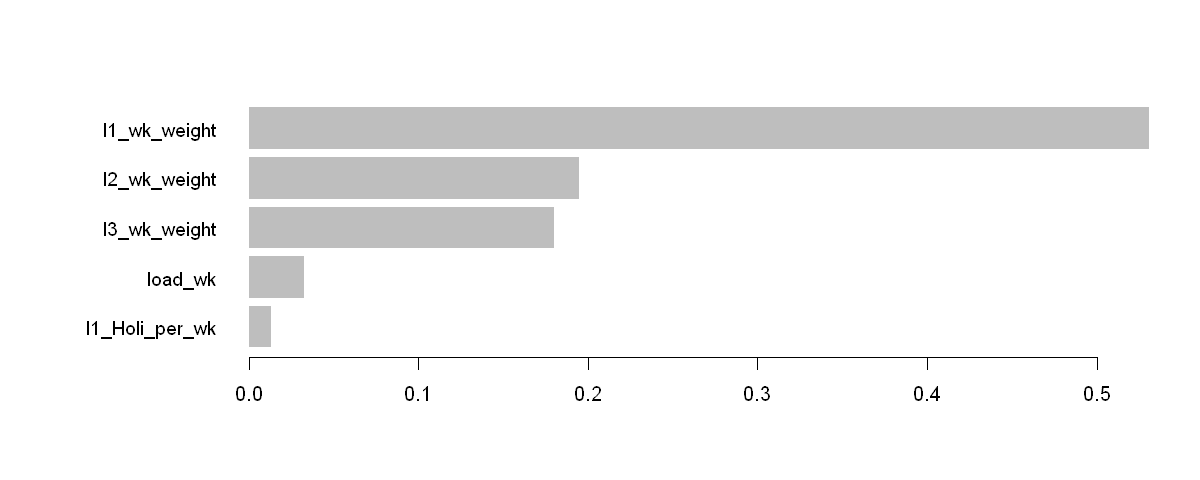

In [122]:
xgb.plot.importance(xgb.importance (model=bst_2012_Monday)[1:5])

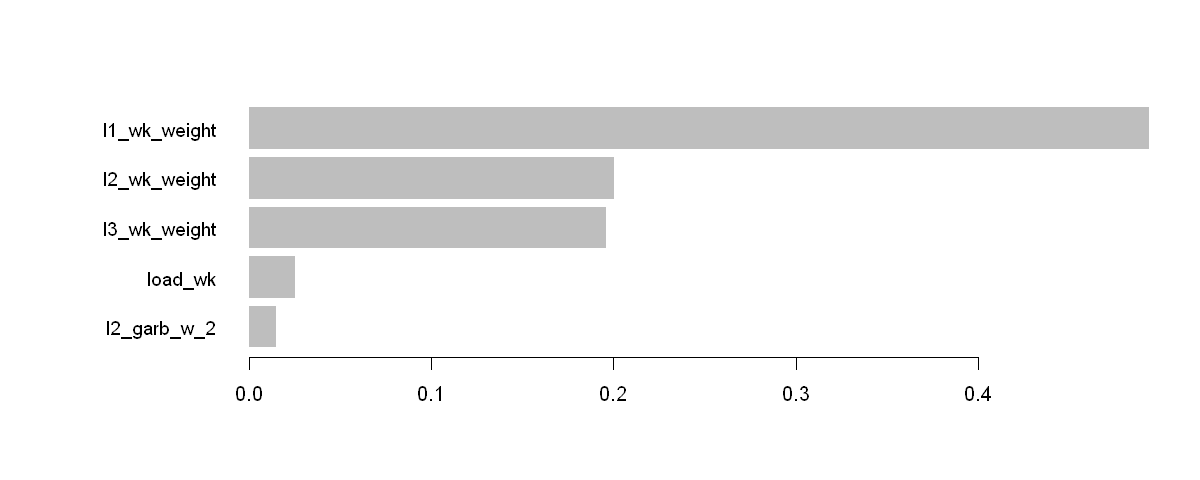

In [123]:
xgb.plot.importance(xgb.importance (model=bst_2018_Monday )[1:5])

We see that in the same region the 4 top most important variables are the same in both periods' model: these are the past 3 weeks garbage data of the same routes, then the number of week in the year controlling seasonality. 

Let us see if other areas differ from it. Below are the variable importance plots for the "Friday" collection areas for 2012-2021H1, and 2018-2021H1 periods, repsectively.

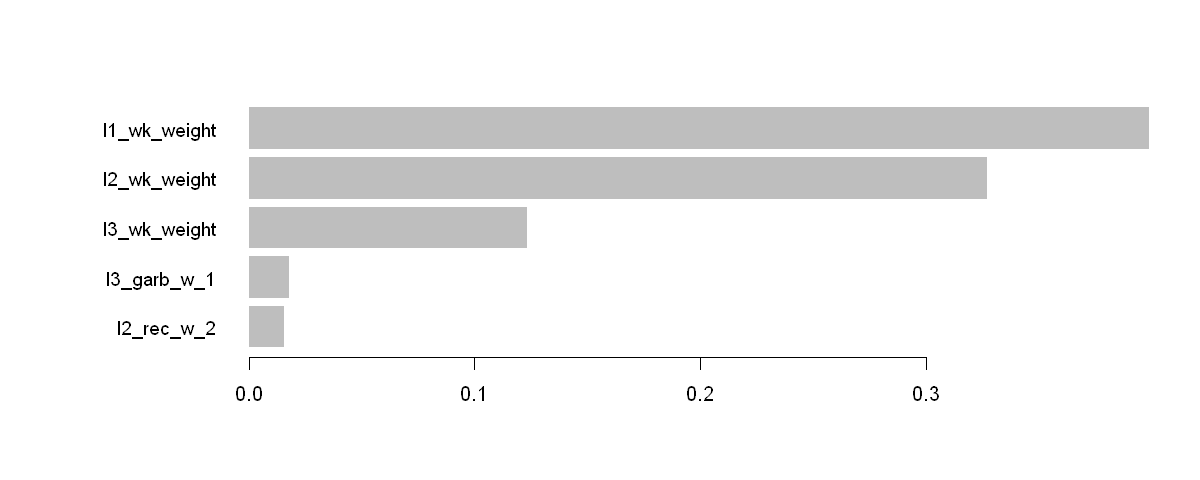

In [124]:
xgb.plot.importance(xgb.importance (model = bst_2012_Friday )[1:5])

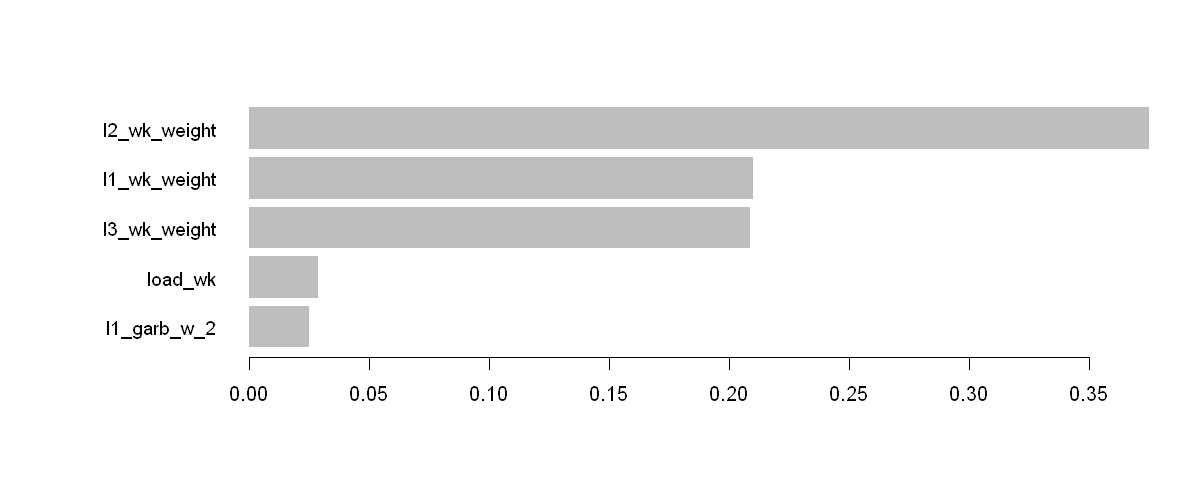

In [125]:
xgb.plot.importance(xgb.importance (model=bst_2018_Friday )[1:5])

The same ones are in the Top3.

**Some words about improving granularity, i.e. zooming from larger area to route level**

Natural question, would we have the same variables if we look at a more focused area, such as one route.

Similar plots and stats as for the area evaluation are given below.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


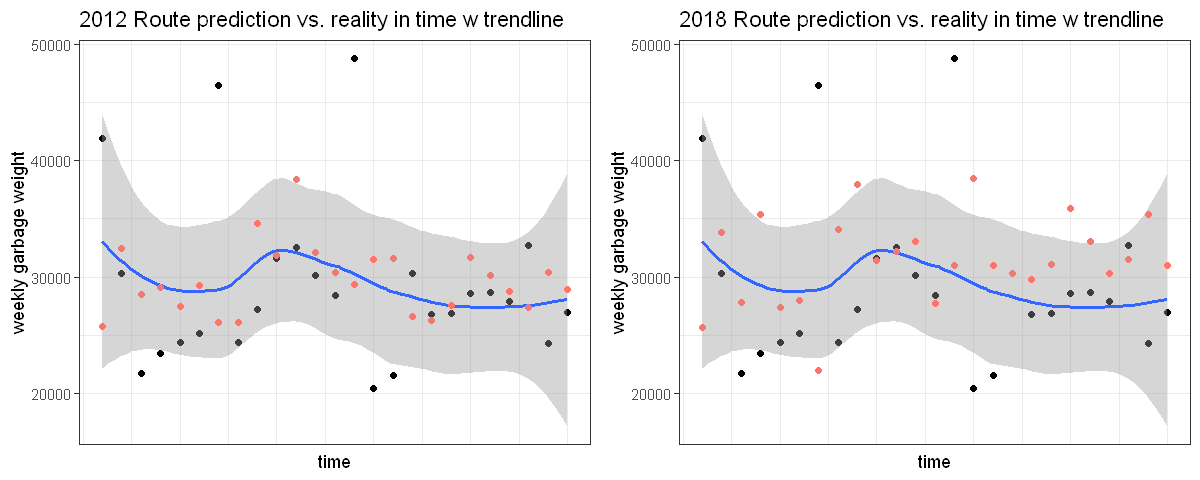

In [126]:
options(repr.plot.width=10, repr.plot.height=4)
gridExtra::grid.arrange(p_2012_R, p_2018_R, ncol=2)

In [127]:
s <- summary(abs(y_test_prob_vec_2018_R - label_test_2018_R$wk_weight))
RMSE <- sqrt(sum((y_test_prob_vec_2018_R - label_test_2018_R$wk_weight)^2 ) / nrow (label_test_2018_R))
AbsErrMean <- as.numeric(s["Mean"])
AbsErrMed <- as.numeric(s["Median"])
AbsErr3rd <- as.numeric(s["3rd Qu."])
AbsErrMax <- as.numeric(s["Max."])
AbsErrMin <- as.numeric(s["Min."])
DataMin <- min(label_test_2018_R$wk_weight)
DataMean <- mean(label_test_2018_R$wk_weight)
DataMax <- max(label_test_2018_R$wk_weight)
DataSD <- sd (label_test_2018_R$wk_weight)
Stat_18 <- data.frame (RMSE, AbsErrMin, AbsErrMed, AbsErrMean, AbsErr3rd, AbsErrMax, 
                        DataMin, DataMean, DataMax, DataSD, YearFrom = 2018)
                        

s <- summary(abs(y_test_prob_vec_2012_R - label_test_2012_R$wk_weight))
RMSE <- sqrt(sum((y_test_prob_vec_2012_R - label_test_2012_R$wk_weight)^2 ) / nrow (label_test_2012_R))
AbsErrMean <- as.numeric(s["Mean"])
AbsErrMed <- as.numeric(s["Median"])
AbsErr3rd <- as.numeric(s["3rd Qu."])
AbsErrMax <- as.numeric(s["Max."])
AbsErrMin <- as.numeric(s["Min."])
DataMin <- min(label_test_2012_R$wk_weight)
DataMean <- mean(label_test_2012_R$wk_weight)
DataMax <- max(label_test_2012_R$wk_weight)
DataSD <- sd (label_test_2012_R$wk_weight)
Stat_12 <- data.frame (RMSE, AbsErrMin, AbsErrMed, AbsErrMean, AbsErr3rd, AbsErrMax, 
                        DataMin, DataMean, DataMax, DataSD, YearFrom = 2012)
                        

In [128]:
rbind (Stat_12, Stat_18)

RMSE,AbsErrMin,AbsErrMed,AbsErrMean,AbsErr3rd,AbsErrMax,DataMin,DataMean,DataMax,DataSD,YearFrom
7969.512,218.74414,3671.178,5670.695,6809.898,20444.37,20440,29264,48800,7113.759,2012
9546.701,16.66602,4177.635,7038.918,10735.398,24542.04,20440,29264,48800,7113.759,2018


*Note: the reason for no change in DataMin, DataMean, DataMax, DataSD in the 2012 and 2018 rows in this table, while in the area table there was is that these columns describe the test set. In the arae table the number of routes making up the test set were different in the same period, as some routes did not even exist in 2012 that were part of the 2018 - 2021H1 data. We picked our route for the route level analysis in such a way that it met the criteria listed at the beginning of the chapter, so its test data (2021H1) is the same in the two analysis.*

The 2021-2021H1 and 2018-2021H1 variable importance plots for route "PAW74" are below in this order:

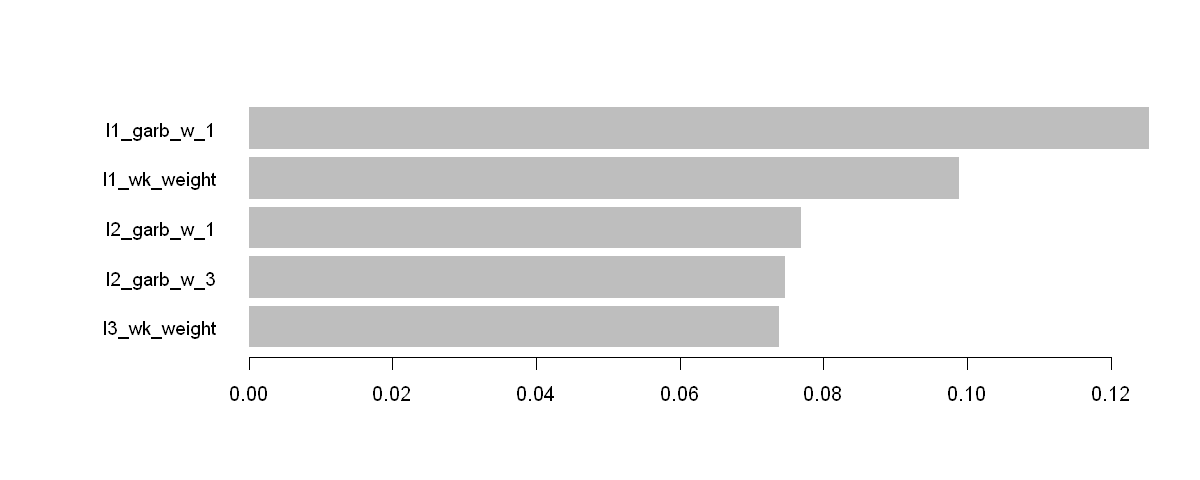

In [129]:
xgb.plot.importance (xgb.importance (model = bst_2012R )[1:5])

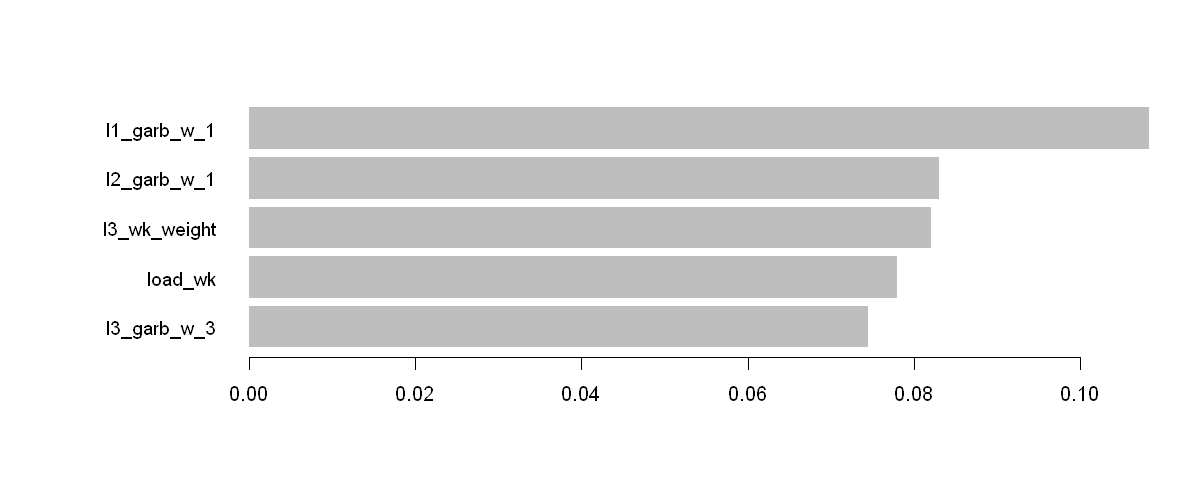

In [130]:
xgb.plot.importance (xgb.importance (model = bst_2018R )[1:5])

We can see two major differences compared to the larger area results:

- Here we do see that the models rely more on the neighbor route's historical data. In both period the strongest variable was the past (lag 1) garbage transport weeekly weight from the closest garbage neighbor (l1_garb_w_1 means: l1 like lag 1, garb means that garbage route neighbor, w_1 means that closest (1st in distance)).

- The models seem to be less "time invariant", i.e. only the Top1 is common in the 2012-2021H1 and 2018-2021H1 models.

Both make sense: in a smaller area the model is sharpened on one route, so the neighbor's traffic should count more than in a larger area. Also, the "sharper" the model the more sensitive it is to changes, which inevitably is seen over time.

So the question remains: are we gaining anything on a more granular albeit more sensitive (probably less stable) model? Looking at the summary table above, it looks that not really. The error to test data mean and test data standard deviations are not improved compared to the area wide analysis.

### Potential saving with the model

With the model the Waste Management authority can optimize transports, i.e. making sure to allocate just as many trucks as needed to collect and transport the waste from an area during garbage collection.

What we can say is that ideally there would be no need for repetitive collection on any route due to not allocating enough capacity on the due data of the garbage collection. 

This is a bit brave assumption, but if we assume that in the data repeated collection on the same route on the same week are due to wrongly allocated capacity, then this could be the upper limit for this saving.

This is calculated for 2020.

In [131]:
dt %>% filter (route_type == "GARBAGE COLLECTION") %>%
   filter (year == 2020) %>%
   mutate (DOW = strftime (load_time, "%W")) %>%
   group_by (route_number, DOW) %>%
   summarise (rounds_per_week = n()) %>%
   filter (rounds_per_week > 1) %>%
   ungroup() %>%
   summarise (repetitions = sum(rounds_per_week) - n())

`summarise()` has grouped output by 'route_number'. You can override using the `.groups` argument.


repetitions
5220


The upper limit is 5220 rounds (based in 2020 data). This is not real saving yet, as these collections must take place, but with better allocation there is no need to re-schedule extra collection on the same routes on other dates of the week. How this is translated to money, this would require deeper understanding on Austin's waste management.

***

### 6. Long term causality analysis

As said above, we had a two-fold intention:

1. To create a short term model that gives a tool to Austin's Waste Management dept. to optimize their current activities, enable faster / cheaper collection, and with this helping in handling waste (kind of practical approach).

2. To create a more long term analytical model to examine what social, economical, etc. factors cause changes in waste production (kind of academic approach).


This chapter is about the second goal, i.e. doing Time Series analysis to establish causal relationship between one or more explanatory variables and target variable.

Our approach was the following:

- As any city, Austin is not homogenous. Therefore split Austin to smaller areas, and create a more fine granular panel data. Our assumption was that splitting up Austin to zip code areas makes sense, because it creates more homogenous smaller areas, while -as we assumed- probably there are social, economical, etc. data available on zip code area level.

- We selected two possible target variables: waste load in GARBAGE COLLECTION and waste load in RECYCLING - SINGLE STREAM.

- We assigned routes to zip codes based on the following principles:
    
    - Assigned routes must existed in the master waste database throughout the entire analysis period,
    
    - We only looked at those zip codes where the zip area is "well" covered with such routes. We set up a threshold (70%), and used this as a coverage criteria to accept any zip on the panel data/
    
    - Route assignment to a zip area is based on territorial overlapping (.e.g if route_A area is say 40% in zip_X and 60% in zip_Y, then waste reported in this route is 40% counted to zip_X and 60% to zip_Y)
    
- We collected macro variables 

- Finally, do Time Series analysis with the following four model types:

    - Multiple OLS model,
    - First Difference (FE) model,
    - Fixed Effect (FE) model,
    - Long Differences (LD) model
    
 Unfortunately, before we could start the essence (last step), we realized two problems, which we did not foresee at start:
 
 - The zip level data we found in the 'https://data.austintexas.gov/' page and at first glance seemed very promising turned out to be useless. Actually we found none of the datasets in this huge database that had decent quality samples for all Austin zips for the entire analysis period.
 
 - Then we extended our search to several external free public databases. We found bits and pieces, even at first glance they seemed to be vague. Nevertheless, before we even set up a hypothesis on which one could impact waste production, we run a multicollinearity test, and found that the variables that we found in so much struggle are miserably multicollinear. This was the point where we gave up this long term approach.
 
Though we abandoned this track, the details of this long term approach are still part of this study as there has been lot of effort put into it.

Our starting point is the 'Daily Waste Collection Data for Austin' dataset, also referred in this study as master dataset.

In [132]:
# Re-set figure width / height
options(repr.plot.width=10, repr.plot.height=4)

#### 6. 1. Adding zip code data

Our idea was that Austin is not a homogenous city, probably there are areas residential areas, industrial areas, re-creational areas, etc., and in these areas the waste amount and recycling impacting factors are different.

According to our understanding, the purpose of the exercise is to create a causal model. Our intention is to cretae a zip based panel data for that purpose.

In [133]:
url_geojson <- "https://github.com/OpenDataDE/State-zip-code-GeoJSON/raw/master/tx_texas_zip_codes_geo.min.json"
mpdata <- sf::st_read (url_geojson)

Reading layer `tx_texas_zip_codes_geo.min' from data source `https://github.com/OpenDataDE/State-zip-code-GeoJSON/raw/master/tx_texas_zip_codes_geo.min.json' using driver `GeoJSON'
Simple feature collection with 1939 features and 11 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -106.6456 ymin: 25.83716 xmax: -93.50804 ymax: 36.5007
Geodetic CRS:  WGS 84


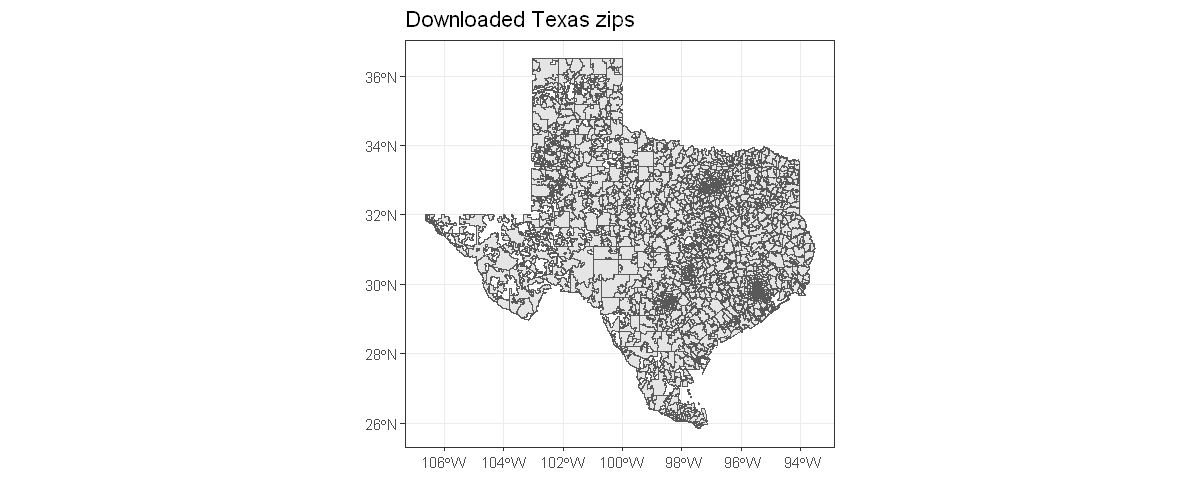

In [134]:
# This cell replaces the cell below leaflet cell due to jupyter -> html leaflet rendering probleem

ggplot () + geom_sf (data = mpdata) + theme_bw() + labs (title = "Downloaded Texas zips") 

In [135]:
# cell disabled due to jupyetr html rendering problem. OK in notebook but not when rendered to html. Replaced w. geom_sf above

#leaflet(data = mpdata[201:300,]) %>% 
#     addProviderTiles(providers$OpenStreetMap.DE) %>%   # For some reason this was needed in order to add map in Jupyter
#     addTiles() %>%   # sometimes have to open in new window (top left) in order to work in rstudio
#     addPolygons() 

In order to limit this data to Austin only, we read the bounding box coordinates from one of the Asutin specific map (let it be recycling-route map data), and crop this Texas zip code data based on the Austin bounding box.

In [136]:
bbx <- st_bbox(rec_mapdata)
bbox = c(xmin = bbx[['xmin']], ymin = bbx[['ymin']], xmax = bbx[['xmax']], ymax = bbx[['ymax']])
aus_mapdata <- st_crop (mpdata, bbox)

although coordinates are longitude/latitude, st_intersection assumes that they are planar


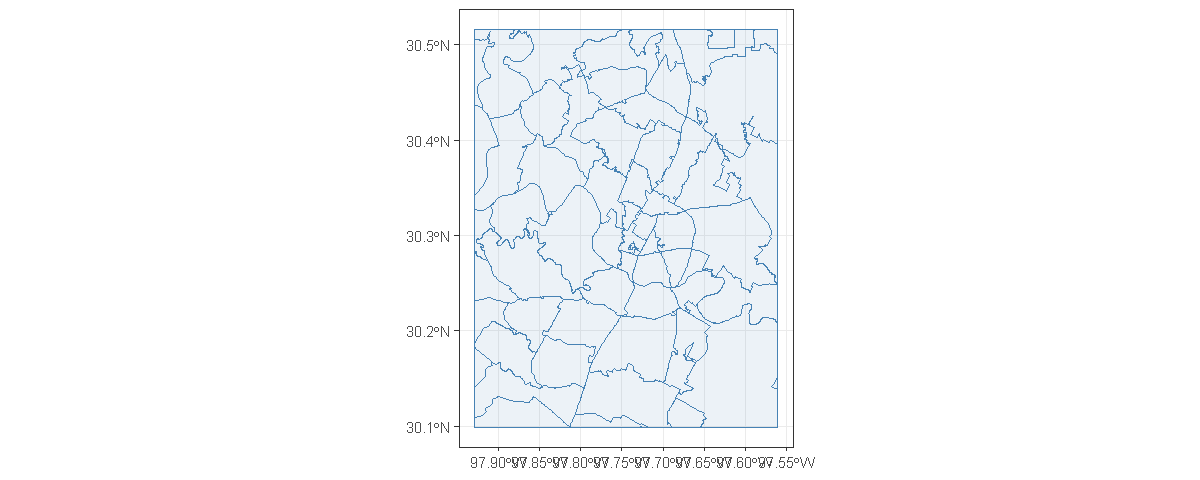

In [137]:
# This cell replaces the cell below leaflet cell due to jupyter -> html leaflet rendering probleem

ggplot() + geom_sf(data = aus_mapdata, alpha=0.1, fill = "steelblue", color = "steelblue") + 
   theme_bw() + labs ("Austin zip codes extracted")

In [138]:
# cell disabled due to jupyetr html rendering problem. OK in notebook but not when rendered to html. Replaced w. geom_sf above

#leaflet(data = aus_mapdata) %>% 
#     addProviderTiles(providers$OpenStreetMap.DE) %>%   # For some reason this was needed in order to add map in Jupyter
#     addTiles() %>%   # sometimes have to open in new window (top left) in order to work in rstudio
#     addPolygons()

By visual observation there seems to be no overlapping areas. We do no need EDA, we just hope that these areas do correspond to real zip areas.

Checking garbage route - zip code overlapping

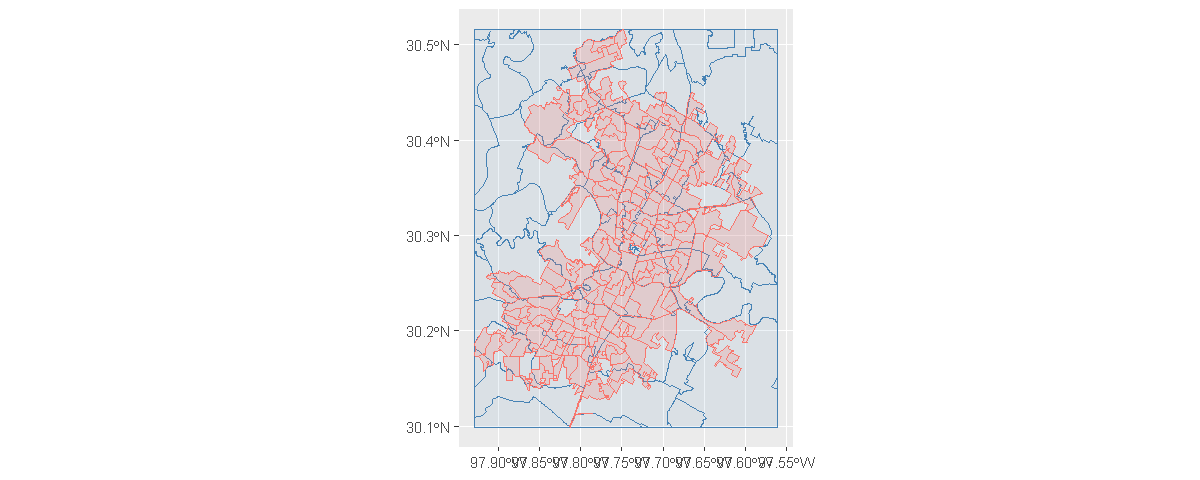

In [139]:
ggplot() + geom_sf(data = aus_mapdata, alpha=0.1, fill = "steelblue", color = "steelblue") + 
geom_sf (data = garb_mapdata, alpha = 0.2, fill="#f8766d", color = "#f8766d")

Conclusion: Visible on the above plot (and kind of as expected), that there is no clear 1:n relationship between zip codes and routes. Typical scenario is that routes belong to more than 1 zip area.

Therefore when we analyze Austin on zip code level, we need to assign routes to zip codes in such a way that takes into account this "overstretching route" phenomenon. Therefore the way we assign route data to zip codes (in both the garbage and the recycle route cases) is to allocate data based on the geographical overlapping. Meaning that if route "BP" area's 40% belongs to zip "X" and 60% to zip "Y", then we will assign waste related quantities of route "BP" to zip "X" in 40% and to zip "Y" in 60%. Once it is done we will do some filtering (see later) and ready to go for the causal analysis.

#### 6.2. Add territorial areas to zip codes and routes

In [140]:
garb_mapdata$rt_area <- st_area(garb_mapdata)
rec_mapdata$rt_area <- st_area (rec_mapdata)
aus_mapdata$zip_area <- st_area(aus_mapdata)

#### 6.3. Collecting zip - route overlapping areas in matrix

For this we reuse the 'calc_overlap_mx' function created before for checking polygon uniqueness in geomery feature EDA.

In [141]:
# overlapping garbage roue - zip areas
zip_rt_garb_mx <- data.frame(calc_overlap_mx (aus_mapdata, garb_mapdata))
colnames(zip_rt_garb_mx) <- aus_mapdata$ZCTA5CE10
zip_rt_garb_mx$route_name <- garb_mapdata$garb_rt

although coordinates are longitude/latitude, st_intersects assumes that they are planar


*Sanity check of calculating zip and garbage-route area overlapping*

*We select 10 random garbage route names, and get the geographical areas of them from the calculated area overlapping matrix.*

*Then for these same 10 routes we go through the overlapping matrix and add up the route-zip overlapping area, and check if the results are the same.*

*The result speaks for itself: just some negligeable round error in Units [m^2].*


In [142]:
# select 10 routes by position in garbage route table
test_rt_nos <- round(runif(10, min=1, nrow(garb_mapdata)))

# check if route name assignment to the matrix is correct
garb_mapdata$garb_rt [test_rt_nos] %>% as.character()
zip_rt_garb_mx %>% dplyr::slice (test_rt_nos) %>% select (route_name) %>% pull() %>% as.character()

# check if summing up zip-route verlapping areas adds up to the route area
overlaps_added <- zip_rt_garb_mx %>% dplyr::slice (test_rt_nos) %>% select (-route_name) %>% mutate (total = rowSums(.)) %>% select (total) %>% pull()
overlaps_added - garb_mapdata$rt_area [test_rt_nos] %>% as.integer()

[1] "PM12"  "PAW74" "PAT72" "PAW84" "PAH73" "PAM81" "PAM84" "PAW04" "PAF73"
[10] "PAW80"

[1] "PM12"  "PAW74" "PAT72" "PAW84" "PAH73" "PAM81" "PAM84" "PAW04" "PAF73"
[10] "PAW80"

[1] -1  1  0  0 -1 -1 -2  0  0  0

In [143]:
# overlapping recycle route - zip areas
zip_rt_rec_mx <- data.frame(calc_overlap_mx (aus_mapdata, rec_mapdata))
colnames(zip_rt_rec_mx) <- aus_mapdata$ZCTA5CE10
zip_rt_rec_mx$route_name <- rec_mapdata$route_name

although coordinates are longitude/latitude, st_intersects assumes that they are planar


#### 6.4. Calculate what percentage a route belong to a zip

For assigning waste data to zip codes we need what percentage a route belongs to a given zip code. This is calculated now based on the just obtained area overlapping.

For each route we go through all zip codes, and calculate the overlapping area fraction compared to the routes total area.

In [144]:
# % allocation of garbage routes to zip (e.g. route 'BP' belongs to zip 'X' in 40% and to zip 'Y' in 60%)
rt_to_zip_garb <- zip_rt_garb_mx %>%
  pivot_longer (-route_name, names_to = c("zip"), values_to = "area") %>%
  filter (area > 0) %>%
  group_by(route_name) %>%
  mutate(area_rt_Tot= sum(area)) %>%
  group_by(zip, add=TRUE) %>%
  mutate(frac=area/area_rt_Tot) %>%
  ungroup()

In [145]:
# % allocation of recycling routes to zip (e.g. route 'BP' belongs to zip 'X' in 40% and to zip 'Y' in 60%)
rt_to_zip_rec <- zip_rt_rec_mx %>%
  pivot_longer (-route_name, names_to = c("zip"), values_to = "area") %>%
  filter (area > 0) %>%
  group_by(route_name) %>%
  mutate(area_rt_Tot= sum(area)) %>%
  group_by(zip, add=TRUE) %>%
  mutate(frac=area/area_rt_Tot) %>%
  ungroup()

*Sanity check of calculating what % of routes belong to zips*

*Below for all routes calculating the routes total areas by summing the product of the calculated % values and the route total area, then checking the result against the route total area obtained from the map data.*

*The below result show that this is just some negligeable rounding errors*

In [146]:
rt_to_zip_garb %>%
  group_by (route_name) %>%
  summarise (area_rt_Tot = sum(frac*area_rt_Tot)) %>%
  left_join (garb_mapdata, by = c("route_name" = "garb_rt")) %>%
  mutate (error = abs(area_rt_Tot - as.integer(rt_area))) %>%
  select (error) %>% sum()

[1] 317

#### 6.5. Filter out routes that did not exist during the entire period of the analysis

Now we have the zip codes and the zip - route area overlapping.

When we do a zip based analysis, we need to be sure that zip codes have good data representation. We consider two main criteria:

- Routes that make up the zip code existed throughout our analysis period (e.g. analyzing from 2010 to 2020, routes we consider are present in the master waste dataset in every year from 2010 to 2020). These are the "valid" routes.

- When we collect all such routes, then the geographical territory of the zip is "well" covered by the "valid" routes, meaning that the overlapping area of the zip and all the valid routes exceeds a certain threshold. These are the valid zips.

We will perform our filtering based on these criteria.

We leave in only those routes that is present in the master data in every single year covered by our analysis

In [147]:
FirstYear <- 2010
LastYear <- 2020

In [148]:
# select garbage routes that were on the map and existed all the years -> good_garb_rts
good_garb_rts<- rt_to_zip_garb %>% left_join (dt, by = c("route_name" = "route_number")) %>%
   filter ( (year>= FirstYear) & (year <= LastYear)) %>%
   distinct (route_name,year) %>%
   group_by (route_name) %>%
   summarise (First = min(year), Last = max(year), Appearance = n()) %>%
   filter ( (First == FirstYear) & (Last == LastYear) & (Appearance  == LastYear - FirstYear +1))

In [149]:
# select recycle routes that were on the map and existed all the years -> good_rec_rts
good_rec_rts<- rt_to_zip_rec %>% left_join (dt, by = c("route_name" = "route_number")) %>%
   filter ( (year>= FirstYear) & (year <= LastYear)) %>%
   distinct (route_name,year) %>%
   group_by (route_name) %>%
   summarise (First = min(year), Last = max(year), Appearance = n()) %>%
   filter ( (First == FirstYear) & (Last == LastYear) & (Appearance  == LastYear - FirstYear +1))

Modify zip - route mapping table to only include routes that were filtered in the previous step.

In [150]:
# garbage routes that existed all the analysis years with their zip codes and % they belong to this zip -> rt_to_zip_garb_adj1
rt_to_zip_garb_adj1 <- good_garb_rts %>% left_join (rt_to_zip_garb)

Joining, by = "route_name"


In [151]:
# recycle routes that existed all the analysis years with their zip codes and % they belong to this zip -> rt_to_zip_rec_adj1
rt_to_zip_rec_adj1 <- good_rec_rts %>% left_join (rt_to_zip_rec)

Joining, by = "route_name"


#### 6.6. Remove zips where the areas covered by these 'valid' routes is much smaller than a threshold (i.e. large areas of the zip are not covered by valid routes)

Collect those zips where the zip area is decently covered by valid routes.

In [152]:
Threshold <- 0.7

In [153]:
# collect zips where zip area is well covered by valid garbage routes -> good_garb_zips
good_garb_zips <- rt_to_zip_garb_adj1 %>% 
   group_by (zip) %>% 
   summarise (Covered_Zip_Area = sum(area)) %>% 
   
   left_join (aus_mapdata, by = c("zip" = "ZCTA5CE10")) %>%
   filter (Covered_Zip_Area >= as.integer(zip_area) * Threshold) %>%
   select (zip)

In [154]:
# collect zips where zip area is well covered by valid recycle routes -> good_rec_zips
good_rec_zips <- rt_to_zip_rec_adj1 %>% 
   group_by (zip) %>% 
   summarise (Covered_Zip_Area = sum(area)) %>% 
   
   left_join (aus_mapdata, by = c("zip" = "ZCTA5CE10")) %>%
   filter (Covered_Zip_Area >= as.integer(zip_area) * Threshold) %>%
   select (zip)

In [155]:
cat("Valid zips for garbage: ", good_garb_zips$zip)
cat ("\n")
cat("Valid zips for recycle: ", good_rec_zips$zip)

Valid zips for garbage:  78701 78703 78704 78705 78721 78731 78745 78749 78750 78751 78752 78753 78756 78757 78758
Valid zips for recycle:  78701 78702 78705 78723 78741 78751 78753

Limit the zip - route mapping matrix to include this threshold criteria:

In [156]:
# garbage routes that existed all the analysis period and their zip is "well covered" by garbage routes meeting this criteria
rt_to_zip_garb_adj2 <- good_garb_zips %>% left_join (rt_to_zip_garb_adj1)

Joining, by = "zip"


In [157]:
# recyc routes that existed all the analysis period and their zip is "well covered" by garbage routes meeting this criteria
rt_to_zip_rec_adj2 <- good_rec_zips %>% left_join (rt_to_zip_rec_adj1)

Joining, by = "zip"


Now we have those routes and zips and their overlapping relation in rt_to_zip_garb_adj2 and in rt_to_zip_rec_adj2 that meet the criteria of:

- routes existed throughout the analysis period

- Good enough portion of zip -defined by a threshold- is covered by such routes. 

#### 6.7. Adding zip economic data

Using the API of census.gov site we collected the following zip level data:

- Annual payroll ($1,000)

- Number of employees

- Number of establishments of various sizes (e.g. from 1 to 4, from 5 to 9, ..)

More details are available at https://api.census.gov/data/2017/zbp/groups/CB1700ZBP.html.


The below functions collect some macro data for zips. Works between 2006 to 2019.


In [158]:
# fetch_4_zip():    scrapes one year - one zip data
# fetch_all_zips(): works through a list of zips and calls fetch_4_zip to fetch all those zip-s for given year

fetch_4_zip <- function (zip, year) 
{
   if (year == 2017)
   {
      link <- paste0("https://api.census.gov/data/2017/zbp?get=EMP,EMPSZES,EMPSZES_LABEL,PAYANN,ESTAB&for=zipcode:", zip)
   }
   else if (year %in% c(2018,2019))
   {
      link <- paste0("https://api.census.gov/data/", year, "/cbp?get=EMP,EMPSZES,EMPSZES_LABEL,ESTAB,PAYANN,EMP&for=zip%20code:", zip)
   }
   else
   {
      link <- paste0("https://api.census.gov/data/",year, "/zbp?get=EMP,EMPSZES,EMPSZES_TTL,PAYANN,ESTAB&for=zipcode:",zip )
   }
   return (read.csv(link))
}

fetch_all_zips <- function (zips, year)
{
   do.call(rbind, lapply (zips, function(zip) fetch_4_zip(zip, year)))
}
                          

In [159]:
# clean_4_zip(): cleans data, must be done because 1. format changes over years, 2. there are "noise characters" in data
# works on a dataframe collected in by fetch_all_zip()

clean_4_zip <- function (zip_macro_data)
{
    zipcode_col = grep ("^zip*", names(zip_macro_data), value = TRUE)
    label_col = grep ("^EMPSZES_", names(zip_macro_data), value = TRUE)
    
    zip_macro_data %>% 
      rename_with (.col = label_col, ~'EMPSZES_TTL') %>%                # in recent files called EMPSZES_LABEL
      mutate (EMPSZES_TTL = as.character (EMPSZES_TTL), 
              PAYANN = as.numeric(as.character(PAYANN))) %>%
      mutate (EMPSZES_TTL = gsub ("less than 5", "1 to 4",  EMPSZES_TTL)) %>%  # cat. differs in recent yrs
      rename_with (.col = zipcode_col, ~'zipcode.') %>%                 # name sometimes zip.code., sometimess zipcode.
      mutate (zipcode = gsub('\\D+','', as.character(zipcode.))) %>%    # remove non digits
      mutate (zipcode = as.numeric(zipcode)) %>%
      mutate (AllEmpl = gsub('\\D+','', as.character(X..EMP))) %>%      # remove non digits
      mutate (EMP =0 ) %>%                                              # In some fils EMP added, in some not
      mutate (AllEmpl = as.numeric(AllEmpl)) 
}


In [160]:
# tidy_4_zip(): creates wide (tidy) format and adds year info. Works on a cleaned zips - oneyear data frame

tidy_4_zip <- function (zip_macro_data_clean, yr)
{
   oldnames <- zip_macro_data_clean %>% 
      filter (substr (EMPSZES_TTL,1,3) != "All") %>% 
      distinct (EMPSZES_TTL) %>% 
      pull()
   
   newnames <- sub(' employees','',oldnames) %>% sub ('Establishments with', 'E',.)
    
   zip_macro_data_clean %>% select (-X, -EMPSZES, -zipcode., -X..EMP, -EMP) %>% 
      group_by (zipcode) %>%
      mutate (PAYANN = nth(PAYANN, 1, order_by = -PAYANN)) %>%
      mutate (AllEmpl = nth(AllEmpl, 1, order_by = -AllEmpl)) %>%
      mutate (year = yr) %>%
      ungroup() %>%
      pivot_wider (names_from = c(EMPSZES_TTL), values_from = c(ESTAB)) %>%
      rename_with(.col = oldnames, ~ newnames)
}


In [161]:
# One_year_macro(): wrapper for all above functions

One_year_macro <- function (zips, year)
{
    zip_macro_data <- fetch_all_zips (zips, year)
    zip_macro_data_clean <- clean_4_zip (zip_macro_data)
    tidy_4_zip (zip_macro_data_clean, year)
}


Scrape macro data for all relevant zips for all relevant years

In [162]:
macro_data <- do.call(rbind, lapply (seq (FirstYear, 2019), function(year) One_year_macro (good_garb_zips$zip, year)))

Note: Using an external vector in selections is ambiguous.
i Use `all_of(label_col)` instead of `label_col` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
i Use `all_of(zipcode_col)` instead of `zipcode_col` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
i Use `all_of(oldnames)` instead of `oldnames` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


#### 6.8. Adding zip census data

In [163]:
library(rvest)
suppressMessages(library (tidyverse))
library (stringr)
zipcodes_austin_tx <- read_html("https://www.zipdatamaps.com/zipcodes-austin-tx")

In [164]:
### Obtain Austin zipcodes
zip_austin <- 
  tibble(
    zipcode = zipcodes_austin_tx %>% 
      html_node(xpath = "//meta[@name='keywords']") %>% 
      html_attr("content") %>% 
      str_split(",") %>% 
      unlist() %>% 
      str_squish()
    ) %>%

  mutate(zipcode = as.integer(zipcode)) %>%
  filter(!is.na(zipcode))

In [165]:
austin_zip_population <- 
  zipcodes_austin_tx %>% 
  html_elements(xpath = "//div[@class='col-md-12 column']") %>% 
  html_table() %>% 
  pluck(2) %>%
  janitor::clean_names() %>% 
  select(starts_with("x")) %>% 
  filter(!is.na(x)) %>%
  rename_with(~ c("zipcode", "name", "population", "type"))

In [166]:
get_one_zip <- function(zipcode) {
  Sys.sleep(runif(1, 3, 7))
  
  one_zip_hmtl <- read_html(paste0("https://www.zipdatamaps.com/", zipcode))
  
  one_zip_hmtl   %>%
    html_elements(xpath = "//table[@class='table table-striped table-bordered table-hover table-condensed']") %>%
    html_table() %>%
    pluck(2) %>%
    rename_with(~ c("population", "2010", "2020")) %>%
    
    mutate(across(everything(), as.character)) %>%
    pivot_longer(starts_with("2"), names_to = "year", values_to = "values") %>%
    mutate(header = paste(population, year), .keep = "unused") %>%
    pivot_wider(everything(), names_from = header, values_from = values) %>%
    janitor::clean_names() %>%
    mutate(across(starts_with("total"), as.integer)) %>%
    mutate(across(-starts_with("total"), parse_number),
           across(-starts_with("total"), ~ ./100))  
    # mutate(zipcode = one_zip, .before = 1)
  }

In [167]:
zip_pop <- good_garb_zips %>%
   mutate(data = map(zip, get_one_zip)) %>%
   unnest(data) %>%
   select (zip, starts_with("total_p")) %>%
   rename_at(.vars = vars(starts_with ("total")), .funs = funs(gsub('\\D+','',.)))

The scraped data is 2010 and 2020 census. As there is no census precision data for the other years, population for years before 2010 and between 2010 - 2020 are extrapolated below.

In [168]:
zip_pop <- zip_pop %>%
   add_column(!!!setNames(rep(NA, 5), seq(2005,2009))) %>%
   add_column(!!!setNames(rep(NA, 9), seq(2011,2019))) %>%
   pivot_longer (-zip, names_to = "year", values_to = "Population") %>%
   mutate (year = as.numeric(year)) %>%
   group_by (zip) %>%
   mutate( slope = (nth (Population, 16, order_by = year) - nth (Population, 6, order_by = year)) / 10 ) %>%
   mutate (Population = round(nth(Population, 6, order_by = year) + (year - nth (year,6, order_by = year) ) * slope,0)) %>%
   select (-slope)

Merging zip census and zip macro economic data in order to create the explanatory set:

In [169]:
final_macro <- macro_data %>% 
   left_join (zip_pop %>% mutate (zipcode = as.numeric(zip)), by = c("zipcode" = "zipcode", "year"="year")) 

Now we are just one step away from creating the panel data for the Time Series analysis. 

Just as recap:

- Target Variable: load_weight per zip per year

- Only zips are included that met the criteria in chapter 5 (minimum 70% of zip area is covered by garbage routes which existed in every year of the analysis period)

Tables used for creating the panel dataset for garbage data:



final_macro &emsp; &emsp; &emsp;&emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; rt_to_zip_garb_adj2 &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; dt <br>
*(with explanatory*  &emsp; &emsp; -- zip join --> &ensp; &ensp; *(with routes, zips and*  &emsp; &emsp; &emsp; -- garbage route join --> &emsp; *(waste data)* <br>
*vars on zip level)* &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &ensp; &nbsp; *route-zip overlaps)*

Before doing this, let us check if our zip level social - economic variables are independent.

Multicollinearity check of collected zip level macro data before doing the Time Series Analysis

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


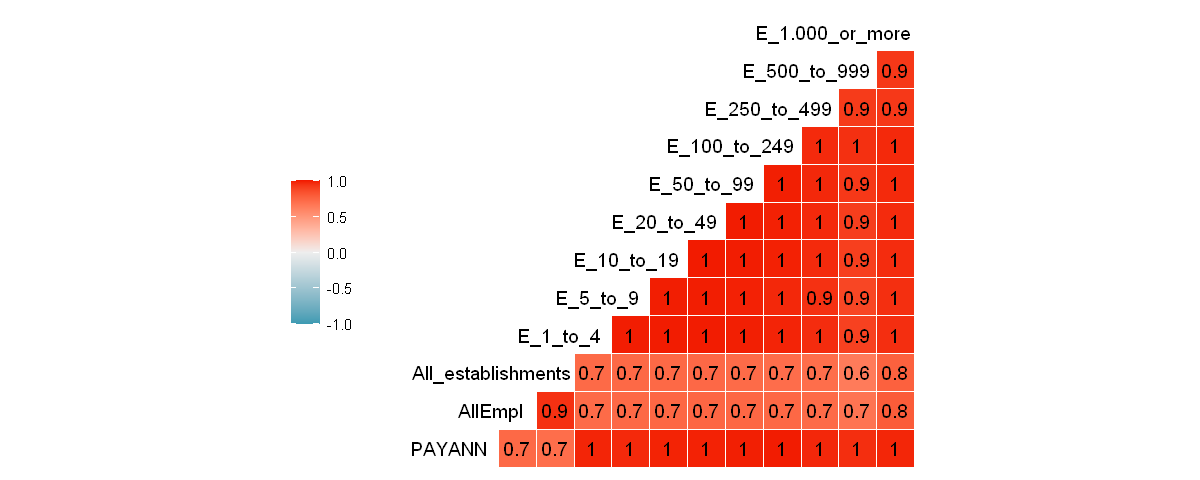

In [170]:
library (GGally)

final_macro %>% 
   mutate_at(vars(starts_with ("E"), starts_with ("P"), starts_with ("All")), funs(. / Population)) %>%
   select (-c(zip, zipcode, year, Population)) %>%
   ggcorr (label = TRUE, hjust = 0.9, size =4,legend.position = "left", layout.exp = 2)

"Austin, we have a problem":

**Conclusion:**

Not only that we have a very vague set of explanatory variables, they are heavily correlated.

We cannot run Time Series Analysis with these.

***

## 🖼️ Visualisations
Copy here the most important visualizations (graphs, charts, maps, images, etc). You can refer to them in the Executive Summary.

Technical note: If not all the visualisations are visible, you can still include them as an image or link - in this case please upload them to your own repository.

## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.

## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.


***

### Further analysis related to chapter 2. 'Daily Waste Collection Data for Austin' dataset

**Plots related to 'record_date' - 'load_time' weird relation analysis**

This is an extra plot showing report_date - actual_date distribution when we exclude those cases (90% of datapoints) where report_date occurred one day prior to the load.

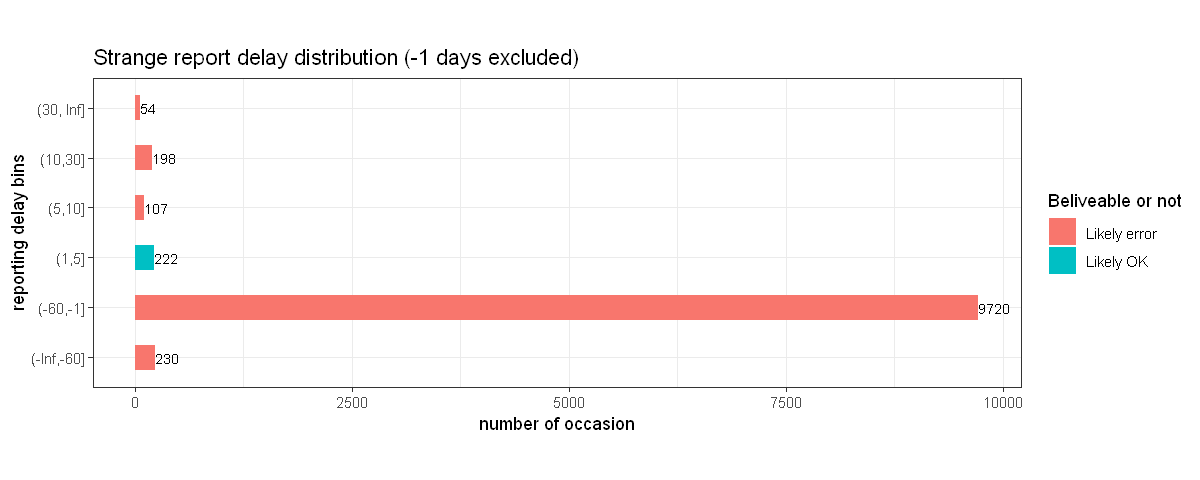

In [171]:
dt %>%
  mutate (report_delay_date = as.numeric(`report_date` - cr_date, unit = "days")) %>%
  filter (report_delay_date < -1 | report_delay_date > 1) %>%
  mutate (delay_bins = cut(report_delay_date, c(-Inf, -60, -1, 1, 5, 10, 30, Inf  ))) %>%
  #group_by(delay_bins) %>% summarise (n())
  ggplot (aes(delay_bins, fill = (report_delay_date >= -1 & report_delay_date <=5 ))) + 
  geom_bar( width = .5) + 
  geom_text (aes(y=..count.., label=..count..), stat="count", hjust = 0, size=3) +
  theme_bw() + theme(aspect.ratio = 1/3) + coord_flip() +
  labs (title = "Strange report delay distribution (-1 days excluded)", x = "reporting delay bins", y = "number of occasion") +
  scale_fill_discrete(name = "Beliveable or not", labels = c("Likely error", "Likely OK"))


Conclusion: Even if we drop those ~90% where 'record_date' (supposed to be date of recording a collection even) precedes the actual collection event by 1 day, there are many insane dates. This raises some concerns regarding the quality of the dataset.

Yearly distribution of weird 'report_date' - 'load_time' relations

`summarise()` has grouped output by 'delay_bins'. You can override using the `.groups` argument.


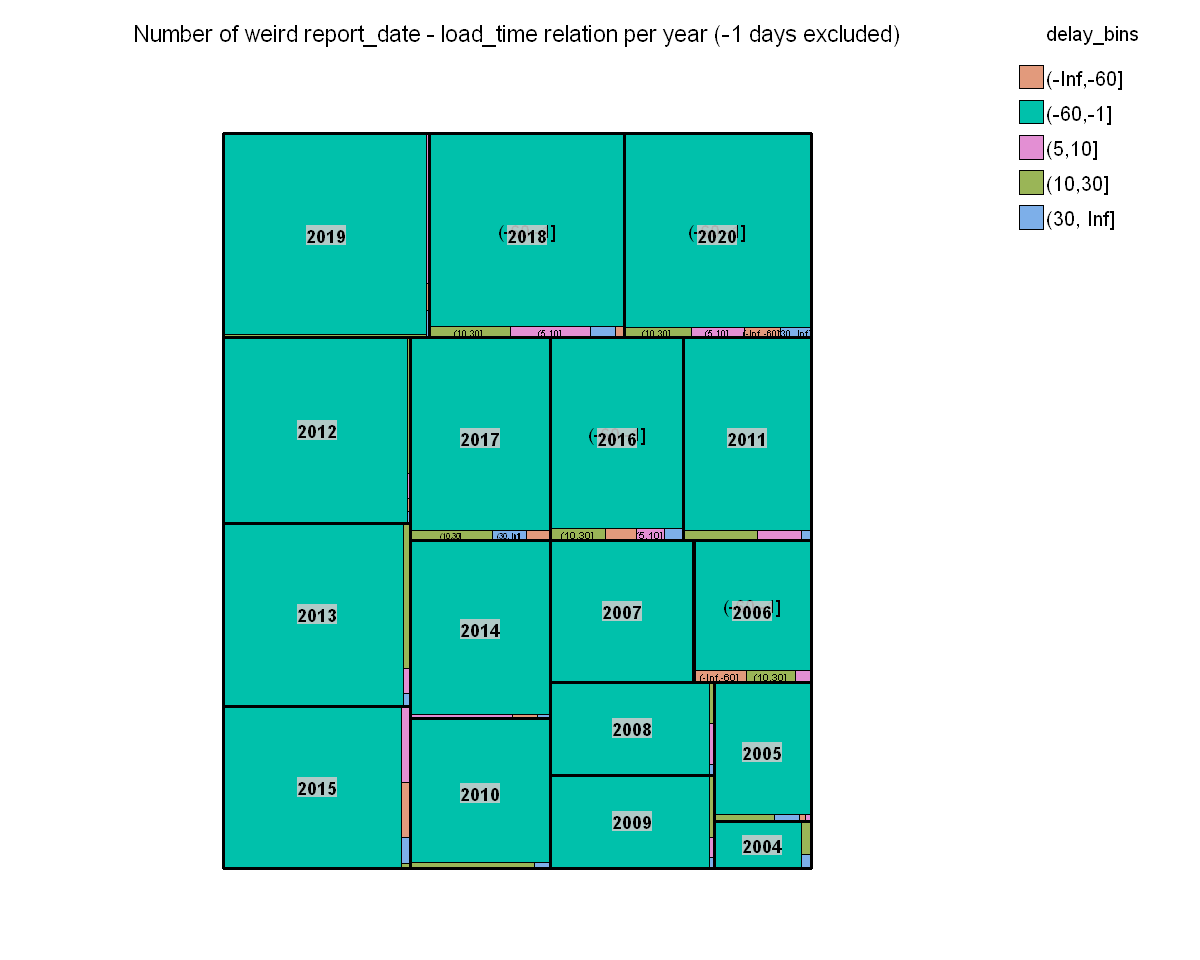

In [172]:
options(repr.plot.width=10, repr.plot.height=8)
dt %>%
  mutate (report_delay_date = as.numeric(report_date - cr_date, unit = "days")) %>%
  filter (report_delay_date < -1 | report_delay_date > 5) %>%
  mutate (delay_bins = cut(report_delay_date, c(-Inf, -60, -1, 1, 5, 10, 30, Inf  ))) %>%
  filter (year %in% seq(2004, 2020)) %>%
  group_by(delay_bins, year) %>%
  summarise (n=n()) %>%
  treemap(index = c('year', 'delay_bins'),
                    vSize = 'n', vColor = 'delay_bins',
                    type = 'categorical',
                    title = "Number of weird report_date - load_time relation per year (-1 days excluded)") 

Conclusion: the number of weird 'record_date' cases (excluding the typical -1 day scenarios) do not decrease over time, as one would expect it in the world of digital transformations.

**Plots and tables related to load_type, route_type and dropoff_site categories**

Share of waste load by all categories in 'load_type' and 'route_type'

In [173]:
dt %>% group_by (load_type) %>% 
   summarise (weight = sum(load_weight, na.rm=TRUE), rounds = n()) %>% 
   arrange (-weight) %>% 
   mutate (weight_share = round(weight / sum(weight),2), round_share = round(rounds / sum(rounds),2))

load_type,weight,rounds,weight_share,round_share
GARBAGE COLLECTIONS,4414309702,258433,0.56,0.35
RECYCLING - SINGLE STREAM,1460816242,147652,0.19,0.20
YARD TRIMMING,789590304,69570,0.10,0.09
BULK,300764817,40120,0.04,0.05
BRUSH,234882597,39164,0.03,0.05
ORGANICS,192513186,17721,0.02,0.02
SWEEPING,190643057,88562,0.02,0.12
RECYCLING - PAPER,141661620,32162,0.02,0.04
RECYCLING - COMINGLE,101514879,31125,0.01,0.04
MULCH,10698833,1343,0.00,0.00


In [174]:
dt %>% group_by (route_type) %>% 
   summarise (weight = sum(load_weight, na.rm=TRUE), rounds = n()) %>% 
   arrange (-weight) %>% 
   mutate (weight_share = round(weight / sum(weight),2), round_share = round(rounds / sum(rounds),2))

route_type,weight,rounds,weight_share,round_share
GARBAGE COLLECTION,4414734497,258429,0.56,0.35
RECYCLING - SINGLE STREAM,1447170272,148465,0.18,0.20
YARD TRIMMINGS,696939839,60559,0.09,0.08
BULK,284665282,39712,0.04,0.05
YARD TRIMMINGS-ORGANICS,277681253,25583,0.04,0.03
RECYCLING,238796831,56479,0.03,0.08
BRUSH,220693843,36673,0.03,0.05
SWEEPER DUMPSITES,190401356,16523,0.02,0.02
STORM,19807086,2703,0.00,0.00
HAULING,13709763,1990,0.00,0.00


Conclusion: There are fairly similar categories in 'load_type' and 'route_type', but not identical. We could not conclude why these two categories exist, why not only one. 

When looked at how the different categories "go together" (i.e. frequency of particular 'load_type' - 'route_type' combination ), the picture did not become clear. One would expect a 1:1 mapping of 'GARBAGE COLLECTIONS' 'load_type' to 'GARBAGE COLLECTION' 'route_type', but this is not the case. Close, but not 100% match, see below.

In [175]:
gettogether <- function (cat1, cat2, dt, years)
{
  dt %>% 
    filter (year %in% years) %>%
    group_by (x = get(cat1), y = get(cat2)) %>%
    summarise (weight = sum(load_weight, na.rm = TRUE)) %>%
    filter (weight > 0) %>%
    ggplot (aes(x, y, fill = log(weight))) + geom_tile(color = "black", size = 0.5) + 
    scale_x_discrete(expand = c(0, 0)) +
    scale_y_discrete(expand = c(0, 0)) +
    scale_fill_viridis_c(option = "magma", direction=-1) +
    labs(title="Weight distribution", subtitle=paste0("by ",cat1, " and ", cat2), caption="   ")  +
    theme_bw()+
    theme(
          plot.title = element_text(size = rel(1.2)),
          axis.text.x=element_text(angle=45,hjust=1,size=7),
          axis.text.y = element_text(size=7),
          axis.title = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_blank(),
          legend.position = "right")
}


`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.


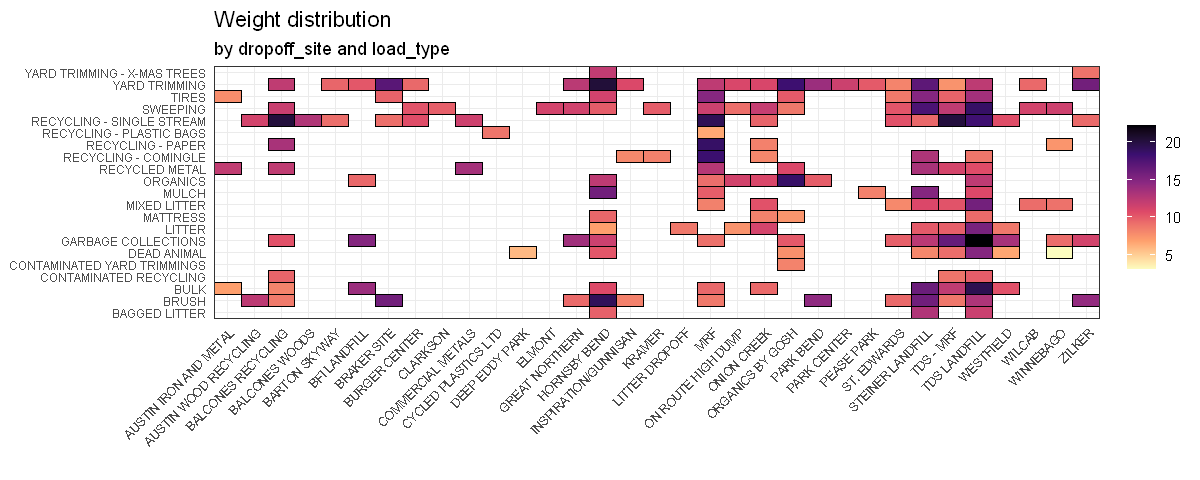

In [176]:
options(repr.plot.width=10, repr.plot.height=4)
gettogether ("dropoff_site", "load_type", dt, seq(2005, 2020))

`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.


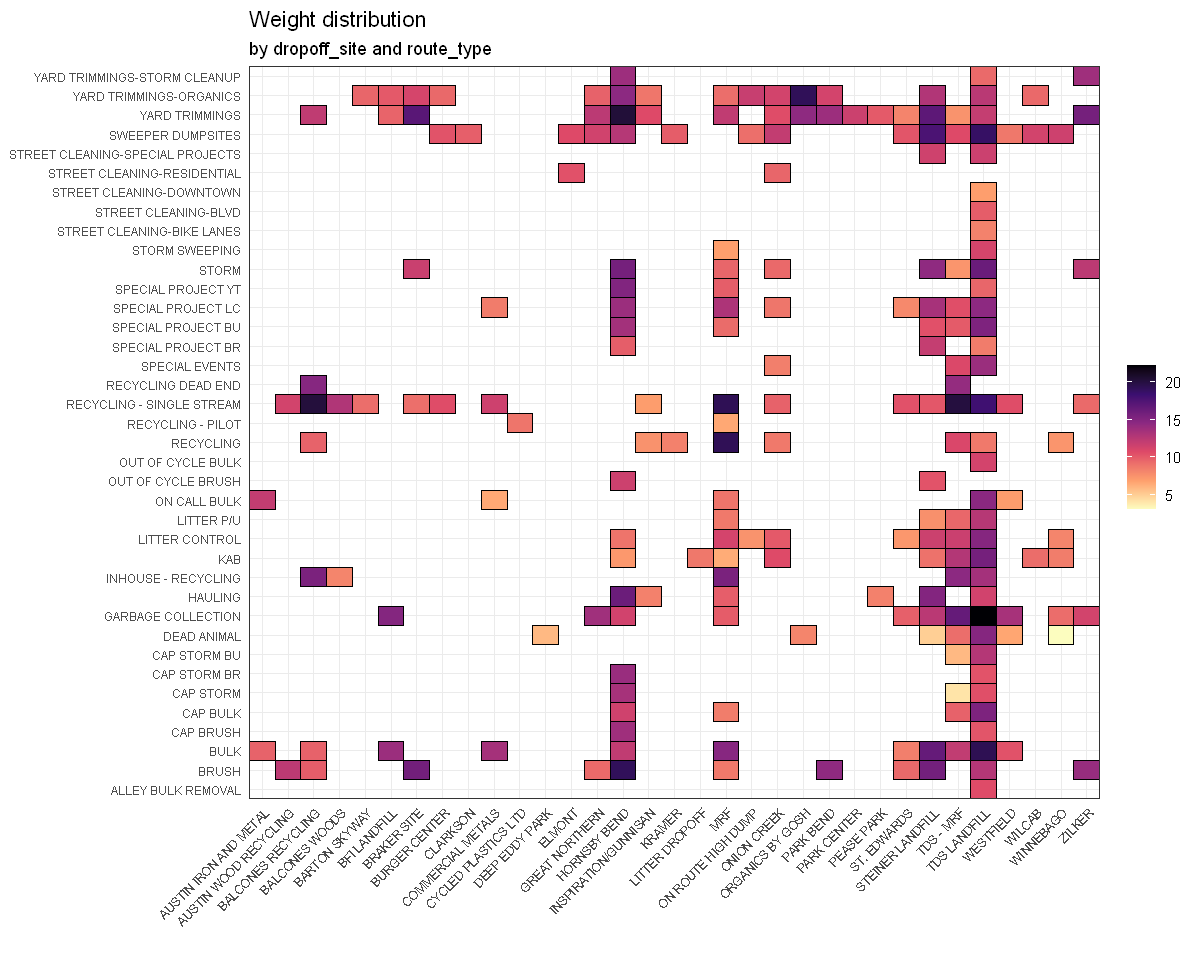

In [177]:
options(repr.plot.width=10, repr.plot.height=8)
gettogether ("dropoff_site", "route_type", dt, seq(2005, 2020))

`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.


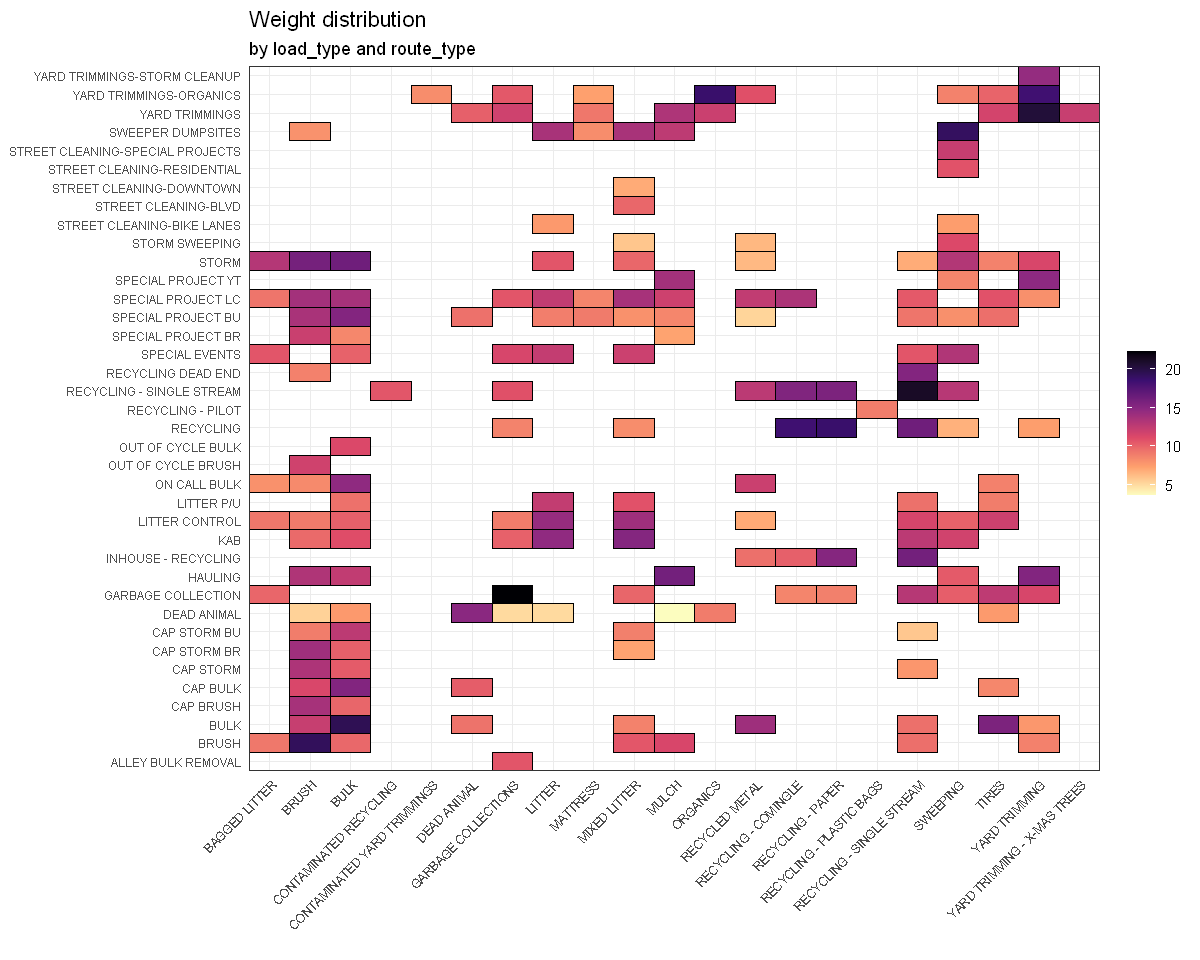

In [178]:
options(repr.plot.width=10, repr.plot.height=8)
gettogether ("load_type", "route_type", dt, seq(2005, 2020))

Conclusion: 

1. There is no 100% match between 'load_type' and 'route_type' categories with the same name. 

2. There are a few "general purpose" dropoff sites, while there are a number of those that are specialized some type of waste (i.e. accepting 1 - 2 type of 'load_type' / 'route_type' categories). These 'specialized' dropoff sites are distributed over Austin.

Categories in years:

The below reveals which load_type, route_type and dropoff_sites were relevant for which years, looking at all categories by 'load_type', 'dropoff_site', 'route_type'.

In [179]:
# Categories in years:
parameters <- c('load_type', 'dropoff_site', 'route_type')

year_view <- function (parameter, dt, years)
{
  
  dt %>%
    filter (year %in% years) %>%
    group_by (x = get(parameter), year) %>%
    summarise (n()) %>%
    pivot_wider (names_from = year, values_from = `n()`) %>%
    mutate_at (vars(starts_with ("2")), ~ifelse (is.na(.), "", "XXXX"))  %>%
    select(sort(names(.))) %>%
    select(x, everything()) %>%
    mutate (x = paste0 (parameter, ": ", x))
}

do.call(rbind, (lapply (parameters, function(x) year_view (x, dt, seq(2005, 2020))))) 

`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.


x,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
load_type: BAGGED LITTER,XXXX,XXXX,,XXXX,XXXX,,,,,XXXX,,XXXX,,,XXXX,
load_type: BRUSH,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX
load_type: BULK,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX
load_type: CONTAMINATED RECYCLING,,,,,,,,,,,,,,XXXX,XXXX,XXXX
load_type: CONTAMINATED YARD TRIMMINGS,,,,,,,,,,,,,,,XXXX,
load_type: DEAD ANIMAL,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX
load_type: GARBAGE COLLECTIONS,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX
load_type: LITTER,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX
load_type: MATTRESS,,,,,,,,,XXXX,XXXX,XXXX,,XXXX,XXXX,,XXXX
load_type: MIXED LITTER,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX,XXXX


***

### Further analysis related to chapter 3. BOUNDARIES_garbage_collection_routes dataset 

**Hypothesis testing related to 'rt_old' in BOUNDARIES_garbage_collection_routes dataset**

Hypothesis: name appears in both old and new routes because it is part of a rename chains, such as: route_A --renamed--> route_B --renamed--> route_C (Possibly more renames between first and last state.)


In such case route_A is only in 'rt_old' (old route), route_B is in both 'rt_old' and 'garb_rt' (both old and new route), route_C is only in 'garb_rt' (new route).

This would mean that route_A occurance in the master waste dataset would be just before the first appearance of route_B, while route_B's last appearance would happen just before route_C first appears in the dataset.

This is verified below.

First let us see the first and last occurrence in the master waste data of routes that are among both old and new routes:

In [180]:
data.frame(intersect (garb_mapdata$rt_old, garb_mapdata$garb_rt)) %>%
  rename_(rt_old = names(.)[1]) %>%
  left_join(dt, by = c("rt_old" = "route_number")) %>%
  group_by (rt_old) %>%
  summarise (first_time = min(load_time), last_time = max(load_time)) %>%
  dplyr::slice (1:10)

rt_old,first_time,last_time
PAF70,2004-11-05 14:59:00,2021-07-02 13:15:00
PAF72,2004-10-01 10:42:00,2021-07-11 07:04:46
PAF73,2004-10-01 14:14:00,2021-07-02 14:45:00
PAF80,2009-03-06 15:34:00,2021-07-02 14:03:00
PAF82,2009-03-06 12:39:00,2021-07-02 13:55:00
PAH05,2004-10-08 14:25:00,2021-07-08 05:47:00
PAH60,2004-08-26 12:16:00,2021-07-08 14:33:00
PAH61,2004-08-26 16:23:00,2021-07-08 14:40:00
PAH63,2004-10-07 13:27:00,2021-07-08 14:40:00
PAH71,2004-10-07 15:49:00,2021-07-08 15:47:00


We already here see a problem: some (many) of thse routes should have ceased to exist once upon a time, but contiued to live basically until the last datapoint in the dataset.

Let us pick the first one, "PAF70", and see the entire renaming chain, tracing back the previous route chain and the successor route chain.

In [181]:
chain_bckwrds <- function (new_route)
{
  old_route <- garb_mapdata %>% 
    st_drop_geometry() %>% 
    filter (garb_rt == new_route) %>% 
    select (rt_old) %>% 
    pull() %>% as.character()
  
  if ((length (old_route) >0) & (length (old_route) < 8 ))  #NA or "NO ROUTE"
  {
    tmp <- chain_bckwrds (old_route)
    lst <- c(old_route, tmp)
  }
  else 
  {
    lst <- "NO ROUTE"
  }
  
  return (lst)
}


chain_fwds <- function (old_route)
{
   new_route <- garb_mapdata %>%
    st_drop_geometry() %>%
    filter (rt_old == old_route) %>%
    select (garb_rt) %>%
    pull() %>% as.character()
    
    if (length(new_route) > 0)
    {
        tmp <- chain_fwds (new_route)
        lst <- c(tmp, new_route)
    }
    else
    {
      lst <- "START"
    }
    
    return (lst)
}

c(chain_fwds("PAF70"), "PAF70", chain_bckwrds ("PAF70"))


[1] "START"    "PAF54"    "PAF70"    "PAF82"    "PAF73"    "PAF74"    "NO ROUTE"

What this tells us is that according to the garbage map data the route that today is called "PAF54" was renamed 4 times. It started as "PAF74", then eventually as "PAF73", then renamed again to "PAF82" just to be renamed as "PAF70", finally obtained its current name.

As stated above, we would expect that first and last appearance of these routes would reflect renaming, e.g. "PAF82" should vanish in the waste dataset just before "PAF70" first appears. 

Let us see first and last appearances of these routes in the waste dataset.

In [182]:
dt %>% filter (route_number %in% c('PAF54','PAF70','PAF82','PAF73','PAF74')) %>%
   group_by (route_number) %>%
   summarise (first_appeared = min (load_time), last_appeared = max (load_time))

route_number,first_appeared,last_appeared
PAF54,2014-07-18 14:31:00,2021-07-02 14:38:00
PAF70,2004-11-05 14:59:00,2021-07-02 13:15:00
PAF73,2004-10-01 14:14:00,2021-07-02 14:45:00
PAF74,2004-10-01 14:00:00,2019-12-16 18:15:00
PAF82,2009-03-06 12:39:00,2021-07-02 13:55:00


The hypothesis failed: appearances of the routes in the master waste dataset is not in any way in line with the route renaming sequence suggested by the garbage route map data.

Either the data is very poor, or just the naming ('rt_old') is misleading and it means something totally different.

This is also confirmed by the below plot, showing that these routes represent different geographical area.


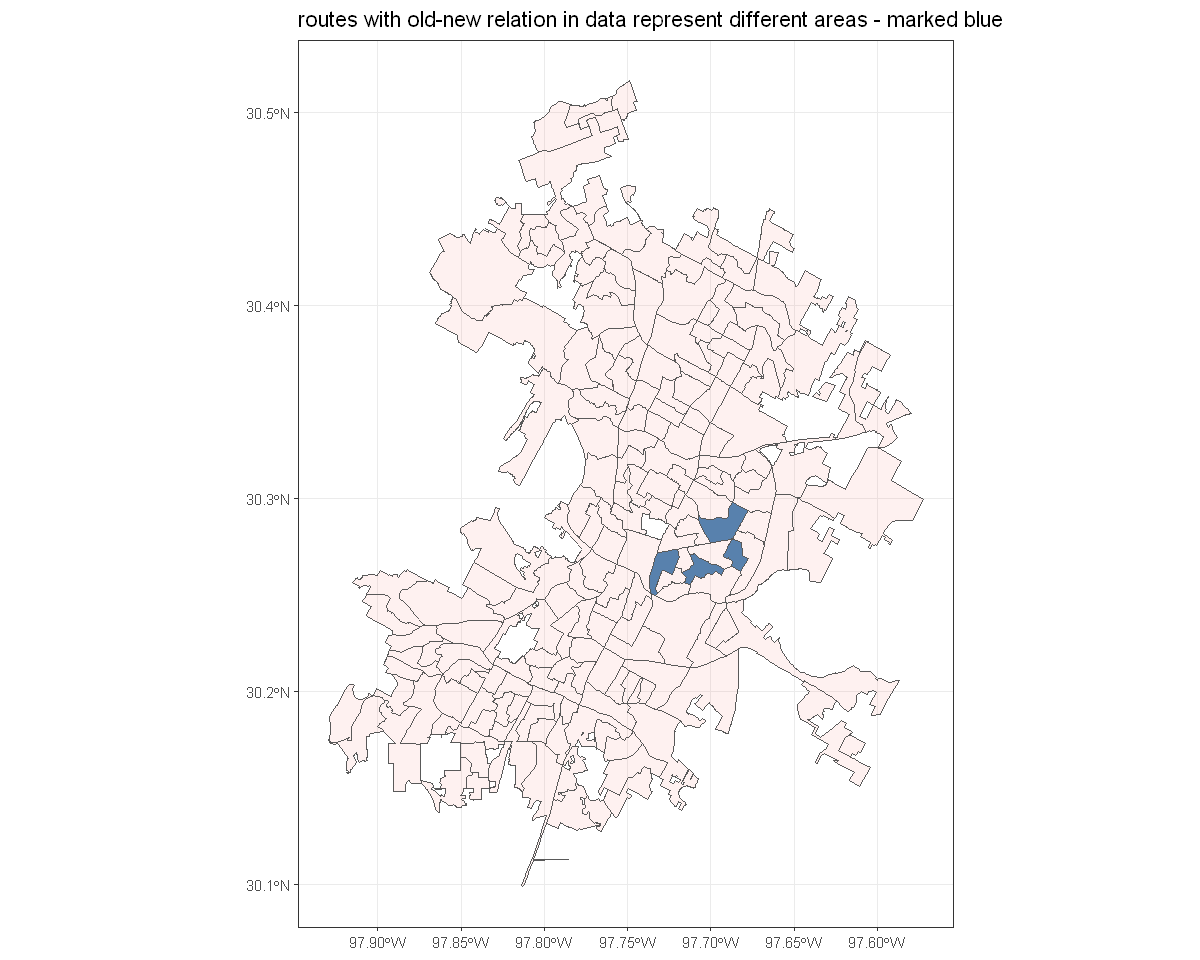

In [183]:
# This cell replaces the cell below leaflet cell due to jupyter -> html leaflet rendering probleem

ggplot () +
    geom_sf (data = garb_mapdata %>% filter (garb_rt %in% c ('PAF54', 'PAF70', 'PAF82', 'PAF73')), fill = "steelblue") + 
    geom_sf (data = garb_mapdata, fill = "#f8766d", alpha = 0.1) + 
    theme_bw() +
    labs (title = "routes with old-new relation in data represent different areas - marked blue")

In [184]:
# cell disabled due to jupyetr html rendering problem. OK in notebook but not when rendered to html. Replaced w. geom_sf above

#garb_mapdata %>% filter (garb_rt %in% c ('PAF54', 'PAF70', 'PAF82', 'PAF73')) %>%
#   leaflet () %>%
#   addProviderTiles(providers$OpenStreetMap.DE) %>%   # For some reason this was needed in order to add map in Jupyter
#   addTiles() %>%
#   addPolygons ()

***

### Further analysis related to 4. BOUNDARIES_recycle_collection_routes dataset

**Hypothesis testing related to 'old_route' in BOUNDARIES_recycle_collection_routes dataset**

This is the same hypothesis testing for the recycle map dataset that was done just above for the garbage route dataset. Hence, there are less comments in this section.

First let us see the first and last occurrence in the master waste data of routes that are both old and new routes.

In [185]:
data.frame(intersect (rec_mapdata$old_route, rec_mapdata$route_name)) %>%
  rename_(old_route = names(.)[1]) %>%
  left_join(dt, by = c("old_route" = "route_number")) %>%
  group_by (old_route) %>%
  summarise (first_time = min(load_time), last_time = max(load_time)) %>%
  dplyr::slice (1:10)

old_route,first_time,last_time
RFAS33,2008-09-19 06:51:00,2021-07-02 12:18:00
RFAS34,2008-09-19 07:27:00,2021-07-02 11:48:00
RFAS35,2008-09-19 06:59:00,2021-06-25 12:00:00
RFAS41,2010-10-15 11:26:00,2021-06-25 12:20:00
RFAS42,2010-10-15 11:56:00,2021-06-25 11:57:00
RFAS43,2010-10-15 13:40:00,2021-06-25 11:46:00
RFAU10,2008-09-19 00:00:00,2021-06-25 13:39:00
RFAU11,2008-09-19 00:00:00,2021-06-25 14:07:00
RFAU12,2008-09-19 00:00:00,2021-06-25 13:44:00
RFAU20,2008-09-19 12:05:00,2021-06-25 14:19:00


Let us pick two 'old_route's, "RFAS33" and "RHAU22", and see the entire renaming chain, tracing back the previous route chain and the successor route chain.

In [186]:
chain_bckwrds <- function (new_route)
{
  old_rt <- rec_mapdata %>% 
    st_drop_geometry() %>% 
    filter (route_name == new_route) %>% 
    select (old_route) %>% 
    pull() %>% as.character()
  
  if ((length (old_rt) >0) & (length (old_rt) < 8 ))  #NA or "NO ROUTE"
  {
    if (old_rt != new_route)   # this is new to the above def. of the same function, as in rec_mapdata we've old=new route
    {
      tmp <- chain_bckwrds (old_rt)
      lst <- c(old_rt, tmp)
    }
    else
    {
      lst <- "SELF"
    }
  }
  else 
  {
    lst <- "NO ROUTE"
  }
  
  return (lst)
}


chain_fwds <- function (old_rt)
{
   new_route <- rec_mapdata %>%
    st_drop_geometry() %>%
    filter (old_route == old_rt) %>%
    select (route_name) %>%
    pull() %>% as.character()
    
    if (length(new_route) > 0)
    {
       if (new_route != old_rt)  # this is new to the above def. of the same function, as in rec_mapdata we've old=new route
       {
         tmp <- chain_fwds (new_route)
         lst <- c(tmp, new_route)
       }
       else 
       {
           lst <- "SELF"
       }
    }
    else
    {
      lst <- "START"
    }
    
    return (lst)
}

c(chain_fwds("RFAS33"), "RFAS33", chain_bckwrds ("RFAS33"))
c(chain_fwds("RHAU22"), "RHAU22", chain_bckwrds ("RHAU22"))

[1] "SELF"   "RFAS33" "SELF"

[1] "START"    "RHAU50"   "RHAU22"   "RHAU20"   "RHAU25"   "NO ROUTE"

"RFAS33" is a case when old and new route names are identical, while "RHAU22" is a "real" renaming chain. Let us see the first and last appearance of the routes making up the latter renaming chain.

In [187]:
dt %>% filter (route_number %in% c('RHAU50', 'RHAU22', 'RHAU20', 'RHAU25')) %>%
   group_by (route_number) %>%
   summarise (first_appeared = min (load_time), last_appeared = max (load_time))

route_number,first_appeared,last_appeared
RHAU20,2008-09-18 12:55:00,2021-06-24 14:45:00
RHAU22,2008-09-18 15:05:00,2021-06-24 14:40:00
RHAU25,2014-06-05 10:18:00,2020-09-17 14:00:00
RHAU50,2017-04-06 09:00:00,2021-06-24 16:00:00


Just as in case of the garbage route map data, these first and last appearance dates do not reflect whatsoever the name changes suggested by the map data. 

And as before, the old and new names point to different geographical areas.

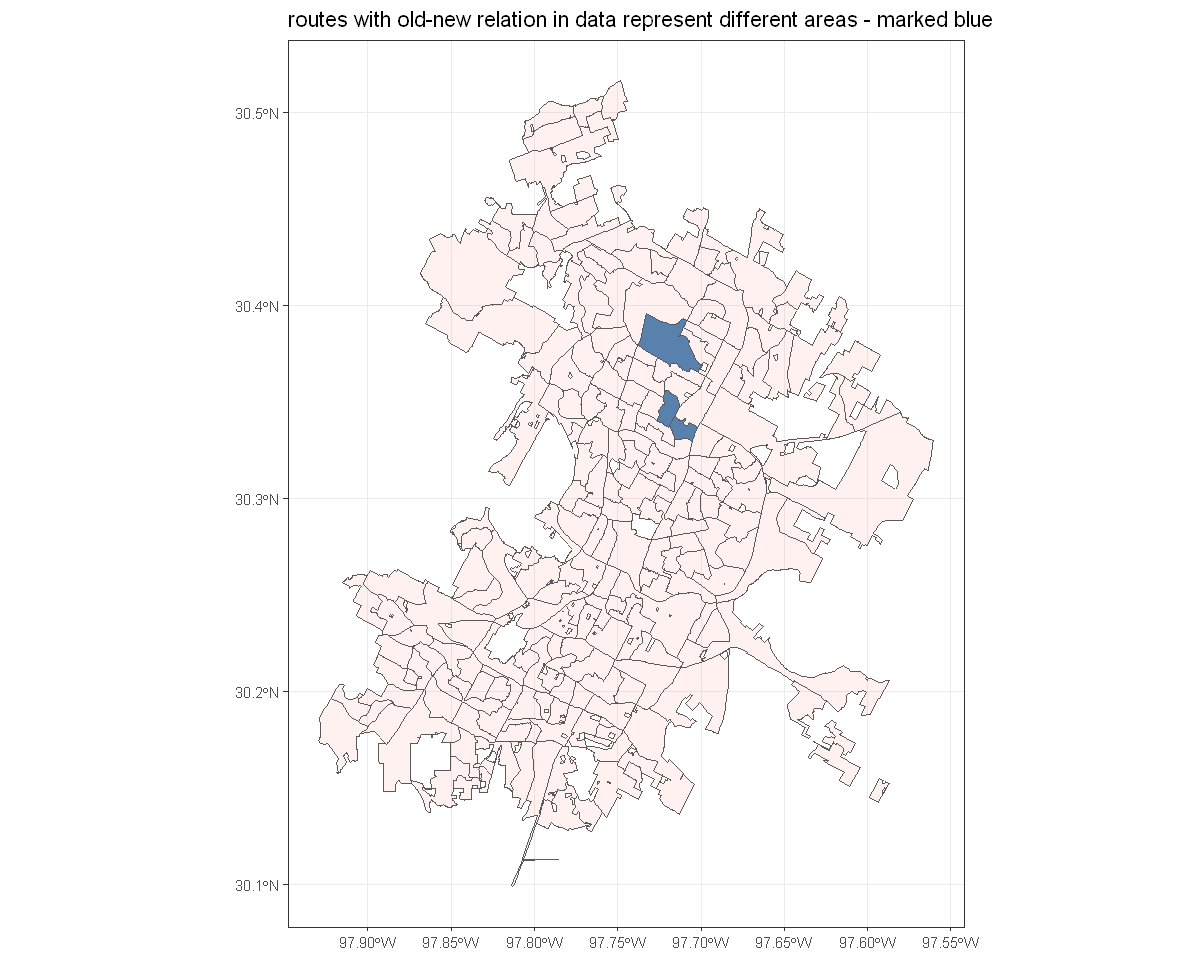

In [188]:
# This cell replaces the cell below leaflet cell due to jupyter -> html leaflet rendering probleem

ggplot () +
    geom_sf (data = rec_mapdata %>% filter (route_name %in% c ('RHAU50', 'RHAU22', 'RHAU20')) , fill = "steelblue") + 
    geom_sf (data = rec_mapdata, fill = "#f8766d", alpha = 0.1) + 
    theme_bw() +
    labs (title = "routes with old-new relation in data represent different areas - marked blue")

In [189]:
# cell disabled due to jupyetr html rendering problem. OK in notebook but not when rendered to html. Replaced w. geom_sf above

#rec_mapdata %>% filter (route_name %in% c ('RHAU50', 'RHAU22', 'RHAU20')) %>%
#   leaflet () %>%
#   addProviderTiles(providers$OpenStreetMap.DE) %>%   # For some reason this was needed in order to add map in Jupyter
#   addTiles() %>%
#   addPolygons ()

***